In [1]:
import pandas as pd

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.utils import plot_model

import keras

import optuna

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import (
    accuracy_score,
    f1_score
)

from imblearn.over_sampling import SMOTE

c:\Users\micha\anaconda3\envs\msds-data-science-project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 1. Load the dataset
df = pd.read_csv("datasets/3. online_shoppers_intention_clean.csv")

# 2. Select relevant columns
df = df[[
    "Administrative", "Informational", "ProductRelated",
    "BounceRates", "ExitRates", "PageValues", "Month",
    "TrafficType", "VisitorType", "Revenue"
]]

# 3. Separate input features and target
X = df.drop(columns=["Revenue"])
y = df["Revenue"]

# 4. Split the data into train_val and test sets (80% train_val, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5. Split the train_val into training and validation sets (75% train, 25% val)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)  # 0.25 x 0.8 = 0.2

# 6. Define numerical and categorical columns
numerical_features = [
    "Administrative", "Informational", "ProductRelated",
    "BounceRates", "ExitRates", "PageValues"
]
categorical_features = ["Month", "TrafficType", "VisitorType"]

# 7. Preprocess numerical features
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_train[numerical_features])

# Transform the numerical features
X_train_scaled = min_max_scaler.transform(X_train[numerical_features])
X_val_scaled = min_max_scaler.transform(X_val[numerical_features])
X_test_scaled = min_max_scaler.transform(X_test[numerical_features])

# Convert scaled arrays back to dataframes for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=numerical_features, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=numerical_features, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=numerical_features, index=X_test.index)

# 8. Preprocess categorical features
# Initialise the OneHotEncoder
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False) # sparse_output=False turns the data into NumPy array

# Fit the encoder on the training data
one_hot_encoder.fit(X_train[categorical_features])

# Transform the categorical features
X_train_encoded = one_hot_encoder.transform(X_train[categorical_features])
X_val_encoded = one_hot_encoder.transform(X_val[categorical_features])
X_test_encoded = one_hot_encoder.transform(X_test[categorical_features])

# Get the new feature names after one-hot encoding
encoded_feature_names = one_hot_encoder.get_feature_names_out(categorical_features)

# Convert encoded arrays back to dataframes
X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoded_feature_names, index=X_train.index)
X_val_encoded = pd.DataFrame(X_val_encoded, columns=encoded_feature_names, index=X_val.index)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=encoded_feature_names, index=X_test.index)

# 9. Combine processed features
X_train_processed = pd.concat([X_train_scaled, X_train_encoded], axis=1)
X_val_processed = pd.concat([X_val_scaled, X_val_encoded], axis=1)
X_test_processed = pd.concat([X_test_scaled, X_test_encoded], axis=1)

# Verify the shapes
print("Processed Training Data Shape:", X_train_processed.shape)
print("Processed Validation Data Shape:", X_val_processed.shape)
print("Processed Test Data Shape:", X_test_processed.shape)

# 10. Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

# Verify the resampled data
print("Resampled Training Data Shape:", X_train_resampled.shape)
print("Resampled Training Target Distribution:\n", y_train_resampled.value_counts())

# 11. Reset indices
X_train_resampled.reset_index(drop=True, inplace=True)
y_train_resampled.reset_index(drop=True, inplace=True)

X_val_processed.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)

X_test_processed.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# 12. Final verification
print("Final Training Data Shape:", X_train_resampled.shape)
print("Final Validation Data Shape:", X_val_processed.shape)
print("Final Test Data Shape:", X_test_processed.shape)

Processed Training Data Shape: (7334, 38)
Processed Validation Data Shape: (2445, 38)
Processed Test Data Shape: (2445, 38)
Resampled Training Data Shape: (12378, 38)
Resampled Training Target Distribution:
 Revenue
False    6189
True     6189
Name: count, dtype: int64
Final Training Data Shape: (12378, 38)
Final Validation Data Shape: (2445, 38)
Final Test Data Shape: (2445, 38)


# WARNING: DO NOT RUN THE CELL BELOW IF YOU DO NOT WANT TO RUN OPTIMISATION, AS IT MAY TAKE HOURS TO DAYS TO COMPLETE

In [ ]:
# 13. Set seed for reproducability
keras.utils.set_random_seed(42)

# 14. Define the function to create NN model
def create_model(trial):
    # Hyperparameters to tune
    n_hidden_layers = trial.suggest_int('n_hidden_layers', 1, 3)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'elu'])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop', 'sgd'])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    n_neurons = trial.suggest_int('n_neurons', 16, 128)
    
    # Choose the optimiser
    optimizer = {
        'adam': Adam(learning_rate=learning_rate),
        'rmsprop': RMSprop(learning_rate=learning_rate),
        'sgd': SGD(learning_rate=learning_rate)
    }[optimizer_name]
    
    # Build the model
    model = Sequential()
    
    # Add input layer
    model.add(Input(shape=(X_train_resampled.shape[1],))) # Dynamically adjusts based on the number of columns of the dataset
    
    # First hidden layer
    model.add(Dense(n_neurons, activation=activation))
    
    # Additional hidden layers
    for i in range(n_hidden_layers - 1): # -1 as already added the first layer
        model.add(Dense(n_neurons, activation=activation))
        model.add(Dropout(dropout_rate)) # Add dropout layer to minimise overfitting
    
    # Output layer for binary classification
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# 15. Define the objective function for Optuna 
def objective(trial):
    try:
        # Create the model
        model = create_model(trial)
        
        # Suggest batch size
        batch_size = trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64, 128])
        
        # Define early stopping
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=20
        )
        
        # Train the model
        history = model.fit(
            X_train_resampled, y_train_resampled,
            validation_data=(X_val_processed, y_val),
            epochs=100,
            batch_size=batch_size,
            callbacks=[early_stopping],
            verbose=0
        )
        
        # Evaluate the model on validation data
        score = model.evaluate(X_val_processed, y_val, verbose=0)
        return score[1]  # Return validation accuracy

    finally:
        # Clear keras session to free memory
        K.clear_session()

# 16. Set up the study
study_name = "neural_network_optimisation_1"
storage_name = "sqlite:///optuna_study_neural_network_1.db" # Use .db so that a record store of all trials will be saved

study = optuna.create_study(
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42))  

# 17. Optimise the objective function with 1000 trials
study.optimize(objective, n_trials=1000, timeout=None, show_progress_bar=True)

# 18. Retrieve and display the best trial 
print("\nBest trial:")
trial = study.best_trial
print(f"  Validation Accuracy: {trial.value:.4f}")
print("  Hyperparameters: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

c:\Users\micha\anaconda3\envs\msds-data-science-project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-10-19 09:38:37,869] A new study created in RDB with name: neural_network_optimisation_1
  0%|          | 0/1000 [00:00<?, ?it/s]

Best trial: 0. Best value: 0.676892:   0%|          | 1/1000 [04:27<74:06:47, 267.07s/it]

[I 2024-10-19 09:43:04,937] Trial 0 finished with value: 0.6768916249275208 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 2.9380279387035334e-05, 'optimizer': 'sgd', 'dropout_rate': 0.34044600469728353, 'n_neurons': 96, 'batch_size': 2}. Best is trial 0 with value: 0.6768916249275208.


Best trial: 0. Best value: 0.676892:   0%|          | 2/1000 [04:41<32:50:16, 118.45s/it]

[I 2024-10-19 09:43:19,359] Trial 1 finished with value: 0.6429448127746582 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 7.52374288453485e-05, 'optimizer': 'sgd', 'dropout_rate': 0.1798695128633439, 'n_neurons': 74, 'batch_size': 64}. Best is trial 0 with value: 0.6768916249275208.


Best trial: 0. Best value: 0.676892:   0%|          | 3/1000 [05:18<22:28:58, 81.18s/it] 

[I 2024-10-19 09:43:56,188] Trial 2 finished with value: 0.6229038834571838 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 2.32335035153901e-05, 'optimizer': 'sgd', 'dropout_rate': 0.20351199264000677, 'n_neurons': 90, 'batch_size': 16}. Best is trial 0 with value: 0.6768916249275208.


Best trial: 3. Best value: 0.734151:   0%|          | 4/1000 [05:42<16:16:23, 58.82s/it]

[I 2024-10-19 09:44:20,724] Trial 3 finished with value: 0.734151303768158 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 1.3667272915456215e-05, 'optimizer': 'rmsprop', 'dropout_rate': 0.43149500366077176, 'n_neurons': 56, 'batch_size': 32}. Best is trial 3 with value: 0.734151303768158.


Best trial: 4. Best value: 0.871984:   0%|          | 5/1000 [05:48<10:59:58, 39.80s/it]

[I 2024-10-19 09:44:26,796] Trial 4 finished with value: 0.8719836473464966 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0020597335357437196, 'optimizer': 'rmsprop', 'dropout_rate': 0.4452413703502375, 'n_neurons': 86, 'batch_size': 64}. Best is trial 4 with value: 0.8719836473464966.


Best trial: 4. Best value: 0.871984:   1%|          | 6/1000 [06:26<10:45:59, 38.99s/it]

[I 2024-10-19 09:45:04,226] Trial 5 finished with value: 0.8490797281265259 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.002055424552015075, 'optimizer': 'rmsprop', 'dropout_rate': 0.11016765069763808, 'n_neurons': 28, 'batch_size': 16}. Best is trial 4 with value: 0.8719836473464966.


Best trial: 4. Best value: 0.871984:   1%|          | 7/1000 [07:33<13:16:18, 48.12s/it]

[I 2024-10-19 09:46:11,124] Trial 6 finished with value: 0.8257668614387512 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.006153085601625313, 'optimizer': 'sgd', 'dropout_rate': 0.4214688307596458, 'n_neurons': 37, 'batch_size': 8}. Best is trial 4 with value: 0.8719836473464966.


Best trial: 4. Best value: 0.871984:   1%|          | 8/1000 [08:45<15:21:58, 55.76s/it]

[I 2024-10-19 09:47:23,266] Trial 7 finished with value: 0.6413087844848633 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.000178744632562384, 'optimizer': 'sgd', 'dropout_rate': 0.47716388156500766, 'n_neurons': 52, 'batch_size': 8}. Best is trial 4 with value: 0.8719836473464966.


Best trial: 4. Best value: 0.871984:   1%|          | 9/1000 [13:20<34:14:32, 124.39s/it]

[I 2024-10-19 09:51:58,557] Trial 8 finished with value: 0.8016359806060791 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 1.4270403521460843e-05, 'optimizer': 'rmsprop', 'dropout_rate': 0.15795794883648925, 'n_neurons': 71, 'batch_size': 1}. Best is trial 4 with value: 0.8719836473464966.


Best trial: 4. Best value: 0.871984:   1%|          | 10/1000 [13:23<23:55:30, 87.00s/it]

[I 2024-10-19 09:52:01,831] Trial 9 finished with value: 0.580777108669281 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 9.169384722192322e-05, 'optimizer': 'sgd', 'dropout_rate': 0.37102574473691297, 'n_neurons': 17, 'batch_size': 64}. Best is trial 4 with value: 0.8719836473464966.


Best trial: 4. Best value: 0.871984:   1%|          | 11/1000 [13:32<17:17:20, 62.93s/it]

[I 2024-10-19 09:52:10,193] Trial 10 finished with value: 0.855623722076416 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.001082725997676882, 'optimizer': 'adam', 'dropout_rate': 0.2758541800454106, 'n_neurons': 118, 'batch_size': 128}. Best is trial 4 with value: 0.8719836473464966.


Best trial: 4. Best value: 0.871984:   1%|          | 12/1000 [13:43<12:55:07, 47.07s/it]

[I 2024-10-19 09:52:20,990] Trial 11 finished with value: 0.8449897766113281 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0008533716477932964, 'optimizer': 'adam', 'dropout_rate': 0.2628900279921989, 'n_neurons': 124, 'batch_size': 128}. Best is trial 4 with value: 0.8719836473464966.


Best trial: 4. Best value: 0.871984:   1%|▏         | 13/1000 [14:59<15:18:25, 55.83s/it]

[I 2024-10-19 09:53:36,974] Trial 12 finished with value: 0.8548057079315186 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0009003024260107702, 'optimizer': 'adam', 'dropout_rate': 0.2778221569730276, 'n_neurons': 124, 'batch_size': 4}. Best is trial 4 with value: 0.8719836473464966.


Best trial: 4. Best value: 0.871984:   1%|▏         | 14/1000 [15:02<10:58:59, 40.10s/it]

[I 2024-10-19 09:53:40,730] Trial 13 finished with value: 0.8008179664611816 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.005045365190356968, 'optimizer': 'adam', 'dropout_rate': 0.3163433109090524, 'n_neurons': 105, 'batch_size': 128}. Best is trial 4 with value: 0.8719836473464966.


Best trial: 4. Best value: 0.871984:   2%|▏         | 15/1000 [15:08<8:07:35, 29.70s/it] 

[I 2024-10-19 09:53:46,327] Trial 14 finished with value: 0.8359917998313904 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.0006065374309681331, 'optimizer': 'adam', 'dropout_rate': 0.23056672938298622, 'n_neurons': 111, 'batch_size': 128}. Best is trial 4 with value: 0.8719836473464966.


Best trial: 4. Best value: 0.871984:   2%|▏         | 16/1000 [15:15<6:16:39, 22.97s/it]

[I 2024-10-19 09:53:53,657] Trial 15 finished with value: 0.8658486604690552 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.002264141009982302, 'optimizer': 'rmsprop', 'dropout_rate': 0.49840679574448554, 'n_neurons': 83, 'batch_size': 64}. Best is trial 4 with value: 0.8719836473464966.


Best trial: 16. Best value: 0.874847:   2%|▏         | 17/1000 [15:20<4:48:31, 17.61s/it]

[I 2024-10-19 09:53:58,810] Trial 16 finished with value: 0.8748466372489929 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0028548786567954834, 'optimizer': 'rmsprop', 'dropout_rate': 0.4988635157448908, 'n_neurons': 82, 'batch_size': 64}. Best is trial 16 with value: 0.8748466372489929.


Best trial: 17. Best value: 0.876892:   2%|▏         | 18/1000 [15:24<3:39:40, 13.42s/it]

[I 2024-10-19 09:54:02,480] Trial 17 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00867514565549096, 'optimizer': 'rmsprop', 'dropout_rate': 0.432251090838101, 'n_neurons': 64, 'batch_size': 64}. Best is trial 17 with value: 0.8768916130065918.


Best trial: 17. Best value: 0.876892:   2%|▏         | 19/1000 [15:28<2:52:42, 10.56s/it]

[I 2024-10-19 09:54:06,385] Trial 18 finished with value: 0.8715746402740479 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007209451374297704, 'optimizer': 'rmsprop', 'dropout_rate': 0.3887781922242813, 'n_neurons': 59, 'batch_size': 64}. Best is trial 17 with value: 0.8768916130065918.


Best trial: 17. Best value: 0.876892:   2%|▏         | 20/1000 [15:34<2:28:17,  9.08s/it]

[I 2024-10-19 09:54:12,003] Trial 19 finished with value: 0.873210608959198 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00845137233026822, 'optimizer': 'rmsprop', 'dropout_rate': 0.46011128625475595, 'n_neurons': 69, 'batch_size': 32}. Best is trial 17 with value: 0.8768916130065918.


Best trial: 17. Best value: 0.876892:   2%|▏         | 21/1000 [17:20<10:24:40, 38.28s/it]

[I 2024-10-19 09:55:58,381] Trial 20 finished with value: 0.8413087725639343 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0003176707576644598, 'optimizer': 'rmsprop', 'dropout_rate': 0.3797742515728846, 'n_neurons': 47, 'batch_size': 1}. Best is trial 17 with value: 0.8768916130065918.


Best trial: 17. Best value: 0.876892:   2%|▏         | 22/1000 [17:26<7:43:58, 28.46s/it] 

[I 2024-10-19 09:56:03,943] Trial 21 finished with value: 0.8601226806640625 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008830593604462929, 'optimizer': 'rmsprop', 'dropout_rate': 0.4683955610686463, 'n_neurons': 69, 'batch_size': 32}. Best is trial 17 with value: 0.8768916130065918.


Best trial: 17. Best value: 0.876892:   2%|▏         | 23/1000 [17:32<5:56:51, 21.92s/it]

[I 2024-10-19 09:56:10,584] Trial 22 finished with value: 0.8752556443214417 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0038113092110676206, 'optimizer': 'rmsprop', 'dropout_rate': 0.49941387659550074, 'n_neurons': 65, 'batch_size': 32}. Best is trial 17 with value: 0.8768916130065918.


Best trial: 17. Best value: 0.876892:   2%|▏         | 24/1000 [18:04<6:42:50, 24.77s/it]

[I 2024-10-19 09:56:41,997] Trial 23 finished with value: 0.8503067493438721 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0034934100412662545, 'optimizer': 'rmsprop', 'dropout_rate': 0.49118674358787345, 'n_neurons': 78, 'batch_size': 4}. Best is trial 17 with value: 0.8768916130065918.


Best trial: 17. Best value: 0.876892:   2%|▎         | 25/1000 [19:04<9:35:27, 35.41s/it]

[I 2024-10-19 09:57:42,251] Trial 24 finished with value: 0.8372188210487366 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.0028770243493629255, 'optimizer': 'rmsprop', 'dropout_rate': 0.42156063251046044, 'n_neurons': 64, 'batch_size': 2}. Best is trial 17 with value: 0.8768916130065918.


Best trial: 17. Best value: 0.876892:   3%|▎         | 26/1000 [19:10<7:12:08, 26.62s/it]

[I 2024-10-19 09:57:48,358] Trial 25 finished with value: 0.8654396533966064 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004323953548447893, 'optimizer': 'rmsprop', 'dropout_rate': 0.3980610973422374, 'n_neurons': 93, 'batch_size': 32}. Best is trial 17 with value: 0.8768916130065918.


Best trial: 17. Best value: 0.876892:   3%|▎         | 27/1000 [19:19<5:45:49, 21.32s/it]

[I 2024-10-19 09:57:57,326] Trial 26 finished with value: 0.8674846887588501 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0014574594660680994, 'optimizer': 'rmsprop', 'dropout_rate': 0.464893734199201, 'n_neurons': 41, 'batch_size': 64}. Best is trial 17 with value: 0.8768916130065918.


Best trial: 17. Best value: 0.876892:   3%|▎         | 28/1000 [19:25<4:33:16, 16.87s/it]

[I 2024-10-19 09:58:03,800] Trial 27 finished with value: 0.8625766634941101 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.0005718082597569793, 'optimizer': 'rmsprop', 'dropout_rate': 0.4987845593551824, 'n_neurons': 101, 'batch_size': 64}. Best is trial 17 with value: 0.8768916130065918.


Best trial: 17. Best value: 0.876892:   3%|▎         | 29/1000 [19:32<3:41:20, 13.68s/it]

[I 2024-10-19 09:58:10,029] Trial 28 finished with value: 0.869529664516449 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004091678274023042, 'optimizer': 'rmsprop', 'dropout_rate': 0.3523455648214642, 'n_neurons': 80, 'batch_size': 32}. Best is trial 17 with value: 0.8768916130065918.


Best trial: 17. Best value: 0.876892:   3%|▎         | 30/1000 [20:37<7:49:53, 29.07s/it]

[I 2024-10-19 09:59:14,999] Trial 29 finished with value: 0.6429448127746582 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.009933943670648914, 'optimizer': 'rmsprop', 'dropout_rate': 0.32954189735121653, 'n_neurons': 62, 'batch_size': 2}. Best is trial 17 with value: 0.8768916130065918.


Best trial: 17. Best value: 0.876892:   3%|▎         | 31/1000 [20:49<6:29:26, 24.11s/it]

[I 2024-10-19 09:59:27,561] Trial 30 finished with value: 0.8646216988563538 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0003383201705156325, 'optimizer': 'rmsprop', 'dropout_rate': 0.44401634174540594, 'n_neurons': 49, 'batch_size': 64}. Best is trial 17 with value: 0.8768916130065918.


Best trial: 17. Best value: 0.876892:   3%|▎         | 32/1000 [20:55<5:01:17, 18.67s/it]

[I 2024-10-19 09:59:33,544] Trial 31 finished with value: 0.8691206574440002 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005290456890378203, 'optimizer': 'rmsprop', 'dropout_rate': 0.4594336495958373, 'n_neurons': 69, 'batch_size': 32}. Best is trial 17 with value: 0.8768916130065918.


Best trial: 17. Best value: 0.876892:   3%|▎         | 33/1000 [21:01<3:57:10, 14.72s/it]

[I 2024-10-19 09:59:39,023] Trial 32 finished with value: 0.8748466372489929 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00751970684697622, 'optimizer': 'rmsprop', 'dropout_rate': 0.41004982790994005, 'n_neurons': 76, 'batch_size': 32}. Best is trial 17 with value: 0.8768916130065918.


Best trial: 17. Best value: 0.876892:   3%|▎         | 34/1000 [21:08<3:19:19, 12.38s/it]

[I 2024-10-19 09:59:45,955] Trial 33 finished with value: 0.8658486604690552 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0031238878736949242, 'optimizer': 'rmsprop', 'dropout_rate': 0.40431898193135063, 'n_neurons': 75, 'batch_size': 32}. Best is trial 17 with value: 0.8768916130065918.


Best trial: 17. Best value: 0.876892:   4%|▎         | 35/1000 [21:20<3:18:45, 12.36s/it]

[I 2024-10-19 09:59:58,261] Trial 34 finished with value: 0.8527607321739197 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.0014021398590476377, 'optimizer': 'rmsprop', 'dropout_rate': 0.35342490262182324, 'n_neurons': 88, 'batch_size': 16}. Best is trial 17 with value: 0.8768916130065918.


Best trial: 17. Best value: 0.876892:   4%|▎         | 36/1000 [21:40<3:56:28, 14.72s/it]

[I 2024-10-19 10:00:18,487] Trial 35 finished with value: 0.7963190078735352 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.005804002951497396, 'optimizer': 'sgd', 'dropout_rate': 0.43436521448444404, 'n_neurons': 95, 'batch_size': 32}. Best is trial 17 with value: 0.8768916130065918.


Best trial: 17. Best value: 0.876892:   4%|▎         | 37/1000 [21:47<3:18:09, 12.35s/it]

[I 2024-10-19 10:00:25,298] Trial 36 finished with value: 0.8707566261291504 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0023693929656369624, 'optimizer': 'rmsprop', 'dropout_rate': 0.41202784873146403, 'n_neurons': 58, 'batch_size': 64}. Best is trial 17 with value: 0.8768916130065918.


Best trial: 17. Best value: 0.876892:   4%|▍         | 38/1000 [22:08<4:00:19, 14.99s/it]

[I 2024-10-19 10:00:46,452] Trial 37 finished with value: 0.8494887351989746 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0017349075522733052, 'optimizer': 'rmsprop', 'dropout_rate': 0.4784595644276421, 'n_neurons': 84, 'batch_size': 8}. Best is trial 17 with value: 0.8768916130065918.


Best trial: 17. Best value: 0.876892:   4%|▍         | 39/1000 [22:45<5:45:11, 21.55s/it]

[I 2024-10-19 10:01:23,318] Trial 38 finished with value: 0.8339468240737915 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.009824093203257124, 'optimizer': 'sgd', 'dropout_rate': 0.44176087869120667, 'n_neurons': 65, 'batch_size': 16}. Best is trial 17 with value: 0.8768916130065918.


Best trial: 17. Best value: 0.876892:   4%|▍         | 40/1000 [25:33<17:26:23, 65.40s/it]

[I 2024-10-19 10:04:11,028] Trial 39 finished with value: 0.8179959058761597 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 7.072668468184417e-05, 'optimizer': 'rmsprop', 'dropout_rate': 0.4812926873192823, 'n_neurons': 54, 'batch_size': 1}. Best is trial 17 with value: 0.8768916130065918.


Best trial: 17. Best value: 0.876892:   4%|▍         | 41/1000 [26:07<14:54:19, 55.95s/it]

[I 2024-10-19 10:04:44,941] Trial 40 finished with value: 0.7042945027351379 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.0062000769314790065, 'optimizer': 'rmsprop', 'dropout_rate': 0.4512423527592159, 'n_neurons': 42, 'batch_size': 4}. Best is trial 17 with value: 0.8768916130065918.


Best trial: 17. Best value: 0.876892:   4%|▍         | 42/1000 [26:12<10:51:29, 40.80s/it]

[I 2024-10-19 10:04:50,394] Trial 41 finished with value: 0.8621677160263062 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007573632915525213, 'optimizer': 'rmsprop', 'dropout_rate': 0.45875462058320005, 'n_neurons': 75, 'batch_size': 32}. Best is trial 17 with value: 0.8768916130065918.


Best trial: 17. Best value: 0.876892:   4%|▍         | 43/1000 [26:19<8:07:09, 30.54s/it] 

[I 2024-10-19 10:04:56,995] Trial 42 finished with value: 0.8715746402740479 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0038271033892411615, 'optimizer': 'rmsprop', 'dropout_rate': 0.42865142198934014, 'n_neurons': 73, 'batch_size': 32}. Best is trial 17 with value: 0.8768916130065918.


Best trial: 17. Best value: 0.876892:   4%|▍         | 44/1000 [26:24<6:06:28, 23.00s/it]

[I 2024-10-19 10:05:02,397] Trial 43 finished with value: 0.8744376301765442 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007176541870105, 'optimizer': 'rmsprop', 'dropout_rate': 0.48033523798168254, 'n_neurons': 66, 'batch_size': 32}. Best is trial 17 with value: 0.8768916130065918.


Best trial: 17. Best value: 0.876892:   4%|▍         | 45/1000 [26:44<5:51:59, 22.11s/it]

[I 2024-10-19 10:05:22,442] Trial 44 finished with value: 0.7415133118629456 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.0027690595897927653, 'optimizer': 'sgd', 'dropout_rate': 0.49957766254044467, 'n_neurons': 65, 'batch_size': 32}. Best is trial 17 with value: 0.8768916130065918.


Best trial: 17. Best value: 0.876892:   5%|▍         | 46/1000 [26:48<4:26:55, 16.79s/it]

[I 2024-10-19 10:05:26,802] Trial 45 finished with value: 0.8736196160316467 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00495847374652511, 'optimizer': 'rmsprop', 'dropout_rate': 0.1016276929675653, 'n_neurons': 80, 'batch_size': 64}. Best is trial 17 with value: 0.8768916130065918.


Best trial: 17. Best value: 0.876892:   5%|▍         | 47/1000 [27:50<8:00:18, 30.24s/it]

[I 2024-10-19 10:06:28,430] Trial 46 finished with value: 0.8633946776390076 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006142826600571358, 'optimizer': 'adam', 'dropout_rate': 0.4766073590011197, 'n_neurons': 55, 'batch_size': 2}. Best is trial 17 with value: 0.8768916130065918.


Best trial: 17. Best value: 0.876892:   5%|▍         | 48/1000 [29:02<11:18:07, 42.74s/it]

[I 2024-10-19 10:07:40,333] Trial 47 finished with value: 0.8588957190513611 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00016507745194375555, 'optimizer': 'rmsprop', 'dropout_rate': 0.14798022030698432, 'n_neurons': 90, 'batch_size': 8}. Best is trial 17 with value: 0.8768916130065918.


Best trial: 17. Best value: 0.876892:   5%|▍         | 49/1000 [29:23<9:35:23, 36.30s/it] 

[I 2024-10-19 10:08:01,618] Trial 48 finished with value: 0.8670756816864014 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.0035392554432067376, 'optimizer': 'rmsprop', 'dropout_rate': 0.37061699856958663, 'n_neurons': 60, 'batch_size': 32}. Best is trial 17 with value: 0.8768916130065918.


Best trial: 17. Best value: 0.876892:   5%|▌         | 50/1000 [29:38<7:51:22, 29.77s/it]

[I 2024-10-19 10:08:16,150] Trial 49 finished with value: 0.7959100008010864 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 3.4087735786428436e-05, 'optimizer': 'adam', 'dropout_rate': 0.416565549542791, 'n_neurons': 31, 'batch_size': 64}. Best is trial 17 with value: 0.8768916130065918.


Best trial: 17. Best value: 0.876892:   5%|▌         | 51/1000 [29:58<7:05:49, 26.92s/it]

[I 2024-10-19 10:08:36,424] Trial 50 finished with value: 0.7022494673728943 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.001842813663377843, 'optimizer': 'sgd', 'dropout_rate': 0.47896614296889534, 'n_neurons': 98, 'batch_size': 32}. Best is trial 17 with value: 0.8768916130065918.


Best trial: 17. Best value: 0.876892:   5%|▌         | 52/1000 [30:02<5:17:16, 20.08s/it]

[I 2024-10-19 10:08:40,542] Trial 51 finished with value: 0.873210608959198 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0050769232236549085, 'optimizer': 'rmsprop', 'dropout_rate': 0.19917737175276956, 'n_neurons': 81, 'batch_size': 64}. Best is trial 17 with value: 0.8768916130065918.


Best trial: 17. Best value: 0.876892:   5%|▌         | 53/1000 [30:06<4:01:45, 15.32s/it]

[I 2024-10-19 10:08:44,744] Trial 52 finished with value: 0.8687116503715515 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007108697923173012, 'optimizer': 'rmsprop', 'dropout_rate': 0.24758862959263234, 'n_neurons': 77, 'batch_size': 64}. Best is trial 17 with value: 0.8768916130065918.


Best trial: 53. Best value: 0.881391:   5%|▌         | 54/1000 [30:11<3:09:53, 12.04s/it]

[I 2024-10-19 10:08:49,153] Trial 53 finished with value: 0.8813905715942383 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004568361988556613, 'optimizer': 'rmsprop', 'dropout_rate': 0.12602497356992415, 'n_neurons': 86, 'batch_size': 64}. Best is trial 53 with value: 0.8813905715942383.


Best trial: 53. Best value: 0.881391:   6%|▌         | 55/1000 [30:16<2:35:03,  9.85s/it]

[I 2024-10-19 10:08:53,865] Trial 54 finished with value: 0.8752556443214417 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007513390571987517, 'optimizer': 'rmsprop', 'dropout_rate': 0.3019868103732502, 'n_neurons': 85, 'batch_size': 64}. Best is trial 53 with value: 0.8813905715942383.


Best trial: 53. Best value: 0.881391:   6%|▌         | 56/1000 [30:28<2:49:26, 10.77s/it]

[I 2024-10-19 10:09:06,792] Trial 55 finished with value: 0.8613497018814087 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.0025134839387301942, 'optimizer': 'rmsprop', 'dropout_rate': 0.3049654097488644, 'n_neurons': 88, 'batch_size': 64}. Best is trial 53 with value: 0.8813905715942383.


Best trial: 53. Best value: 0.881391:   6%|▌         | 57/1000 [30:38<2:44:42, 10.48s/it]

[I 2024-10-19 10:09:16,598] Trial 56 finished with value: 0.8748466372489929 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0011129041359747025, 'optimizer': 'rmsprop', 'dropout_rate': 0.15523378376606856, 'n_neurons': 106, 'batch_size': 64}. Best is trial 53 with value: 0.8813905715942383.


Best trial: 53. Best value: 0.881391:   6%|▌         | 58/1000 [30:43<2:15:31,  8.63s/it]

[I 2024-10-19 10:09:20,919] Trial 57 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0042891967268277814, 'optimizer': 'rmsprop', 'dropout_rate': 0.22062129722317633, 'n_neurons': 93, 'batch_size': 64}. Best is trial 53 with value: 0.8813905715942383.


Best trial: 53. Best value: 0.881391:   6%|▌         | 59/1000 [30:48<2:01:16,  7.73s/it]

[I 2024-10-19 10:09:26,552] Trial 58 finished with value: 0.8597136735916138 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004301635041063059, 'optimizer': 'adam', 'dropout_rate': 0.12385767795575528, 'n_neurons': 93, 'batch_size': 64}. Best is trial 53 with value: 0.8813905715942383.


Best trial: 53. Best value: 0.881391:   6%|▌         | 60/1000 [30:55<1:57:06,  7.48s/it]

[I 2024-10-19 10:09:33,426] Trial 59 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.002983698437631364, 'optimizer': 'rmsprop', 'dropout_rate': 0.22159590336971885, 'n_neurons': 85, 'batch_size': 64}. Best is trial 53 with value: 0.8813905715942383.


Best trial: 53. Best value: 0.881391:   6%|▌         | 61/1000 [30:59<1:39:10,  6.34s/it]

[I 2024-10-19 10:09:37,108] Trial 60 finished with value: 0.8548057079315186 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.0019840352182085544, 'optimizer': 'rmsprop', 'dropout_rate': 0.2193779702128093, 'n_neurons': 109, 'batch_size': 64}. Best is trial 53 with value: 0.8813905715942383.


Best trial: 53. Best value: 0.881391:   6%|▌         | 62/1000 [31:04<1:34:02,  6.02s/it]

[I 2024-10-19 10:09:42,372] Trial 61 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.003254209097625433, 'optimizer': 'rmsprop', 'dropout_rate': 0.18201799096963078, 'n_neurons': 85, 'batch_size': 64}. Best is trial 53 with value: 0.8813905715942383.


Best trial: 53. Best value: 0.881391:   6%|▋         | 63/1000 [31:09<1:29:02,  5.70s/it]

[I 2024-10-19 10:09:47,341] Trial 62 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0034473294902008763, 'optimizer': 'rmsprop', 'dropout_rate': 0.183327053687567, 'n_neurons': 91, 'batch_size': 64}. Best is trial 53 with value: 0.8813905715942383.


Best trial: 53. Best value: 0.881391:   6%|▋         | 64/1000 [31:14<1:23:48,  5.37s/it]

[I 2024-10-19 10:09:51,946] Trial 63 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.003458440779784358, 'optimizer': 'rmsprop', 'dropout_rate': 0.18126523007573728, 'n_neurons': 99, 'batch_size': 64}. Best is trial 53 with value: 0.8813905715942383.


Best trial: 53. Best value: 0.881391:   6%|▋         | 65/1000 [31:22<1:37:12,  6.24s/it]

[I 2024-10-19 10:10:00,203] Trial 64 finished with value: 0.873210608959198 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0014404623481739565, 'optimizer': 'rmsprop', 'dropout_rate': 0.18472431021904834, 'n_neurons': 100, 'batch_size': 64}. Best is trial 53 with value: 0.8813905715942383.


Best trial: 53. Best value: 0.881391:   7%|▋         | 66/1000 [31:27<1:30:50,  5.84s/it]

[I 2024-10-19 10:10:05,100] Trial 65 finished with value: 0.8736196160316467 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0033413322623521463, 'optimizer': 'rmsprop', 'dropout_rate': 0.17255491218003716, 'n_neurons': 114, 'batch_size': 64}. Best is trial 53 with value: 0.8813905715942383.


Best trial: 53. Best value: 0.881391:   7%|▋         | 67/1000 [31:36<1:46:00,  6.82s/it]

[I 2024-10-19 10:10:14,208] Trial 66 finished with value: 0.8633946776390076 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0008232118307014494, 'optimizer': 'rmsprop', 'dropout_rate': 0.13243514884255947, 'n_neurons': 103, 'batch_size': 128}. Best is trial 53 with value: 0.8813905715942383.


Best trial: 53. Best value: 0.881391:   7%|▋         | 68/1000 [31:41<1:36:30,  6.21s/it]

[I 2024-10-19 10:10:19,009] Trial 67 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0046312330598638285, 'optimizer': 'rmsprop', 'dropout_rate': 0.21818305778731342, 'n_neurons': 92, 'batch_size': 64}. Best is trial 53 with value: 0.8813905715942383.


Best trial: 53. Best value: 0.881391:   7%|▋         | 69/1000 [31:47<1:34:56,  6.12s/it]

[I 2024-10-19 10:10:24,907] Trial 68 finished with value: 0.873210608959198 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0024079950639987924, 'optimizer': 'rmsprop', 'dropout_rate': 0.21465308724010262, 'n_neurons': 95, 'batch_size': 64}. Best is trial 53 with value: 0.8813905715942383.


Best trial: 53. Best value: 0.881391:   7%|▋         | 70/1000 [31:51<1:29:00,  5.74s/it]

[I 2024-10-19 10:10:29,775] Trial 69 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.0011675934001396195, 'optimizer': 'rmsprop', 'dropout_rate': 0.24247896182152634, 'n_neurons': 91, 'batch_size': 64}. Best is trial 53 with value: 0.8813905715942383.


Best trial: 53. Best value: 0.881391:   7%|▋         | 71/1000 [34:23<12:46:37, 49.51s/it]

[I 2024-10-19 10:13:01,417] Trial 70 finished with value: 0.8662576675415039 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.004557468954242943, 'optimizer': 'adam', 'dropout_rate': 0.1909951588409793, 'n_neurons': 98, 'batch_size': 1}. Best is trial 53 with value: 0.8813905715942383.


Best trial: 53. Best value: 0.881391:   7%|▋         | 72/1000 [34:28<9:19:46, 36.19s/it] 

[I 2024-10-19 10:13:06,529] Trial 71 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0034685385821475864, 'optimizer': 'rmsprop', 'dropout_rate': 0.16928071472970024, 'n_neurons': 88, 'batch_size': 64}. Best is trial 53 with value: 0.8813905715942383.


Best trial: 53. Best value: 0.881391:   7%|▋         | 73/1000 [34:33<6:55:07, 26.87s/it]

[I 2024-10-19 10:13:11,644] Trial 72 finished with value: 0.8740286231040955 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.003028689231820518, 'optimizer': 'rmsprop', 'dropout_rate': 0.17751492610743844, 'n_neurons': 87, 'batch_size': 64}. Best is trial 53 with value: 0.8813905715942383.


Best trial: 53. Best value: 0.881391:   7%|▋         | 74/1000 [34:39<5:18:18, 20.63s/it]

[I 2024-10-19 10:13:17,700] Trial 73 finished with value: 0.8707566261291504 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0018217206290384639, 'optimizer': 'rmsprop', 'dropout_rate': 0.21008978673021236, 'n_neurons': 92, 'batch_size': 64}. Best is trial 53 with value: 0.8813905715942383.


Best trial: 53. Best value: 0.881391:   8%|▊         | 75/1000 [34:44<4:04:00, 15.83s/it]

[I 2024-10-19 10:13:22,333] Trial 74 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0042336775393558, 'optimizer': 'rmsprop', 'dropout_rate': 0.1629873857786448, 'n_neurons': 84, 'batch_size': 64}. Best is trial 53 with value: 0.8813905715942383.


Best trial: 53. Best value: 0.881391:   8%|▊         | 76/1000 [35:17<5:23:12, 20.99s/it]

[I 2024-10-19 10:13:55,358] Trial 75 finished with value: 0.8343558311462402 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0053995601580435724, 'optimizer': 'rmsprop', 'dropout_rate': 0.2270413749314843, 'n_neurons': 85, 'batch_size': 4}. Best is trial 53 with value: 0.8813905715942383.


Best trial: 53. Best value: 0.881391:   8%|▊         | 77/1000 [35:23<4:15:47, 16.63s/it]

[I 2024-10-19 10:14:01,814] Trial 76 finished with value: 0.8740286231040955 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0022651978459302165, 'optimizer': 'rmsprop', 'dropout_rate': 0.13874458225585395, 'n_neurons': 97, 'batch_size': 64}. Best is trial 53 with value: 0.8813905715942383.


Best trial: 53. Best value: 0.881391:   8%|▊         | 78/1000 [36:00<5:46:04, 22.52s/it]

[I 2024-10-19 10:14:38,089] Trial 77 finished with value: 0.820858895778656 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00422409701650298, 'optimizer': 'sgd', 'dropout_rate': 0.19691100924263166, 'n_neurons': 104, 'batch_size': 16}. Best is trial 53 with value: 0.8813905715942383.


Best trial: 53. Best value: 0.881391:   8%|▊         | 79/1000 [36:05<4:25:27, 17.29s/it]

[I 2024-10-19 10:14:43,181] Trial 78 finished with value: 0.8744376301765442 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0030152775558433095, 'optimizer': 'rmsprop', 'dropout_rate': 0.2725465117862167, 'n_neurons': 82, 'batch_size': 64}. Best is trial 53 with value: 0.8813905715942383.


Best trial: 53. Best value: 0.881391:   8%|▊         | 80/1000 [36:10<3:29:57, 13.69s/it]

[I 2024-10-19 10:14:48,475] Trial 79 finished with value: 0.8449897766113281 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.0004569535002862347, 'optimizer': 'rmsprop', 'dropout_rate': 0.1649234538462064, 'n_neurons': 95, 'batch_size': 64}. Best is trial 53 with value: 0.8813905715942383.


Best trial: 53. Best value: 0.881391:   8%|▊         | 81/1000 [36:15<2:49:26, 11.06s/it]

[I 2024-10-19 10:14:53,401] Trial 80 finished with value: 0.8625766634941101 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0026622250935433214, 'optimizer': 'rmsprop', 'dropout_rate': 0.11833925739044913, 'n_neurons': 100, 'batch_size': 128}. Best is trial 53 with value: 0.8813905715942383.


Best trial: 53. Best value: 0.881391:   8%|▊         | 82/1000 [36:20<2:20:26,  9.18s/it]

[I 2024-10-19 10:14:58,185] Trial 81 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.003682071309725171, 'optimizer': 'rmsprop', 'dropout_rate': 0.16865915211772975, 'n_neurons': 88, 'batch_size': 64}. Best is trial 53 with value: 0.8813905715942383.


Best trial: 53. Best value: 0.881391:   8%|▊         | 83/1000 [36:24<1:56:57,  7.65s/it]

[I 2024-10-19 10:15:02,278] Trial 82 finished with value: 0.8748466372489929 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005986283762168951, 'optimizer': 'rmsprop', 'dropout_rate': 0.15705074941749383, 'n_neurons': 91, 'batch_size': 64}. Best is trial 53 with value: 0.8813905715942383.


Best trial: 53. Best value: 0.881391:   8%|▊         | 84/1000 [36:29<1:43:36,  6.79s/it]

[I 2024-10-19 10:15:07,042] Trial 83 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0039219857641439905, 'optimizer': 'rmsprop', 'dropout_rate': 0.18429022655817034, 'n_neurons': 84, 'batch_size': 64}. Best is trial 53 with value: 0.8813905715942383.


Best trial: 53. Best value: 0.881391:   8%|▊         | 85/1000 [36:47<2:35:21, 10.19s/it]

[I 2024-10-19 10:15:25,166] Trial 84 finished with value: 0.852351725101471 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004553194401030368, 'optimizer': 'rmsprop', 'dropout_rate': 0.14213082042827002, 'n_neurons': 79, 'batch_size': 8}. Best is trial 53 with value: 0.8813905715942383.


Best trial: 53. Best value: 0.881391:   9%|▊         | 86/1000 [37:43<6:03:37, 23.87s/it]

[I 2024-10-19 10:16:20,961] Trial 85 finished with value: 0.8372188210487366 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0038102728020369702, 'optimizer': 'rmsprop', 'dropout_rate': 0.23933496879773294, 'n_neurons': 72, 'batch_size': 2}. Best is trial 53 with value: 0.8813905715942383.


Best trial: 53. Best value: 0.881391:   9%|▊         | 87/1000 [37:47<4:33:56, 18.00s/it]

[I 2024-10-19 10:16:25,274] Trial 86 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0058540987062082476, 'optimizer': 'rmsprop', 'dropout_rate': 0.2548357858846259, 'n_neurons': 83, 'batch_size': 64}. Best is trial 53 with value: 0.8813905715942383.


Best trial: 53. Best value: 0.881391:   9%|▉         | 88/1000 [38:04<4:27:35, 17.61s/it]

[I 2024-10-19 10:16:41,950] Trial 87 finished with value: 0.7296523451805115 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 1.0008285163044579e-05, 'optimizer': 'rmsprop', 'dropout_rate': 0.2233287960014786, 'n_neurons': 86, 'batch_size': 64}. Best is trial 53 with value: 0.8813905715942383.


Best trial: 53. Best value: 0.881391:   9%|▉         | 89/1000 [38:17<4:05:56, 16.20s/it]

[I 2024-10-19 10:16:54,865] Trial 88 finished with value: 0.8548057079315186 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00017314704103185008, 'optimizer': 'rmsprop', 'dropout_rate': 0.20462627092933877, 'n_neurons': 108, 'batch_size': 64}. Best is trial 53 with value: 0.8813905715942383.


Best trial: 53. Best value: 0.881391:   9%|▉         | 90/1000 [45:55<37:37:41, 148.86s/it]

[I 2024-10-19 10:24:33,266] Trial 89 finished with value: 0.8425357937812805 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.0015890508537391224, 'optimizer': 'sgd', 'dropout_rate': 0.19064780898019626, 'n_neurons': 77, 'batch_size': 1}. Best is trial 53 with value: 0.8813905715942383.


Best trial: 90. Best value: 0.883027:   9%|▉         | 91/1000 [45:59<26:36:10, 105.36s/it]

[I 2024-10-19 10:24:37,122] Trial 90 finished with value: 0.8830265998840332 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008460544470638223, 'optimizer': 'rmsprop', 'dropout_rate': 0.16150819542981534, 'n_neurons': 94, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:   9%|▉         | 92/1000 [46:03<18:55:18, 75.02s/it] 

[I 2024-10-19 10:24:41,355] Trial 91 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004966714823334035, 'optimizer': 'rmsprop', 'dropout_rate': 0.1508320094904951, 'n_neurons': 94, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:   9%|▉         | 93/1000 [46:07<13:31:47, 53.70s/it]

[I 2024-10-19 10:24:45,314] Trial 92 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008117252730629914, 'optimizer': 'rmsprop', 'dropout_rate': 0.16460335273948154, 'n_neurons': 89, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:   9%|▉         | 94/1000 [46:11<9:44:34, 38.71s/it] 

[I 2024-10-19 10:24:49,055] Trial 93 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00991980541222343, 'optimizer': 'rmsprop', 'dropout_rate': 0.2326602124745205, 'n_neurons': 102, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  10%|▉         | 95/1000 [46:14<7:05:40, 28.22s/it]

[I 2024-10-19 10:24:52,796] Trial 94 finished with value: 0.8813905715942383 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008848811930222755, 'optimizer': 'rmsprop', 'dropout_rate': 0.2348507559706268, 'n_neurons': 112, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  10%|▉         | 96/1000 [46:46<7:20:17, 29.22s/it]

[I 2024-10-19 10:25:24,357] Trial 95 finished with value: 0.847034752368927 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009423237022625208, 'optimizer': 'rmsprop', 'dropout_rate': 0.2312500103030515, 'n_neurons': 119, 'batch_size': 4}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  10%|▉         | 97/1000 [46:50<5:25:36, 21.63s/it]

[I 2024-10-19 10:25:28,285] Trial 96 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007147422837872669, 'optimizer': 'rmsprop', 'dropout_rate': 0.20651716305459472, 'n_neurons': 116, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  10%|▉         | 98/1000 [46:59<4:30:12, 17.97s/it]

[I 2024-10-19 10:25:37,717] Trial 97 finished with value: 0.8462167978286743 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0066948613555769376, 'optimizer': 'adam', 'dropout_rate': 0.13122411333032252, 'n_neurons': 102, 'batch_size': 16}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  10%|▉         | 99/1000 [47:03<3:25:43, 13.70s/it]

[I 2024-10-19 10:25:41,443] Trial 98 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009863127623455387, 'optimizer': 'rmsprop', 'dropout_rate': 0.2591740159020057, 'n_neurons': 99, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  10%|█         | 100/1000 [47:11<2:58:31, 11.90s/it]

[I 2024-10-19 10:25:49,149] Trial 99 finished with value: 0.8670756816864014 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.008067829751978103, 'optimizer': 'rmsprop', 'dropout_rate': 0.11014399432155283, 'n_neurons': 108, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  10%|█         | 101/1000 [47:16<2:27:32,  9.85s/it]

[I 2024-10-19 10:25:54,201] Trial 100 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006333178912391451, 'optimizer': 'rmsprop', 'dropout_rate': 0.2768114232726465, 'n_neurons': 97, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  10%|█         | 102/1000 [47:20<2:02:03,  8.16s/it]

[I 2024-10-19 10:25:58,412] Trial 101 finished with value: 0.8715746402740479 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008371850820262419, 'optimizer': 'rmsprop', 'dropout_rate': 0.270741283129105, 'n_neurons': 16, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  10%|█         | 103/1000 [47:24<1:43:22,  6.91s/it]

[I 2024-10-19 10:26:02,428] Trial 102 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006604356174408936, 'optimizer': 'rmsprop', 'dropout_rate': 0.2375186468753763, 'n_neurons': 111, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  10%|█         | 104/1000 [47:28<1:30:43,  6.07s/it]

[I 2024-10-19 10:26:06,544] Trial 103 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006207524012617998, 'optimizer': 'rmsprop', 'dropout_rate': 0.28364318361017216, 'n_neurons': 105, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  10%|█         | 105/1000 [47:45<2:17:04,  9.19s/it]

[I 2024-10-19 10:26:23,002] Trial 104 finished with value: 0.8527607321739197 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006046204251529077, 'optimizer': 'rmsprop', 'dropout_rate': 0.2793747328419774, 'n_neurons': 112, 'batch_size': 8}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  11%|█         | 106/1000 [48:40<5:44:48, 23.14s/it]

[I 2024-10-19 10:27:18,699] Trial 105 finished with value: 0.843353807926178 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0064403092200707775, 'optimizer': 'rmsprop', 'dropout_rate': 0.23716589135523536, 'n_neurons': 122, 'batch_size': 2}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  11%|█         | 107/1000 [48:44<4:17:54, 17.33s/it]

[I 2024-10-19 10:27:22,464] Trial 106 finished with value: 0.872801661491394 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008774333622280707, 'optimizer': 'rmsprop', 'dropout_rate': 0.3273624985498754, 'n_neurons': 105, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  11%|█         | 108/1000 [48:48<3:18:39, 13.36s/it]

[I 2024-10-19 10:27:26,573] Trial 107 finished with value: 0.8752556443214417 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005340095020724951, 'optimizer': 'rmsprop', 'dropout_rate': 0.29225945963276045, 'n_neurons': 111, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  11%|█         | 109/1000 [48:54<2:43:20, 11.00s/it]

[I 2024-10-19 10:27:32,057] Trial 108 finished with value: 0.8486707806587219 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.006442694779973508, 'optimizer': 'rmsprop', 'dropout_rate': 0.28313298241005613, 'n_neurons': 127, 'batch_size': 128}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  11%|█         | 110/1000 [49:06<2:49:53, 11.45s/it]

[I 2024-10-19 10:27:44,567] Trial 109 finished with value: 0.6482617855072021 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00022341483021194264, 'optimizer': 'sgd', 'dropout_rate': 0.2900829373161376, 'n_neurons': 102, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  11%|█         | 111/1000 [49:10<2:15:29,  9.14s/it]

[I 2024-10-19 10:27:48,328] Trial 110 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00997991383660535, 'optimizer': 'rmsprop', 'dropout_rate': 0.2664194389490791, 'n_neurons': 107, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  11%|█         | 112/1000 [49:14<1:52:19,  7.59s/it]

[I 2024-10-19 10:27:52,286] Trial 111 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008748390353192994, 'optimizer': 'rmsprop', 'dropout_rate': 0.24915184044482408, 'n_neurons': 106, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  11%|█▏        | 113/1000 [49:18<1:37:00,  6.56s/it]

[I 2024-10-19 10:27:56,451] Trial 112 finished with value: 0.8822085857391357 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007115950356365237, 'optimizer': 'rmsprop', 'dropout_rate': 0.2650964536730494, 'n_neurons': 114, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  11%|█▏        | 114/1000 [49:22<1:25:48,  5.81s/it]

[I 2024-10-19 10:28:00,510] Trial 113 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007528417455249131, 'optimizer': 'rmsprop', 'dropout_rate': 0.2492398423950531, 'n_neurons': 119, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  12%|█▏        | 115/1000 [49:26<1:16:38,  5.20s/it]

[I 2024-10-19 10:28:04,271] Trial 114 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009763514048365953, 'optimizer': 'rmsprop', 'dropout_rate': 0.25788789882230584, 'n_neurons': 115, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  12%|█▏        | 116/1000 [49:30<1:13:23,  4.98s/it]

[I 2024-10-19 10:28:08,752] Trial 115 finished with value: 0.8748466372489929 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005363075418097372, 'optimizer': 'rmsprop', 'dropout_rate': 0.2655023380780141, 'n_neurons': 110, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  12%|█▏        | 117/1000 [49:34<1:08:50,  4.68s/it]

[I 2024-10-19 10:28:12,722] Trial 116 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007164068166253833, 'optimizer': 'rmsprop', 'dropout_rate': 0.23275209523835477, 'n_neurons': 112, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  12%|█▏        | 118/1000 [51:29<9:14:31, 37.72s/it]

[I 2024-10-19 10:30:07,550] Trial 117 finished with value: 0.8687116503715515 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007937553652596912, 'optimizer': 'adam', 'dropout_rate': 0.2638693039798803, 'n_neurons': 97, 'batch_size': 1}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  12%|█▏        | 119/1000 [51:33<6:46:26, 27.68s/it]

[I 2024-10-19 10:30:11,796] Trial 118 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005005425946853477, 'optimizer': 'rmsprop', 'dropout_rate': 0.30964104215662563, 'n_neurons': 114, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  12%|█▏        | 120/1000 [51:47<5:42:00, 23.32s/it]

[I 2024-10-19 10:30:24,940] Trial 119 finished with value: 0.7660531401634216 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 3.600187806155193e-05, 'optimizer': 'rmsprop', 'dropout_rate': 0.19568972549217625, 'n_neurons': 117, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  12%|█▏        | 121/1000 [52:33<7:25:20, 30.40s/it]

[I 2024-10-19 10:31:11,855] Trial 120 finished with value: 0.8343558311462402 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.008793498862772397, 'optimizer': 'rmsprop', 'dropout_rate': 0.24355826788742668, 'n_neurons': 122, 'batch_size': 4}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  12%|█▏        | 122/1000 [52:37<5:28:11, 22.43s/it]

[I 2024-10-19 10:31:15,685] Trial 121 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006535962051578154, 'optimizer': 'rmsprop', 'dropout_rate': 0.2854976099360533, 'n_neurons': 107, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  12%|█▏        | 123/1000 [52:42<4:07:49, 16.96s/it]

[I 2024-10-19 10:31:19,871] Trial 122 finished with value: 0.8736196160316467 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005592194765369125, 'optimizer': 'rmsprop', 'dropout_rate': 0.29178854761796247, 'n_neurons': 103, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  12%|█▏        | 124/1000 [52:46<3:13:25, 13.25s/it]

[I 2024-10-19 10:31:24,469] Trial 123 finished with value: 0.8752556443214417 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.003827689151704202, 'optimizer': 'rmsprop', 'dropout_rate': 0.2728935035727114, 'n_neurons': 96, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  12%|█▎        | 125/1000 [52:50<2:32:09, 10.43s/it]

[I 2024-10-19 10:31:28,336] Trial 124 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00993712324664101, 'optimizer': 'rmsprop', 'dropout_rate': 0.14518881500226336, 'n_neurons': 100, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  13%|█▎        | 126/1000 [52:54<2:03:04,  8.45s/it]

[I 2024-10-19 10:31:32,154] Trial 125 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009353665286948656, 'optimizer': 'rmsprop', 'dropout_rate': 0.12502168108175396, 'n_neurons': 99, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  13%|█▎        | 127/1000 [52:58<1:43:20,  7.10s/it]

[I 2024-10-19 10:31:36,115] Trial 126 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007513360263576525, 'optimizer': 'rmsprop', 'dropout_rate': 0.14410808541189044, 'n_neurons': 102, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  13%|█▎        | 128/1000 [53:08<1:58:12,  8.13s/it]

[I 2024-10-19 10:31:46,656] Trial 127 finished with value: 0.855623722076416 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004591216442909979, 'optimizer': 'rmsprop', 'dropout_rate': 0.17353411221539813, 'n_neurons': 89, 'batch_size': 16}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  13%|█▎        | 129/1000 [53:12<1:39:42,  6.87s/it]

[I 2024-10-19 10:31:50,571] Trial 128 finished with value: 0.8756646513938904 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008120879349196078, 'optimizer': 'rmsprop', 'dropout_rate': 0.15285003542008985, 'n_neurons': 109, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  13%|█▎        | 130/1000 [53:16<1:27:27,  6.03s/it]

[I 2024-10-19 10:31:54,650] Trial 129 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.009791623041408886, 'optimizer': 'rmsprop', 'dropout_rate': 0.16483444436689484, 'n_neurons': 113, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  13%|█▎        | 131/1000 [54:01<4:16:32, 17.71s/it]

[I 2024-10-19 10:32:39,619] Trial 130 finished with value: 0.8560327291488647 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00911409624430933, 'optimizer': 'rmsprop', 'dropout_rate': 0.1620632368364869, 'n_neurons': 94, 'batch_size': 8}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  13%|█▎        | 132/1000 [54:06<3:18:00, 13.69s/it]

[I 2024-10-19 10:32:43,913] Trial 131 finished with value: 0.8650306463241577 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.006817569394187562, 'optimizer': 'rmsprop', 'dropout_rate': 0.15938018414494387, 'n_neurons': 113, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  13%|█▎        | 133/1000 [54:10<2:35:50, 10.79s/it]

[I 2024-10-19 10:32:47,926] Trial 132 finished with value: 0.8719836473464966 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.005814896741100338, 'optimizer': 'rmsprop', 'dropout_rate': 0.1329131571863384, 'n_neurons': 22, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  13%|█▎        | 134/1000 [54:14<2:07:18,  8.82s/it]

[I 2024-10-19 10:32:52,162] Trial 133 finished with value: 0.864212691783905 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.00978461834982519, 'optimizer': 'rmsprop', 'dropout_rate': 0.17244608531512584, 'n_neurons': 100, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  14%|█▎        | 135/1000 [54:18<1:48:46,  7.55s/it]

[I 2024-10-19 10:32:56,734] Trial 134 finished with value: 0.8658486604690552 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.0072729531531213806, 'optimizer': 'rmsprop', 'dropout_rate': 0.14586956861136408, 'n_neurons': 111, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  14%|█▎        | 136/1000 [54:22<1:31:41,  6.37s/it]

[I 2024-10-19 10:33:00,354] Trial 135 finished with value: 0.8748466372489929 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009995167348204775, 'optimizer': 'rmsprop', 'dropout_rate': 0.13830824468396133, 'n_neurons': 107, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  14%|█▎        | 137/1000 [58:21<18:14:20, 76.08s/it]

[I 2024-10-19 10:36:59,108] Trial 136 finished with value: 0.8711656332015991 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0048728234849919035, 'optimizer': 'sgd', 'dropout_rate': 0.21397527889306667, 'n_neurons': 97, 'batch_size': 2}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  14%|█▍        | 138/1000 [58:25<13:02:05, 54.44s/it]

[I 2024-10-19 10:37:03,039] Trial 137 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00798311666362538, 'optimizer': 'rmsprop', 'dropout_rate': 0.22893676220465012, 'n_neurons': 104, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  14%|█▍        | 139/1000 [58:33<9:43:15, 40.65s/it] 

[I 2024-10-19 10:37:11,502] Trial 138 finished with value: 0.8012269735336304 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0001030117792589377, 'optimizer': 'rmsprop', 'dropout_rate': 0.2508972573081122, 'n_neurons': 87, 'batch_size': 128}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  14%|█▍        | 140/1000 [58:39<7:11:52, 30.13s/it]

[I 2024-10-19 10:37:17,099] Trial 139 finished with value: 0.8629856705665588 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0039285741331958925, 'optimizer': 'adam', 'dropout_rate': 0.1174644229959167, 'n_neurons': 119, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  14%|█▍        | 141/1000 [58:43<5:20:09, 22.36s/it]

[I 2024-10-19 10:37:21,334] Trial 140 finished with value: 0.8756646513938904 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.003049906653754883, 'optimizer': 'rmsprop', 'dropout_rate': 0.1781237809427381, 'n_neurons': 116, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  14%|█▍        | 142/1000 [58:48<4:04:33, 17.10s/it]

[I 2024-10-19 10:37:26,164] Trial 141 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006370702617995292, 'optimizer': 'rmsprop', 'dropout_rate': 0.16780597674129352, 'n_neurons': 105, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  14%|█▍        | 143/1000 [58:52<3:09:08, 13.24s/it]

[I 2024-10-19 10:37:30,401] Trial 142 finished with value: 0.8822085857391357 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00559606886022435, 'optimizer': 'rmsprop', 'dropout_rate': 0.2974366288648756, 'n_neurons': 110, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  14%|█▍        | 144/1000 [58:56<2:30:40, 10.56s/it]

[I 2024-10-19 10:37:34,706] Trial 143 finished with value: 0.8736196160316467 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00544925508684291, 'optimizer': 'rmsprop', 'dropout_rate': 0.26712509308752336, 'n_neurons': 109, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  14%|█▍        | 145/1000 [59:01<2:04:39,  8.75s/it]

[I 2024-10-19 10:37:39,222] Trial 144 finished with value: 0.8711656332015991 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004389960114199999, 'optimizer': 'rmsprop', 'dropout_rate': 0.10532351524556612, 'n_neurons': 81, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  15%|█▍        | 146/1000 [59:05<1:43:53,  7.30s/it]

[I 2024-10-19 10:37:43,139] Trial 145 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008182005348110434, 'optimizer': 'rmsprop', 'dropout_rate': 0.29802514079626785, 'n_neurons': 101, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  15%|█▍        | 147/1000 [59:09<1:30:08,  6.34s/it]

[I 2024-10-19 10:37:47,244] Trial 146 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00685714880813451, 'optimizer': 'rmsprop', 'dropout_rate': 0.3184615347754431, 'n_neurons': 113, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  15%|█▍        | 148/1000 [59:13<1:20:40,  5.68s/it]

[I 2024-10-19 10:37:51,387] Trial 147 finished with value: 0.8748466372489929 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005460711514491625, 'optimizer': 'rmsprop', 'dropout_rate': 0.19069006590079715, 'n_neurons': 90, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  15%|█▍        | 149/1000 [1:00:57<8:20:23, 35.28s/it]

[I 2024-10-19 10:39:35,729] Trial 148 finished with value: 0.8543967008590698 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.0027292345887390897, 'optimizer': 'rmsprop', 'dropout_rate': 0.23924079963914807, 'n_neurons': 93, 'batch_size': 1}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  15%|█▌        | 150/1000 [1:01:01<6:06:16, 25.85s/it]

[I 2024-10-19 10:39:39,590] Trial 149 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00859195186025289, 'optimizer': 'rmsprop', 'dropout_rate': 0.15373102252719492, 'n_neurons': 96, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  15%|█▌        | 151/1000 [1:01:05<4:32:55, 19.29s/it]

[I 2024-10-19 10:39:43,557] Trial 150 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008695776213132672, 'optimizer': 'rmsprop', 'dropout_rate': 0.15168877926682467, 'n_neurons': 95, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  15%|█▌        | 152/1000 [1:01:09<3:27:40, 14.69s/it]

[I 2024-10-19 10:39:47,534] Trial 151 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00847856094954529, 'optimizer': 'rmsprop', 'dropout_rate': 0.15315012892954427, 'n_neurons': 97, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  15%|█▌        | 153/1000 [1:01:13<2:41:44, 11.46s/it]

[I 2024-10-19 10:39:51,436] Trial 152 finished with value: 0.8813905715942383 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009997683766553281, 'optimizer': 'rmsprop', 'dropout_rate': 0.15988535515079672, 'n_neurons': 94, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  15%|█▌        | 154/1000 [1:01:17<2:09:21,  9.17s/it]

[I 2024-10-19 10:39:55,284] Trial 153 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00962760031662887, 'optimizer': 'rmsprop', 'dropout_rate': 0.15672430692864384, 'n_neurons': 95, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  16%|█▌        | 155/1000 [1:01:21<1:47:18,  7.62s/it]

[I 2024-10-19 10:39:59,275] Trial 154 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0076056622453906635, 'optimizer': 'rmsprop', 'dropout_rate': 0.16110020780241194, 'n_neurons': 91, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  16%|█▌        | 156/1000 [1:01:25<1:33:43,  6.66s/it]

[I 2024-10-19 10:40:03,708] Trial 155 finished with value: 0.881799578666687 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007304145351266739, 'optimizer': 'rmsprop', 'dropout_rate': 0.16540485218206896, 'n_neurons': 99, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  16%|█▌        | 157/1000 [1:01:59<3:26:46, 14.72s/it]

[I 2024-10-19 10:40:37,219] Trial 156 finished with value: 0.8376278281211853 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006991964391905464, 'optimizer': 'rmsprop', 'dropout_rate': 0.13378852428389426, 'n_neurons': 92, 'batch_size': 4}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  16%|█▌        | 158/1000 [1:02:03<2:41:28, 11.51s/it]

[I 2024-10-19 10:40:41,234] Trial 157 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007515757519298166, 'optimizer': 'rmsprop', 'dropout_rate': 0.17947930968619902, 'n_neurons': 99, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  16%|█▌        | 159/1000 [1:02:07<2:09:56,  9.27s/it]

[I 2024-10-19 10:40:45,288] Trial 158 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006024511715361165, 'optimizer': 'rmsprop', 'dropout_rate': 0.16049660718046335, 'n_neurons': 90, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  16%|█▌        | 160/1000 [1:02:21<2:31:28, 10.82s/it]

[I 2024-10-19 10:40:59,720] Trial 159 finished with value: 0.8531697392463684 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.007580245918653632, 'optimizer': 'rmsprop', 'dropout_rate': 0.1418406173971628, 'n_neurons': 100, 'batch_size': 16}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  16%|█▌        | 161/1000 [1:02:33<2:36:42, 11.21s/it]

[I 2024-10-19 10:41:11,830] Trial 160 finished with value: 0.7832310795783997 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009893848312750895, 'optimizer': 'sgd', 'dropout_rate': 0.12198095627350977, 'n_neurons': 94, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  16%|█▌        | 162/1000 [1:02:37<2:06:08,  9.03s/it]

[I 2024-10-19 10:41:15,788] Trial 161 finished with value: 0.8752556443214417 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00888229665175631, 'optimizer': 'rmsprop', 'dropout_rate': 0.16626035216331236, 'n_neurons': 103, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  16%|█▋        | 163/1000 [1:02:41<1:44:28,  7.49s/it]

[I 2024-10-19 10:41:19,678] Trial 162 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009645423492447281, 'optimizer': 'rmsprop', 'dropout_rate': 0.1702810150968086, 'n_neurons': 98, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  16%|█▋        | 164/1000 [1:02:46<1:30:43,  6.51s/it]

[I 2024-10-19 10:41:23,904] Trial 163 finished with value: 0.8707566261291504 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00729402604814483, 'optimizer': 'rmsprop', 'dropout_rate': 0.16282296413021347, 'n_neurons': 92, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  16%|█▋        | 165/1000 [1:02:49<1:19:16,  5.70s/it]

[I 2024-10-19 10:41:27,703] Trial 164 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009914754443143615, 'optimizer': 'rmsprop', 'dropout_rate': 0.18870870899395545, 'n_neurons': 88, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  17%|█▋        | 166/1000 [1:02:54<1:13:14,  5.27s/it]

[I 2024-10-19 10:41:31,972] Trial 165 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006040860162707594, 'optimizer': 'rmsprop', 'dropout_rate': 0.1438146896952042, 'n_neurons': 101, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  17%|█▋        | 167/1000 [1:02:58<1:08:19,  4.92s/it]

[I 2024-10-19 10:41:36,085] Trial 166 finished with value: 0.8719836473464966 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008053687530725714, 'optimizer': 'rmsprop', 'dropout_rate': 0.15909332728732684, 'n_neurons': 107, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  17%|█▋        | 168/1000 [1:03:02<1:05:30,  4.72s/it]

[I 2024-10-19 10:41:40,349] Trial 167 finished with value: 0.8740286231040955 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0067290723968429726, 'optimizer': 'rmsprop', 'dropout_rate': 0.17612583375015725, 'n_neurons': 95, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  17%|█▋        | 169/1000 [1:03:58<4:37:27, 20.03s/it]

[I 2024-10-19 10:42:36,101] Trial 168 finished with value: 0.8425357937812805 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004975948107984843, 'optimizer': 'rmsprop', 'dropout_rate': 0.1484144874598669, 'n_neurons': 87, 'batch_size': 2}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  17%|█▋        | 170/1000 [1:04:03<3:36:42, 15.67s/it]

[I 2024-10-19 10:42:41,578] Trial 169 finished with value: 0.8466257452964783 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.008136309909886657, 'optimizer': 'adam', 'dropout_rate': 0.276789147439685, 'n_neurons': 98, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  17%|█▋        | 171/1000 [1:04:07<2:48:59, 12.23s/it]

[I 2024-10-19 10:42:45,795] Trial 170 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0057593382861366215, 'optimizer': 'rmsprop', 'dropout_rate': 0.1285345933760184, 'n_neurons': 104, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  17%|█▋        | 172/1000 [1:04:11<2:14:22,  9.74s/it]

[I 2024-10-19 10:42:49,714] Trial 171 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008660201735809564, 'optimizer': 'rmsprop', 'dropout_rate': 0.1528473410580854, 'n_neurons': 96, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  17%|█▋        | 173/1000 [1:04:29<2:47:18, 12.14s/it]

[I 2024-10-19 10:43:07,457] Trial 172 finished with value: 0.838445782661438 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008556810680676317, 'optimizer': 'rmsprop', 'dropout_rate': 0.15926809424023822, 'n_neurons': 91, 'batch_size': 8}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  17%|█▋        | 174/1000 [1:04:33<2:12:55,  9.66s/it]

[I 2024-10-19 10:43:11,317] Trial 173 finished with value: 0.872801661491394 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009852352624549464, 'optimizer': 'rmsprop', 'dropout_rate': 0.13762570797468074, 'n_neurons': 96, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  18%|█▊        | 175/1000 [1:04:37<1:49:52,  7.99s/it]

[I 2024-10-19 10:43:15,425] Trial 174 finished with value: 0.8752556443214417 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006740557019316815, 'optimizer': 'rmsprop', 'dropout_rate': 0.16691454775343031, 'n_neurons': 94, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  18%|█▊        | 176/1000 [1:04:41<1:33:16,  6.79s/it]

[I 2024-10-19 10:43:19,420] Trial 175 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00786198624786364, 'optimizer': 'rmsprop', 'dropout_rate': 0.1752612406532082, 'n_neurons': 101, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  18%|█▊        | 177/1000 [1:04:45<1:20:01,  5.83s/it]

[I 2024-10-19 10:43:23,016] Trial 176 finished with value: 0.869529664516449 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0074565786399340625, 'optimizer': 'rmsprop', 'dropout_rate': 0.20088861873733993, 'n_neurons': 109, 'batch_size': 128}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  18%|█▊        | 178/1000 [1:04:49<1:15:35,  5.52s/it]

[I 2024-10-19 10:43:27,796] Trial 177 finished with value: 0.8748466372489929 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004214986102992921, 'optimizer': 'rmsprop', 'dropout_rate': 0.18012587652175244, 'n_neurons': 101, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  18%|█▊        | 179/1000 [1:04:56<1:18:25,  5.73s/it]

[I 2024-10-19 10:43:34,027] Trial 178 finished with value: 0.869529664516449 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.009922852059915608, 'optimizer': 'rmsprop', 'dropout_rate': 0.3092722420044345, 'n_neurons': 105, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  18%|█▊        | 180/1000 [1:05:00<1:12:07,  5.28s/it]

[I 2024-10-19 10:43:38,246] Trial 179 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005188159552773949, 'optimizer': 'rmsprop', 'dropout_rate': 0.1719545252489853, 'n_neurons': 115, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  18%|█▊        | 181/1000 [1:05:04<1:07:29,  4.94s/it]

[I 2024-10-19 10:43:42,415] Trial 180 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006521318293150991, 'optimizer': 'rmsprop', 'dropout_rate': 0.18683623098750388, 'n_neurons': 99, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  18%|█▊        | 182/1000 [1:05:08<1:03:12,  4.64s/it]

[I 2024-10-19 10:43:46,331] Trial 181 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008227088863359282, 'optimizer': 'rmsprop', 'dropout_rate': 0.1558187504040925, 'n_neurons': 102, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  18%|█▊        | 183/1000 [1:05:12<1:00:22,  4.43s/it]

[I 2024-10-19 10:43:50,293] Trial 182 finished with value: 0.8699386715888977 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008748677400518243, 'optimizer': 'rmsprop', 'dropout_rate': 0.14804420721480144, 'n_neurons': 97, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  18%|█▊        | 184/1000 [1:05:16<58:59,  4.34s/it]  

[I 2024-10-19 10:43:54,407] Trial 183 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007725234036823766, 'optimizer': 'rmsprop', 'dropout_rate': 0.1660565410102757, 'n_neurons': 90, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  18%|█▊        | 185/1000 [1:05:20<58:12,  4.29s/it]

[I 2024-10-19 10:43:58,570] Trial 184 finished with value: 0.8719836473464966 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007240204403922422, 'optimizer': 'rmsprop', 'dropout_rate': 0.2980078267048186, 'n_neurons': 93, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  19%|█▊        | 186/1000 [1:05:24<57:52,  4.27s/it]

[I 2024-10-19 10:44:02,788] Trial 185 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005771975706986106, 'optimizer': 'rmsprop', 'dropout_rate': 0.15660075226304304, 'n_neurons': 84, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  19%|█▊        | 187/1000 [1:05:29<57:42,  4.26s/it]

[I 2024-10-19 10:44:07,031] Trial 186 finished with value: 0.873210608959198 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004669372417989238, 'optimizer': 'rmsprop', 'dropout_rate': 0.17485457517491051, 'n_neurons': 87, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  19%|█▉        | 188/1000 [1:05:41<1:30:04,  6.66s/it]

[I 2024-10-19 10:44:19,280] Trial 187 finished with value: 0.8633946776390076 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0006667799655439783, 'optimizer': 'rmsprop', 'dropout_rate': 0.15855705807045045, 'n_neurons': 83, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  19%|█▉        | 189/1000 [1:07:27<8:13:05, 36.48s/it]

[I 2024-10-19 10:46:05,351] Trial 188 finished with value: 0.8408998250961304 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0058427324078626965, 'optimizer': 'rmsprop', 'dropout_rate': 0.14200082019252752, 'n_neurons': 86, 'batch_size': 1}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  19%|█▉        | 190/1000 [1:07:32<6:05:14, 27.05s/it]

[I 2024-10-19 10:46:10,411] Trial 189 finished with value: 0.881799578666687 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0034838616132194943, 'optimizer': 'rmsprop', 'dropout_rate': 0.11411277292099278, 'n_neurons': 84, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  19%|█▉        | 191/1000 [1:07:37<4:36:03, 20.47s/it]

[I 2024-10-19 10:46:15,532] Trial 190 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0035481365750951177, 'optimizer': 'rmsprop', 'dropout_rate': 0.11788622225858847, 'n_neurons': 80, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  19%|█▉        | 192/1000 [1:07:42<3:32:47, 15.80s/it]

[I 2024-10-19 10:46:20,432] Trial 191 finished with value: 0.8740286231040955 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.003828047661580327, 'optimizer': 'rmsprop', 'dropout_rate': 0.2564271899949803, 'n_neurons': 84, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  19%|█▉        | 193/1000 [1:07:46<2:45:53, 12.33s/it]

[I 2024-10-19 10:46:24,673] Trial 192 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005173490070375953, 'optimizer': 'rmsprop', 'dropout_rate': 0.12793588243090853, 'n_neurons': 111, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  19%|█▉        | 194/1000 [1:07:50<2:12:51,  9.89s/it]

[I 2024-10-19 10:46:28,864] Trial 193 finished with value: 0.8711656332015991 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006370884939658077, 'optimizer': 'rmsprop', 'dropout_rate': 0.10424923644496926, 'n_neurons': 82, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  20%|█▉        | 195/1000 [1:07:54<1:48:30,  8.09s/it]

[I 2024-10-19 10:46:32,742] Trial 194 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009975038684339273, 'optimizer': 'rmsprop', 'dropout_rate': 0.11635786750620487, 'n_neurons': 79, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  20%|█▉        | 196/1000 [1:08:01<1:42:03,  7.62s/it]

[I 2024-10-19 10:46:39,261] Trial 195 finished with value: 0.872801661491394 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.0074977332590863525, 'optimizer': 'rmsprop', 'dropout_rate': 0.16760005560922767, 'n_neurons': 107, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  20%|█▉        | 197/1000 [1:08:32<3:18:00, 14.79s/it]

[I 2024-10-19 10:47:10,806] Trial 196 finished with value: 0.8421267867088318 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004645355536838648, 'optimizer': 'rmsprop', 'dropout_rate': 0.18101642043899685, 'n_neurons': 89, 'batch_size': 4}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  20%|█▉        | 198/1000 [1:08:45<3:08:28, 14.10s/it]

[I 2024-10-19 10:47:23,283] Trial 197 finished with value: 0.6961145401000977 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0032979751653028047, 'optimizer': 'sgd', 'dropout_rate': 0.14956560326352986, 'n_neurons': 84, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  20%|█▉        | 199/1000 [1:08:55<2:53:18, 12.98s/it]

[I 2024-10-19 10:47:33,658] Trial 198 finished with value: 0.8519427180290222 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008669173373497294, 'optimizer': 'rmsprop', 'dropout_rate': 0.13831577737166365, 'n_neurons': 117, 'batch_size': 16}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  20%|██        | 200/1000 [1:09:00<2:19:22, 10.45s/it]

[I 2024-10-19 10:47:38,209] Trial 199 finished with value: 0.8752556443214417 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0058830499313771625, 'optimizer': 'rmsprop', 'dropout_rate': 0.16234324823665278, 'n_neurons': 99, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  20%|██        | 201/1000 [1:09:13<2:29:08, 11.20s/it]

[I 2024-10-19 10:47:51,151] Trial 200 finished with value: 0.7059304714202881 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 2.2502523807553314e-05, 'optimizer': 'rmsprop', 'dropout_rate': 0.2700265560257351, 'n_neurons': 74, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  20%|██        | 202/1000 [1:09:17<2:00:13,  9.04s/it]

[I 2024-10-19 10:47:55,149] Trial 201 finished with value: 0.8740286231040955 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008207043468178462, 'optimizer': 'rmsprop', 'dropout_rate': 0.15346891226719372, 'n_neurons': 96, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  20%|██        | 203/1000 [1:09:21<1:41:47,  7.66s/it]

[I 2024-10-19 10:47:59,601] Trial 202 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00862551405280998, 'optimizer': 'rmsprop', 'dropout_rate': 0.1713613077814624, 'n_neurons': 93, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  20%|██        | 204/1000 [1:09:25<1:27:36,  6.60s/it]

[I 2024-10-19 10:48:03,734] Trial 203 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007034814792910673, 'optimizer': 'rmsprop', 'dropout_rate': 0.15725266461491655, 'n_neurons': 103, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  20%|██        | 205/1000 [1:09:29<1:17:39,  5.86s/it]

[I 2024-10-19 10:48:07,862] Trial 204 finished with value: 0.8752556443214417 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007263690203809138, 'optimizer': 'rmsprop', 'dropout_rate': 0.1618330877951041, 'n_neurons': 101, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  21%|██        | 206/1000 [1:09:33<1:10:10,  5.30s/it]

[I 2024-10-19 10:48:11,863] Trial 205 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006669523266875467, 'optimizer': 'rmsprop', 'dropout_rate': 0.18209439272195646, 'n_neurons': 103, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  21%|██        | 207/1000 [1:09:42<1:21:03,  6.13s/it]

[I 2024-10-19 10:48:19,931] Trial 206 finished with value: 0.8572596907615662 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009979359140076938, 'optimizer': 'adam', 'dropout_rate': 0.14470102111502406, 'n_neurons': 105, 'batch_size': 32}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  21%|██        | 208/1000 [1:09:46<1:15:08,  5.69s/it]

[I 2024-10-19 10:48:24,598] Trial 207 finished with value: 0.873210608959198 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004072743710154048, 'optimizer': 'rmsprop', 'dropout_rate': 0.11125049851847647, 'n_neurons': 113, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  21%|██        | 209/1000 [1:09:51<1:10:06,  5.32s/it]

[I 2024-10-19 10:48:29,043] Trial 208 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005729452059970303, 'optimizer': 'rmsprop', 'dropout_rate': 0.1700733883582875, 'n_neurons': 109, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  21%|██        | 210/1000 [1:09:55<1:06:22,  5.04s/it]

[I 2024-10-19 10:48:33,437] Trial 209 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006803157199677197, 'optimizer': 'rmsprop', 'dropout_rate': 0.13363094131932096, 'n_neurons': 99, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  21%|██        | 211/1000 [1:09:59<1:02:14,  4.73s/it]

[I 2024-10-19 10:48:37,453] Trial 210 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007705601674909581, 'optimizer': 'rmsprop', 'dropout_rate': 0.19529250552645117, 'n_neurons': 90, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  21%|██        | 212/1000 [1:10:03<58:55,  4.49s/it]  

[I 2024-10-19 10:48:41,365] Trial 211 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008606422113973246, 'optimizer': 'rmsprop', 'dropout_rate': 0.1531512739452426, 'n_neurons': 95, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  21%|██▏       | 213/1000 [1:10:07<57:01,  4.35s/it]

[I 2024-10-19 10:48:45,386] Trial 212 finished with value: 0.873210608959198 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009974790772807886, 'optimizer': 'rmsprop', 'dropout_rate': 0.15924427289137363, 'n_neurons': 97, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  21%|██▏       | 214/1000 [1:10:25<1:51:11,  8.49s/it]

[I 2024-10-19 10:49:03,536] Trial 213 finished with value: 0.8372188210487366 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008070395418277063, 'optimizer': 'rmsprop', 'dropout_rate': 0.14814621652604315, 'n_neurons': 102, 'batch_size': 8}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  22%|██▏       | 215/1000 [1:10:29<1:32:58,  7.11s/it]

[I 2024-10-19 10:49:07,418] Trial 214 finished with value: 0.8740286231040955 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009017078234135476, 'optimizer': 'rmsprop', 'dropout_rate': 0.15616073859880755, 'n_neurons': 92, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  22%|██▏       | 216/1000 [1:10:33<1:20:51,  6.19s/it]

[I 2024-10-19 10:49:11,464] Trial 215 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006640825425562302, 'optimizer': 'rmsprop', 'dropout_rate': 0.2818660237170516, 'n_neurons': 99, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  22%|██▏       | 217/1000 [1:12:19<7:52:50, 36.23s/it]

[I 2024-10-19 10:50:57,802] Trial 216 finished with value: 0.8437627553939819 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.0051993902157153075, 'optimizer': 'rmsprop', 'dropout_rate': 0.172858964763423, 'n_neurons': 87, 'batch_size': 2}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  22%|██▏       | 218/1000 [1:12:23<5:46:17, 26.57s/it]

[I 2024-10-19 10:51:01,823] Trial 217 finished with value: 0.8744376301765442 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007619967374196091, 'optimizer': 'rmsprop', 'dropout_rate': 0.16520184189873116, 'n_neurons': 106, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  22%|██▏       | 219/1000 [1:12:27<4:14:08, 19.52s/it]

[I 2024-10-19 10:51:04,911] Trial 218 finished with value: 0.8687116503715515 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00889657246900042, 'optimizer': 'rmsprop', 'dropout_rate': 0.26113142188229277, 'n_neurons': 94, 'batch_size': 128}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  22%|██▏       | 220/1000 [1:12:34<3:27:31, 15.96s/it]

[I 2024-10-19 10:51:12,565] Trial 219 finished with value: 0.8666666746139526 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.0004394253743278919, 'optimizer': 'rmsprop', 'dropout_rate': 0.14658378664228677, 'n_neurons': 97, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  22%|██▏       | 221/1000 [1:12:38<2:41:28, 12.44s/it]

[I 2024-10-19 10:51:16,773] Trial 220 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006045521342874159, 'optimizer': 'rmsprop', 'dropout_rate': 0.1783604540580458, 'n_neurons': 111, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  22%|██▏       | 222/1000 [1:12:43<2:09:08,  9.96s/it]

[I 2024-10-19 10:51:20,951] Trial 221 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006240991382851089, 'optimizer': 'rmsprop', 'dropout_rate': 0.17652243163516596, 'n_neurons': 111, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  22%|██▏       | 223/1000 [1:12:47<1:47:41,  8.32s/it]

[I 2024-10-19 10:51:25,431] Trial 222 finished with value: 0.8740286231040955 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004528588690176249, 'optimizer': 'rmsprop', 'dropout_rate': 0.18617476307141004, 'n_neurons': 114, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  22%|██▏       | 224/1000 [1:12:51<1:30:48,  7.02s/it]

[I 2024-10-19 10:51:29,432] Trial 223 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007231906816983906, 'optimizer': 'rmsprop', 'dropout_rate': 0.1641719156514655, 'n_neurons': 109, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  22%|██▎       | 225/1000 [1:12:55<1:19:59,  6.19s/it]

[I 2024-10-19 10:51:33,690] Trial 224 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005827776774243719, 'optimizer': 'rmsprop', 'dropout_rate': 0.17664392528631356, 'n_neurons': 113, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  23%|██▎       | 226/1000 [1:12:59<1:11:09,  5.52s/it]

[I 2024-10-19 10:51:37,630] Trial 225 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008737000671021374, 'optimizer': 'rmsprop', 'dropout_rate': 0.1568301986341255, 'n_neurons': 104, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  23%|██▎       | 227/1000 [1:13:03<1:05:55,  5.12s/it]

[I 2024-10-19 10:51:41,817] Trial 226 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005195559498288719, 'optimizer': 'rmsprop', 'dropout_rate': 0.3193205018512058, 'n_neurons': 101, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  23%|██▎       | 228/1000 [1:13:08<1:03:06,  4.90s/it]

[I 2024-10-19 10:51:46,224] Trial 227 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004918053991992313, 'optimizer': 'rmsprop', 'dropout_rate': 0.34154476975461256, 'n_neurons': 101, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  23%|██▎       | 229/1000 [1:13:12<1:01:59,  4.82s/it]

[I 2024-10-19 10:51:50,863] Trial 228 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004038333756471229, 'optimizer': 'rmsprop', 'dropout_rate': 0.30898882696194885, 'n_neurons': 106, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  23%|██▎       | 230/1000 [1:13:17<1:01:00,  4.75s/it]

[I 2024-10-19 10:51:55,452] Trial 229 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0039387126633970955, 'optimizer': 'rmsprop', 'dropout_rate': 0.3294808223584493, 'n_neurons': 107, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  23%|██▎       | 231/1000 [1:13:21<57:31,  4.49s/it]  

[I 2024-10-19 10:51:59,319] Trial 230 finished with value: 0.8576686978340149 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.003332320263273315, 'optimizer': 'rmsprop', 'dropout_rate': 0.32113999026571804, 'n_neurons': 103, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  23%|██▎       | 232/1000 [1:13:26<59:03,  4.61s/it]

[I 2024-10-19 10:52:04,223] Trial 231 finished with value: 0.8719836473464966 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004321878853850944, 'optimizer': 'rmsprop', 'dropout_rate': 0.3222013166443882, 'n_neurons': 110, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  23%|██▎       | 233/1000 [1:13:31<1:00:29,  4.73s/it]

[I 2024-10-19 10:52:09,234] Trial 232 finished with value: 0.8830265998840332 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.003643334166825711, 'optimizer': 'rmsprop', 'dropout_rate': 0.30367840678301605, 'n_neurons': 107, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  23%|██▎       | 234/1000 [1:13:36<1:01:53,  4.85s/it]

[I 2024-10-19 10:52:14,353] Trial 233 finished with value: 0.8723926544189453 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00356660691719903, 'optimizer': 'rmsprop', 'dropout_rate': 0.31423433766675674, 'n_neurons': 107, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  24%|██▎       | 235/1000 [1:13:42<1:04:37,  5.07s/it]

[I 2024-10-19 10:52:19,937] Trial 234 finished with value: 0.8723926544189453 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.002778569829842311, 'optimizer': 'rmsprop', 'dropout_rate': 0.29942668849066006, 'n_neurons': 103, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  24%|██▎       | 236/1000 [1:15:27<7:27:38, 35.15s/it]

[I 2024-10-19 10:54:05,293] Trial 235 finished with value: 0.843353807926178 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0031563557021655414, 'optimizer': 'rmsprop', 'dropout_rate': 0.3028748339470581, 'n_neurons': 105, 'batch_size': 1}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  24%|██▎       | 237/1000 [1:15:32<5:30:45, 26.01s/it]

[I 2024-10-19 10:54:09,962] Trial 236 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004266347177896582, 'optimizer': 'rmsprop', 'dropout_rate': 0.29924311851912466, 'n_neurons': 100, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  24%|██▍       | 238/1000 [1:15:44<4:39:02, 21.97s/it]

[I 2024-10-19 10:54:22,512] Trial 237 finished with value: 0.6981595158576965 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004147923153141099, 'optimizer': 'sgd', 'dropout_rate': 0.311888596239892, 'n_neurons': 100, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  24%|██▍       | 239/1000 [1:15:49<3:32:13, 16.73s/it]

[I 2024-10-19 10:54:27,023] Trial 238 finished with value: 0.8719836473464966 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005064408334813325, 'optimizer': 'rmsprop', 'dropout_rate': 0.3056448602339876, 'n_neurons': 100, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  24%|██▍       | 240/1000 [1:15:54<2:48:18, 13.29s/it]

[I 2024-10-19 10:54:32,268] Trial 239 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0036633989069967863, 'optimizer': 'rmsprop', 'dropout_rate': 0.2865072526533489, 'n_neurons': 98, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  24%|██▍       | 241/1000 [1:16:00<2:19:57, 11.06s/it]

[I 2024-10-19 10:54:38,146] Trial 240 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.003639858113668062, 'optimizer': 'rmsprop', 'dropout_rate': 0.2851141915356119, 'n_neurons': 99, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  24%|██▍       | 242/1000 [1:16:05<1:57:06,  9.27s/it]

[I 2024-10-19 10:54:43,231] Trial 241 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004298323363329897, 'optimizer': 'rmsprop', 'dropout_rate': 0.2929396228364969, 'n_neurons': 85, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  24%|██▍       | 243/1000 [1:16:10<1:41:00,  8.01s/it]

[I 2024-10-19 10:54:48,289] Trial 242 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004452925169073141, 'optimizer': 'rmsprop', 'dropout_rate': 0.2949043714103796, 'n_neurons': 81, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  24%|██▍       | 244/1000 [1:16:16<1:33:00,  7.38s/it]

[I 2024-10-19 10:54:54,211] Trial 243 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.002477500492820004, 'optimizer': 'rmsprop', 'dropout_rate': 0.3039285095761297, 'n_neurons': 85, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  24%|██▍       | 245/1000 [1:16:21<1:23:20,  6.62s/it]

[I 2024-10-19 10:54:59,068] Trial 244 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0040079905163415575, 'optimizer': 'rmsprop', 'dropout_rate': 0.29212470538463253, 'n_neurons': 98, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  25%|██▍       | 246/1000 [1:16:52<2:57:11, 14.10s/it]

[I 2024-10-19 10:55:30,612] Trial 245 finished with value: 0.8323108553886414 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004837612883197487, 'optimizer': 'rmsprop', 'dropout_rate': 0.2853015214281709, 'n_neurons': 102, 'batch_size': 4}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  25%|██▍       | 247/1000 [1:16:57<2:20:41, 11.21s/it]

[I 2024-10-19 10:55:35,080] Trial 246 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00534049550915034, 'optimizer': 'rmsprop', 'dropout_rate': 0.27643570899957537, 'n_neurons': 96, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  25%|██▍       | 248/1000 [1:17:02<1:57:09,  9.35s/it]

[I 2024-10-19 10:55:40,080] Trial 247 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.003447064763311037, 'optimizer': 'rmsprop', 'dropout_rate': 0.2939718742178629, 'n_neurons': 101, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  25%|██▍       | 249/1000 [1:17:13<2:02:55,  9.82s/it]

[I 2024-10-19 10:55:51,007] Trial 248 finished with value: 0.8605316877365112 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.003066674700682354, 'optimizer': 'rmsprop', 'dropout_rate': 0.306682730771993, 'n_neurons': 98, 'batch_size': 16}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  25%|██▌       | 250/1000 [1:17:18<1:46:05,  8.49s/it]

[I 2024-10-19 10:55:56,381] Trial 249 finished with value: 0.8519427180290222 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004552168783268315, 'optimizer': 'adam', 'dropout_rate': 0.3148704448812999, 'n_neurons': 103, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  25%|██▌       | 251/1000 [1:17:22<1:30:31,  7.25s/it]

[I 2024-10-19 10:56:00,750] Trial 250 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005882212923238159, 'optimizer': 'rmsprop', 'dropout_rate': 0.28766182708638066, 'n_neurons': 84, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  25%|██▌       | 252/1000 [1:17:27<1:20:53,  6.49s/it]

[I 2024-10-19 10:56:05,461] Trial 251 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.003977634152701586, 'optimizer': 'rmsprop', 'dropout_rate': 0.29657654012478285, 'n_neurons': 95, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  25%|██▌       | 253/1000 [1:17:32<1:14:48,  6.01s/it]

[I 2024-10-19 10:56:10,348] Trial 252 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005429110384730222, 'optimizer': 'rmsprop', 'dropout_rate': 0.33542148313494213, 'n_neurons': 105, 'batch_size': 64}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 90. Best value: 0.883027:  25%|██▌       | 254/1000 [1:17:47<1:48:06,  8.70s/it]

[I 2024-10-19 10:56:25,312] Trial 253 finished with value: 0.8707566261291504 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.006388345822527343, 'optimizer': 'rmsprop', 'dropout_rate': 0.27751168004884824, 'n_neurons': 92, 'batch_size': 32}. Best is trial 90 with value: 0.8830265998840332.


Best trial: 254. Best value: 0.885072:  26%|██▌       | 255/1000 [1:17:52<1:33:18,  7.51s/it]

[I 2024-10-19 10:56:30,071] Trial 254 finished with value: 0.8850715756416321 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004487912963231359, 'optimizer': 'rmsprop', 'dropout_rate': 0.30955840874345764, 'n_neurons': 100, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  26%|██▌       | 256/1000 [1:17:56<1:22:30,  6.65s/it]

[I 2024-10-19 10:56:34,715] Trial 255 finished with value: 0.8670756816864014 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005299846639283523, 'optimizer': 'rmsprop', 'dropout_rate': 0.3214434378306615, 'n_neurons': 100, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  26%|██▌       | 257/1000 [1:18:03<1:22:25,  6.66s/it]

[I 2024-10-19 10:56:41,375] Trial 256 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.002107903992290988, 'optimizer': 'rmsprop', 'dropout_rate': 0.30985688567629227, 'n_neurons': 97, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  26%|██▌       | 258/1000 [1:18:08<1:16:08,  6.16s/it]

[I 2024-10-19 10:56:46,369] Trial 257 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0036625043490431932, 'optimizer': 'rmsprop', 'dropout_rate': 0.31229453764545384, 'n_neurons': 101, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  26%|██▌       | 259/1000 [1:19:03<4:17:59, 20.89s/it]

[I 2024-10-19 10:57:41,637] Trial 258 finished with value: 0.8425357937812805 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006623373569161189, 'optimizer': 'rmsprop', 'dropout_rate': 0.3166636796873187, 'n_neurons': 103, 'batch_size': 2}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  26%|██▌       | 260/1000 [1:19:16<3:49:16, 18.59s/it]

[I 2024-10-19 10:57:54,858] Trial 259 finished with value: 0.8621677160263062 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0002584502776769176, 'optimizer': 'rmsprop', 'dropout_rate': 0.3284213542283918, 'n_neurons': 101, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  26%|██▌       | 261/1000 [1:19:34<3:46:12, 18.37s/it]

[I 2024-10-19 10:58:12,702] Trial 260 finished with value: 0.8388547897338867 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005620477639523649, 'optimizer': 'rmsprop', 'dropout_rate': 0.3105178526275453, 'n_neurons': 108, 'batch_size': 8}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  26%|██▌       | 262/1000 [1:19:39<2:55:06, 14.24s/it]

[I 2024-10-19 10:58:17,303] Trial 261 finished with value: 0.8723926544189453 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004596909573447337, 'optimizer': 'rmsprop', 'dropout_rate': 0.3388593079075584, 'n_neurons': 104, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  26%|██▋       | 263/1000 [1:19:46<2:28:55, 12.12s/it]

[I 2024-10-19 10:58:24,501] Trial 262 finished with value: 0.8740286231040955 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.0072743636539691825, 'optimizer': 'rmsprop', 'dropout_rate': 0.30071172231468696, 'n_neurons': 106, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  26%|██▋       | 264/1000 [1:19:50<1:57:39,  9.59s/it]

[I 2024-10-19 10:58:28,181] Trial 263 finished with value: 0.8723926544189453 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006277443210728918, 'optimizer': 'rmsprop', 'dropout_rate': 0.31452813909596306, 'n_neurons': 94, 'batch_size': 128}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  26%|██▋       | 265/1000 [1:20:03<2:09:17, 10.55s/it]

[I 2024-10-19 10:58:40,984] Trial 264 finished with value: 0.7177914381027222 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0046960622287596674, 'optimizer': 'sgd', 'dropout_rate': 0.32574867565736676, 'n_neurons': 101, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  27%|██▋       | 266/1000 [1:20:08<1:50:46,  9.05s/it]

[I 2024-10-19 10:58:46,538] Trial 265 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.003020319752693063, 'optimizer': 'rmsprop', 'dropout_rate': 0.30533805910538236, 'n_neurons': 110, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  27%|██▋       | 267/1000 [1:20:22<2:06:44, 10.37s/it]

[I 2024-10-19 10:58:59,992] Trial 266 finished with value: 0.8421267867088318 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00010892410144838255, 'optimizer': 'rmsprop', 'dropout_rate': 0.12124030755907923, 'n_neurons': 99, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  27%|██▋       | 268/1000 [1:20:26<1:43:50,  8.51s/it]

[I 2024-10-19 10:59:04,156] Trial 267 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007484038980390498, 'optimizer': 'rmsprop', 'dropout_rate': 0.20620521819045692, 'n_neurons': 103, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  27%|██▋       | 269/1000 [1:20:31<1:30:42,  7.45s/it]

[I 2024-10-19 10:59:09,114] Trial 268 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.003741610118553822, 'optimizer': 'rmsprop', 'dropout_rate': 0.3172406066557541, 'n_neurons': 77, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  27%|██▋       | 270/1000 [1:20:35<1:20:17,  6.60s/it]

[I 2024-10-19 10:59:13,740] Trial 269 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00558570004562587, 'optimizer': 'rmsprop', 'dropout_rate': 0.14112490722654353, 'n_neurons': 96, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  27%|██▋       | 271/1000 [1:20:41<1:15:20,  6.20s/it]

[I 2024-10-19 10:59:19,010] Trial 270 finished with value: 0.8458077907562256 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007743189734703853, 'optimizer': 'adam', 'dropout_rate': 0.16055483555160344, 'n_neurons': 115, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  27%|██▋       | 272/1000 [1:22:26<7:17:08, 36.03s/it]

[I 2024-10-19 11:01:04,633] Trial 271 finished with value: 0.8408998250961304 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006674014975237767, 'optimizer': 'rmsprop', 'dropout_rate': 0.10809315973725767, 'n_neurons': 105, 'batch_size': 1}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  27%|██▋       | 273/1000 [1:22:31<5:22:03, 26.58s/it]

[I 2024-10-19 11:01:09,169] Trial 272 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005016735876907427, 'optimizer': 'rmsprop', 'dropout_rate': 0.1278330429541912, 'n_neurons': 101, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  27%|██▋       | 274/1000 [1:22:36<4:02:24, 20.03s/it]

[I 2024-10-19 11:01:13,928] Trial 273 finished with value: 0.8842535614967346 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00412873832628985, 'optimizer': 'rmsprop', 'dropout_rate': 0.3010862369289113, 'n_neurons': 98, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  28%|██▊       | 275/1000 [1:22:40<3:04:06, 15.24s/it]

[I 2024-10-19 11:01:17,972] Trial 274 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008363342074493218, 'optimizer': 'rmsprop', 'dropout_rate': 0.17299983703606195, 'n_neurons': 98, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  28%|██▊       | 276/1000 [1:22:44<2:24:18, 11.96s/it]

[I 2024-10-19 11:01:22,281] Trial 275 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005995957225822226, 'optimizer': 'rmsprop', 'dropout_rate': 0.15203207132670085, 'n_neurons': 95, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  28%|██▊       | 277/1000 [1:23:55<5:56:23, 29.58s/it]

[I 2024-10-19 11:02:32,965] Trial 276 finished with value: 0.843353807926178 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.0032935563680935812, 'optimizer': 'rmsprop', 'dropout_rate': 0.2994289921282033, 'n_neurons': 90, 'batch_size': 4}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  28%|██▊       | 278/1000 [1:23:59<4:24:24, 21.97s/it]

[I 2024-10-19 11:02:37,200] Trial 277 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007127409468363545, 'optimizer': 'rmsprop', 'dropout_rate': 0.16098096391258582, 'n_neurons': 93, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  28%|██▊       | 279/1000 [1:24:04<3:23:40, 16.95s/it]

[I 2024-10-19 11:02:42,424] Trial 278 finished with value: 0.872801661491394 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0027565030305638453, 'optimizer': 'rmsprop', 'dropout_rate': 0.18074654516278177, 'n_neurons': 99, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  28%|██▊       | 280/1000 [1:24:14<2:58:46, 14.90s/it]

[I 2024-10-19 11:02:52,537] Trial 279 finished with value: 0.86094069480896 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00483761142176698, 'optimizer': 'rmsprop', 'dropout_rate': 0.16741733679165036, 'n_neurons': 96, 'batch_size': 16}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  28%|██▊       | 281/1000 [1:24:18<2:19:15, 11.62s/it]

[I 2024-10-19 11:02:56,515] Trial 280 finished with value: 0.8756646513938904 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008447825049110461, 'optimizer': 'rmsprop', 'dropout_rate': 0.14706302205164506, 'n_neurons': 100, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  28%|██▊       | 282/1000 [1:24:23<1:54:43,  9.59s/it]

[I 2024-10-19 11:03:01,352] Trial 281 finished with value: 0.8740286231040955 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004165341485151675, 'optimizer': 'rmsprop', 'dropout_rate': 0.3475641708006818, 'n_neurons': 68, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  28%|██▊       | 283/1000 [1:24:27<1:35:34,  8.00s/it]

[I 2024-10-19 11:03:05,645] Trial 282 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006149690846338931, 'optimizer': 'rmsprop', 'dropout_rate': 0.3017103306589971, 'n_neurons': 97, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  28%|██▊       | 284/1000 [1:24:32<1:22:14,  6.89s/it]

[I 2024-10-19 11:03:09,954] Trial 283 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009128278248150958, 'optimizer': 'rmsprop', 'dropout_rate': 0.22590836502338452, 'n_neurons': 112, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  28%|██▊       | 285/1000 [1:24:38<1:21:49,  6.87s/it]

[I 2024-10-19 11:03:16,761] Trial 284 finished with value: 0.8740286231040955 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.0071020533726838305, 'optimizer': 'rmsprop', 'dropout_rate': 0.13281702935001313, 'n_neurons': 92, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  29%|██▊       | 286/1000 [1:24:45<1:20:54,  6.80s/it]

[I 2024-10-19 11:03:23,405] Trial 285 finished with value: 0.8719836473464966 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005146925070318628, 'optimizer': 'rmsprop', 'dropout_rate': 0.19210751933147047, 'n_neurons': 103, 'batch_size': 32}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  29%|██▊       | 287/1000 [1:24:58<1:41:20,  8.53s/it]

[I 2024-10-19 11:03:35,964] Trial 286 finished with value: 0.768507182598114 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007998660643378739, 'optimizer': 'sgd', 'dropout_rate': 0.16951999758484793, 'n_neurons': 82, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  29%|██▉       | 288/1000 [1:25:03<1:28:38,  7.47s/it]

[I 2024-10-19 11:03:40,966] Trial 287 finished with value: 0.8723926544189453 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.003623697960616006, 'optimizer': 'rmsprop', 'dropout_rate': 0.1591779384280481, 'n_neurons': 118, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  29%|██▉       | 289/1000 [1:25:07<1:18:28,  6.62s/it]

[I 2024-10-19 11:03:45,613] Trial 288 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004386436195905244, 'optimizer': 'rmsprop', 'dropout_rate': 0.15318557170753155, 'n_neurons': 100, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  29%|██▉       | 290/1000 [1:25:25<1:57:04,  9.89s/it]

[I 2024-10-19 11:04:03,138] Trial 289 finished with value: 0.8482617735862732 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005707879678771566, 'optimizer': 'rmsprop', 'dropout_rate': 0.21519227572061744, 'n_neurons': 98, 'batch_size': 8}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  29%|██▉       | 291/1000 [1:25:29<1:36:30,  8.17s/it]

[I 2024-10-19 11:04:07,277] Trial 290 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009872185761534556, 'optimizer': 'rmsprop', 'dropout_rate': 0.18368338899175177, 'n_neurons': 94, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  29%|██▉       | 292/1000 [1:25:33<1:22:41,  7.01s/it]

[I 2024-10-19 11:04:11,577] Trial 291 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0064833200133426715, 'optimizer': 'rmsprop', 'dropout_rate': 0.3235583754201637, 'n_neurons': 88, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  29%|██▉       | 293/1000 [1:29:59<16:38:45, 84.76s/it]

[I 2024-10-19 11:08:37,760] Trial 292 finished with value: 0.8670756816864014 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 4.520343644991031e-05, 'optimizer': 'adam', 'dropout_rate': 0.14054152013490168, 'n_neurons': 102, 'batch_size': 2}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  29%|██▉       | 294/1000 [1:30:04<11:54:09, 60.69s/it]

[I 2024-10-19 11:08:42,299] Trial 293 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007727836642497471, 'optimizer': 'rmsprop', 'dropout_rate': 0.11117547213827304, 'n_neurons': 108, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  30%|██▉       | 295/1000 [1:30:13<8:50:18, 45.13s/it] 

[I 2024-10-19 11:08:51,122] Trial 294 finished with value: 0.8650306463241577 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.000965388089510992, 'optimizer': 'rmsprop', 'dropout_rate': 0.29194998425440993, 'n_neurons': 52, 'batch_size': 128}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  30%|██▉       | 296/1000 [1:30:17<6:26:47, 32.97s/it]

[I 2024-10-19 11:08:55,697] Trial 295 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004809185623124632, 'optimizer': 'rmsprop', 'dropout_rate': 0.17584031866068678, 'n_neurons': 97, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  30%|██▉       | 297/1000 [1:30:22<4:45:07, 24.33s/it]

[I 2024-10-19 11:08:59,892] Trial 296 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008859467703155665, 'optimizer': 'rmsprop', 'dropout_rate': 0.31401192072112616, 'n_neurons': 111, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  30%|██▉       | 298/1000 [1:30:28<3:41:06, 18.90s/it]

[I 2024-10-19 11:09:06,106] Trial 297 finished with value: 0.8707566261291504 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.003474947299351049, 'optimizer': 'rmsprop', 'dropout_rate': 0.3062095217570764, 'n_neurons': 43, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  30%|██▉       | 299/1000 [1:30:35<3:00:22, 15.44s/it]

[I 2024-10-19 11:09:13,476] Trial 298 finished with value: 0.8683026432991028 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.006919754160582273, 'optimizer': 'rmsprop', 'dropout_rate': 0.33202829801719286, 'n_neurons': 101, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  30%|███       | 300/1000 [1:30:40<2:22:00, 12.17s/it]

[I 2024-10-19 11:09:18,022] Trial 299 finished with value: 0.8715746402740479 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005627969817092313, 'optimizer': 'rmsprop', 'dropout_rate': 0.16491587700789656, 'n_neurons': 90, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  30%|███       | 301/1000 [1:30:44<1:56:01,  9.96s/it]

[I 2024-10-19 11:09:22,820] Trial 300 finished with value: 0.8744376301765442 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004053308649494694, 'optimizer': 'rmsprop', 'dropout_rate': 0.15202892713526148, 'n_neurons': 95, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  30%|███       | 302/1000 [1:30:49<1:35:39,  8.22s/it]

[I 2024-10-19 11:09:26,987] Trial 301 finished with value: 0.8740286231040955 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00794302902775404, 'optimizer': 'rmsprop', 'dropout_rate': 0.26187933991763934, 'n_neurons': 98, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  30%|███       | 303/1000 [1:32:34<7:13:12, 37.29s/it]

[I 2024-10-19 11:11:12,111] Trial 302 finished with value: 0.8400818109512329 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006319606329660665, 'optimizer': 'rmsprop', 'dropout_rate': 0.198890554481844, 'n_neurons': 104, 'batch_size': 1}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  30%|███       | 304/1000 [1:32:38<5:17:10, 27.34s/it]

[I 2024-10-19 11:11:16,238] Trial 303 finished with value: 0.8752556443214417 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009840281916422083, 'optimizer': 'rmsprop', 'dropout_rate': 0.17121111486615015, 'n_neurons': 100, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  30%|███       | 305/1000 [1:32:43<4:00:22, 20.75s/it]

[I 2024-10-19 11:11:21,610] Trial 304 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.002931121569664778, 'optimizer': 'rmsprop', 'dropout_rate': 0.2803840709212673, 'n_neurons': 116, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  31%|███       | 306/1000 [1:32:48<3:05:43, 16.06s/it]

[I 2024-10-19 11:11:26,710] Trial 305 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0028843851923164893, 'optimizer': 'rmsprop', 'dropout_rate': 0.2816441952512748, 'n_neurons': 120, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  31%|███       | 307/1000 [1:32:54<2:28:01, 12.82s/it]

[I 2024-10-19 11:11:31,965] Trial 306 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0033345211755893295, 'optimizer': 'rmsprop', 'dropout_rate': 0.10043750854332005, 'n_neurons': 113, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  31%|███       | 308/1000 [1:33:32<3:57:39, 20.61s/it]

[I 2024-10-19 11:12:10,744] Trial 307 finished with value: 0.8306748270988464 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.0026328163885224955, 'optimizer': 'rmsprop', 'dropout_rate': 0.10177107695074253, 'n_neurons': 115, 'batch_size': 4}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  31%|███       | 309/1000 [1:33:43<3:21:40, 17.51s/it]

[I 2024-10-19 11:12:21,041] Trial 308 finished with value: 0.8691206574440002 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.00340846005945755, 'optimizer': 'rmsprop', 'dropout_rate': 0.11264136663089881, 'n_neurons': 117, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  31%|███       | 310/1000 [1:33:56<3:05:18, 16.11s/it]

[I 2024-10-19 11:12:33,891] Trial 309 finished with value: 0.6785275936126709 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.002364671586267127, 'optimizer': 'sgd', 'dropout_rate': 0.2689155426318, 'n_neurons': 111, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  31%|███       | 311/1000 [1:34:01<2:27:35, 12.85s/it]

[I 2024-10-19 11:12:39,135] Trial 310 finished with value: 0.8752556443214417 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0030876938469974243, 'optimizer': 'rmsprop', 'dropout_rate': 0.10295549126592812, 'n_neurons': 114, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  31%|███       | 312/1000 [1:34:06<2:00:31, 10.51s/it]

[I 2024-10-19 11:12:44,184] Trial 311 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0038714673478521602, 'optimizer': 'rmsprop', 'dropout_rate': 0.2484284646836744, 'n_neurons': 115, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  31%|███▏      | 313/1000 [1:34:17<2:01:08, 10.58s/it]

[I 2024-10-19 11:12:54,922] Trial 312 finished with value: 0.864212691783905 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0033243659529077927, 'optimizer': 'rmsprop', 'dropout_rate': 0.12378957426709848, 'n_neurons': 121, 'batch_size': 16}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  31%|███▏      | 314/1000 [1:34:21<1:40:07,  8.76s/it]

[I 2024-10-19 11:12:59,430] Trial 313 finished with value: 0.8752556443214417 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0042357150323899355, 'optimizer': 'rmsprop', 'dropout_rate': 0.27279551161901455, 'n_neurons': 117, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  32%|███▏      | 315/1000 [1:34:28<1:35:26,  8.36s/it]

[I 2024-10-19 11:13:06,860] Trial 314 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0028452472768636054, 'optimizer': 'rmsprop', 'dropout_rate': 0.28793741409037377, 'n_neurons': 33, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  32%|███▏      | 316/1000 [1:34:34<1:25:47,  7.53s/it]

[I 2024-10-19 11:13:12,441] Trial 315 finished with value: 0.8621677160263062 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.003654247311471968, 'optimizer': 'adam', 'dropout_rate': 0.29199233606198655, 'n_neurons': 113, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  32%|███▏      | 317/1000 [1:34:39<1:15:52,  6.67s/it]

[I 2024-10-19 11:13:17,100] Trial 316 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004441484355261643, 'optimizer': 'rmsprop', 'dropout_rate': 0.11825790277540113, 'n_neurons': 109, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  32%|███▏      | 318/1000 [1:34:46<1:18:46,  6.93s/it]

[I 2024-10-19 11:13:24,647] Trial 317 finished with value: 0.8674846887588501 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0031401585153001312, 'optimizer': 'rmsprop', 'dropout_rate': 0.3009937083171154, 'n_neurons': 125, 'batch_size': 32}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  32%|███▏      | 319/1000 [1:34:51<1:12:03,  6.35s/it]

[I 2024-10-19 11:13:29,639] Trial 318 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0038075791722149642, 'optimizer': 'rmsprop', 'dropout_rate': 0.28260069977757873, 'n_neurons': 93, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  32%|███▏      | 320/1000 [1:35:09<1:51:07,  9.81s/it]

[I 2024-10-19 11:13:47,509] Trial 319 finished with value: 0.8408998250961304 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004737638598473559, 'optimizer': 'rmsprop', 'dropout_rate': 0.2792140580900126, 'n_neurons': 112, 'batch_size': 8}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  32%|███▏      | 321/1000 [1:35:13<1:31:48,  8.11s/it]

[I 2024-10-19 11:13:51,673] Trial 320 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008838189993968846, 'optimizer': 'rmsprop', 'dropout_rate': 0.1009016679035494, 'n_neurons': 95, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  32%|███▏      | 322/1000 [1:35:27<1:49:20,  9.68s/it]

[I 2024-10-19 11:14:04,999] Trial 321 finished with value: 0.8650306463241577 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.0025872928481652747, 'optimizer': 'rmsprop', 'dropout_rate': 0.10048749514195471, 'n_neurons': 97, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  32%|███▏      | 323/1000 [1:35:31<1:30:38,  8.03s/it]

[I 2024-10-19 11:14:09,197] Trial 322 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008590392412012437, 'optimizer': 'rmsprop', 'dropout_rate': 0.10886847458708346, 'n_neurons': 116, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  32%|███▏      | 324/1000 [1:36:27<4:13:10, 22.47s/it]

[I 2024-10-19 11:15:05,357] Trial 323 finished with value: 0.8445807695388794 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005238026209888754, 'optimizer': 'rmsprop', 'dropout_rate': 0.29833779247364983, 'n_neurons': 110, 'batch_size': 2}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  32%|███▎      | 325/1000 [1:36:32<3:13:04, 17.16s/it]

[I 2024-10-19 11:15:10,132] Trial 324 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004060134784149662, 'optimizer': 'rmsprop', 'dropout_rate': 0.10411023669101152, 'n_neurons': 91, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  33%|███▎      | 326/1000 [1:36:37<2:32:04, 13.54s/it]

[I 2024-10-19 11:15:15,212] Trial 325 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0033005384362995087, 'optimizer': 'rmsprop', 'dropout_rate': 0.2334429992810809, 'n_neurons': 113, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  33%|███▎      | 327/1000 [1:36:50<2:30:56, 13.46s/it]

[I 2024-10-19 11:15:28,480] Trial 326 finished with value: 0.8486707806587219 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00014281586218582566, 'optimizer': 'rmsprop', 'dropout_rate': 0.12545622041496068, 'n_neurons': 94, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  33%|███▎      | 328/1000 [1:36:57<2:07:29, 11.38s/it]

[I 2024-10-19 11:15:35,024] Trial 327 finished with value: 0.8670756816864014 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.002081369137299974, 'optimizer': 'rmsprop', 'dropout_rate': 0.10563190438278997, 'n_neurons': 62, 'batch_size': 128}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  33%|███▎      | 329/1000 [1:37:01<1:42:52,  9.20s/it]

[I 2024-10-19 11:15:39,127] Trial 328 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008151147243631305, 'optimizer': 'rmsprop', 'dropout_rate': 0.11392416290243029, 'n_neurons': 99, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  33%|███▎      | 330/1000 [1:37:05<1:27:22,  7.82s/it]

[I 2024-10-19 11:15:43,745] Trial 329 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004388542135709893, 'optimizer': 'rmsprop', 'dropout_rate': 0.11344765094916208, 'n_neurons': 106, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  33%|███▎      | 331/1000 [1:37:10<1:15:15,  6.75s/it]

[I 2024-10-19 11:15:47,989] Trial 330 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007248933389918852, 'optimizer': 'rmsprop', 'dropout_rate': 0.3191944735420492, 'n_neurons': 96, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  33%|███▎      | 332/1000 [1:37:18<1:19:53,  7.18s/it]

[I 2024-10-19 11:15:56,156] Trial 331 finished with value: 0.8744376301765442 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.009042959454303426, 'optimizer': 'rmsprop', 'dropout_rate': 0.3030129279529372, 'n_neurons': 108, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  33%|███▎      | 333/1000 [1:37:27<1:26:52,  7.82s/it]

[I 2024-10-19 11:16:05,465] Trial 332 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0013382389370065354, 'optimizer': 'rmsprop', 'dropout_rate': 0.31203038702973246, 'n_neurons': 119, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  33%|███▎      | 334/1000 [1:39:12<6:51:03, 37.03s/it]

[I 2024-10-19 11:17:50,670] Trial 333 finished with value: 0.8396728038787842 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005056962023492033, 'optimizer': 'rmsprop', 'dropout_rate': 0.2580351143484244, 'n_neurons': 101, 'batch_size': 1}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  34%|███▎      | 335/1000 [1:39:25<5:29:11, 29.70s/it]

[I 2024-10-19 11:18:03,266] Trial 334 finished with value: 0.69366055727005 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.003721252091231115, 'optimizer': 'sgd', 'dropout_rate': 0.1013682825029503, 'n_neurons': 99, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  34%|███▎      | 336/1000 [1:39:29<4:04:59, 22.14s/it]

[I 2024-10-19 11:18:07,757] Trial 335 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00590633317955879, 'optimizer': 'rmsprop', 'dropout_rate': 0.27262735927894466, 'n_neurons': 92, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  34%|███▎      | 337/1000 [1:39:34<3:06:30, 16.88s/it]

[I 2024-10-19 11:18:12,365] Trial 336 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005710784950032393, 'optimizer': 'rmsprop', 'dropout_rate': 0.2776333239379859, 'n_neurons': 93, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  34%|███▍      | 338/1000 [1:39:39<2:25:28, 13.19s/it]

[I 2024-10-19 11:18:16,932] Trial 337 finished with value: 0.8813905715942383 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004905053013232055, 'optimizer': 'rmsprop', 'dropout_rate': 0.26947848447342093, 'n_neurons': 88, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  34%|███▍      | 339/1000 [1:39:43<1:56:10, 10.54s/it]

[I 2024-10-19 11:18:21,316] Trial 338 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006088618406005135, 'optimizer': 'rmsprop', 'dropout_rate': 0.2659465520803792, 'n_neurons': 89, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  34%|███▍      | 340/1000 [1:40:17<3:13:22, 17.58s/it]

[I 2024-10-19 11:18:55,310] Trial 339 finished with value: 0.8597136735916138 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0052900676290048975, 'optimizer': 'adam', 'dropout_rate': 0.26143572872232185, 'n_neurons': 91, 'batch_size': 4}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  34%|███▍      | 341/1000 [1:40:21<2:29:28, 13.61s/it]

[I 2024-10-19 11:18:59,656] Trial 340 finished with value: 0.869529664516449 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006562600097535673, 'optimizer': 'rmsprop', 'dropout_rate': 0.2718076525011965, 'n_neurons': 88, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  34%|███▍      | 342/1000 [1:40:26<2:00:46, 11.01s/it]

[I 2024-10-19 11:19:04,607] Trial 341 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004657738970213129, 'optimizer': 'rmsprop', 'dropout_rate': 0.2723392626786078, 'n_neurons': 90, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  34%|███▍      | 343/1000 [1:40:31<1:39:28,  9.08s/it]

[I 2024-10-19 11:19:09,194] Trial 342 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005258599911453485, 'optimizer': 'rmsprop', 'dropout_rate': 0.2906874251449863, 'n_neurons': 92, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  34%|███▍      | 344/1000 [1:40:35<1:23:40,  7.65s/it]

[I 2024-10-19 11:19:13,508] Trial 343 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00658857981670393, 'optimizer': 'rmsprop', 'dropout_rate': 0.2465250877776916, 'n_neurons': 94, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  34%|███▍      | 345/1000 [1:40:39<1:12:11,  6.61s/it]

[I 2024-10-19 11:19:17,691] Trial 344 finished with value: 0.8691206574440002 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007205931962417178, 'optimizer': 'rmsprop', 'dropout_rate': 0.2557659465872487, 'n_neurons': 96, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  35%|███▍      | 346/1000 [1:40:49<1:22:12,  7.54s/it]

[I 2024-10-19 11:19:27,405] Trial 345 finished with value: 0.8617587089538574 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.0004051812384162698, 'optimizer': 'rmsprop', 'dropout_rate': 0.2538037414917101, 'n_neurons': 115, 'batch_size': 32}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  35%|███▍      | 347/1000 [1:40:54<1:14:19,  6.83s/it]

[I 2024-10-19 11:19:32,571] Trial 346 finished with value: 0.8453987836837769 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.0006434920823835142, 'optimizer': 'rmsprop', 'dropout_rate': 0.28385537466877236, 'n_neurons': 87, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  35%|███▍      | 348/1000 [1:41:00<1:12:01,  6.63s/it]

[I 2024-10-19 11:19:38,728] Trial 347 finished with value: 0.8703476190567017 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004087166538908635, 'optimizer': 'rmsprop', 'dropout_rate': 0.26797541114298445, 'n_neurons': 20, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  35%|███▍      | 349/1000 [1:41:11<1:23:59,  7.74s/it]

[I 2024-10-19 11:19:49,064] Trial 348 finished with value: 0.8519427180290222 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004776411302839421, 'optimizer': 'rmsprop', 'dropout_rate': 0.27766032045491507, 'n_neurons': 111, 'batch_size': 16}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  35%|███▌      | 350/1000 [1:41:15<1:13:20,  6.77s/it]

[I 2024-10-19 11:19:53,570] Trial 349 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005950019247589378, 'optimizer': 'rmsprop', 'dropout_rate': 0.2947749459468396, 'n_neurons': 95, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  35%|███▌      | 351/1000 [1:41:21<1:09:52,  6.46s/it]

[I 2024-10-19 11:19:59,308] Trial 350 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.003180192254806746, 'optimizer': 'rmsprop', 'dropout_rate': 0.21060678762668747, 'n_neurons': 93, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  35%|███▌      | 352/1000 [1:41:25<1:02:49,  5.82s/it]

[I 2024-10-19 11:20:03,624] Trial 351 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007494347957157221, 'optimizer': 'rmsprop', 'dropout_rate': 0.3655414357656706, 'n_neurons': 113, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  35%|███▌      | 353/1000 [1:41:43<1:41:21,  9.40s/it]

[I 2024-10-19 11:20:21,382] Trial 352 finished with value: 0.8449897766113281 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007460035145458126, 'optimizer': 'rmsprop', 'dropout_rate': 0.24040303650259967, 'n_neurons': 112, 'batch_size': 8}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  35%|███▌      | 354/1000 [1:41:47<1:24:11,  7.82s/it]

[I 2024-10-19 11:20:25,517] Trial 353 finished with value: 0.8752556443214417 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007749337921296535, 'optimizer': 'rmsprop', 'dropout_rate': 0.19456587908822948, 'n_neurons': 117, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  36%|███▌      | 355/1000 [1:41:56<1:25:48,  7.98s/it]

[I 2024-10-19 11:20:33,875] Trial 354 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.008536204906531931, 'optimizer': 'rmsprop', 'dropout_rate': 0.11537039514791911, 'n_neurons': 113, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  36%|███▌      | 356/1000 [1:42:08<1:41:33,  9.46s/it]

[I 2024-10-19 11:20:46,793] Trial 355 finished with value: 0.6981595158576965 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0035927496307749944, 'optimizer': 'sgd', 'dropout_rate': 0.30447481177561586, 'n_neurons': 108, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  36%|███▌      | 357/1000 [1:42:13<1:24:23,  7.87s/it]

[I 2024-10-19 11:20:50,961] Trial 356 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009978270571412097, 'optimizer': 'rmsprop', 'dropout_rate': 0.2895558901533702, 'n_neurons': 115, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  36%|███▌      | 358/1000 [1:46:27<14:34:50, 81.76s/it]

[I 2024-10-19 11:25:05,124] Trial 357 finished with value: 0.8400818109512329 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 7.140314415854421e-05, 'optimizer': 'rmsprop', 'dropout_rate': 0.36950782369313206, 'n_neurons': 105, 'batch_size': 2}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  36%|███▌      | 359/1000 [1:46:30<10:23:00, 58.32s/it]

[I 2024-10-19 11:25:08,737] Trial 358 finished with value: 0.8658486604690552 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006659033333463395, 'optimizer': 'rmsprop', 'dropout_rate': 0.18863523812140756, 'n_neurons': 110, 'batch_size': 128}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  36%|███▌      | 360/1000 [1:46:36<7:32:44, 42.44s/it] 

[I 2024-10-19 11:25:14,144] Trial 359 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.002851105169769919, 'optimizer': 'rmsprop', 'dropout_rate': 0.3700957677383447, 'n_neurons': 118, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  36%|███▌      | 361/1000 [1:46:51<6:06:34, 34.42s/it]

[I 2024-10-19 11:25:29,845] Trial 360 finished with value: 0.7271983623504639 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 1.3410124551263705e-05, 'optimizer': 'rmsprop', 'dropout_rate': 0.42661174031312, 'n_neurons': 102, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  36%|███▌      | 362/1000 [1:47:04<4:56:30, 27.89s/it]

[I 2024-10-19 11:25:42,480] Trial 361 finished with value: 0.8670756816864014 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.000753131733858399, 'optimizer': 'rmsprop', 'dropout_rate': 0.40204888331304256, 'n_neurons': 109, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  36%|███▋      | 363/1000 [1:47:10<3:44:51, 21.18s/it]

[I 2024-10-19 11:25:48,012] Trial 362 finished with value: 0.8498977422714233 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007710798758587214, 'optimizer': 'adam', 'dropout_rate': 0.382800453758647, 'n_neurons': 113, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  36%|███▋      | 364/1000 [1:47:14<2:51:58, 16.22s/it]

[I 2024-10-19 11:25:52,673] Trial 363 finished with value: 0.8834356069564819 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004611348225424868, 'optimizer': 'rmsprop', 'dropout_rate': 0.22347458174312979, 'n_neurons': 98, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  36%|███▋      | 365/1000 [1:47:19<2:14:22, 12.70s/it]

[I 2024-10-19 11:25:57,140] Trial 364 finished with value: 0.8756646513938904 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0051218627548674615, 'optimizer': 'rmsprop', 'dropout_rate': 0.24538437542828473, 'n_neurons': 98, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  37%|███▋      | 366/1000 [1:47:24<1:49:01, 10.32s/it]

[I 2024-10-19 11:26:01,906] Trial 365 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004510120914325882, 'optimizer': 'rmsprop', 'dropout_rate': 0.2220780643996366, 'n_neurons': 97, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  37%|███▋      | 367/1000 [1:49:08<6:48:04, 38.68s/it]

[I 2024-10-19 11:27:46,764] Trial 366 finished with value: 0.855623722076416 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00549273114312909, 'optimizer': 'rmsprop', 'dropout_rate': 0.22922703731798344, 'n_neurons': 102, 'batch_size': 1}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  37%|███▋      | 368/1000 [1:49:15<5:05:54, 29.04s/it]

[I 2024-10-19 11:27:53,316] Trial 367 finished with value: 0.8674846887588501 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.006683593015591837, 'optimizer': 'rmsprop', 'dropout_rate': 0.4447008164007181, 'n_neurons': 99, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  37%|███▋      | 369/1000 [1:49:20<3:50:48, 21.95s/it]

[I 2024-10-19 11:27:58,709] Trial 368 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004055694088738219, 'optimizer': 'rmsprop', 'dropout_rate': 0.21721386216614957, 'n_neurons': 100, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  37%|███▋      | 370/1000 [1:49:25<2:54:51, 16.65s/it]

[I 2024-10-19 11:28:03,009] Trial 369 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008234477967572292, 'optimizer': 'rmsprop', 'dropout_rate': 0.20604076813878458, 'n_neurons': 104, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  37%|███▋      | 371/1000 [1:49:56<3:42:06, 21.19s/it]

[I 2024-10-19 11:28:34,775] Trial 370 finished with value: 0.8392637968063354 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004792151619133405, 'optimizer': 'rmsprop', 'dropout_rate': 0.22245532867330353, 'n_neurons': 96, 'batch_size': 4}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  37%|███▋      | 372/1000 [1:50:01<2:49:37, 16.21s/it]

[I 2024-10-19 11:28:39,360] Trial 371 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005883832994218866, 'optimizer': 'rmsprop', 'dropout_rate': 0.23746858377259805, 'n_neurons': 107, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  37%|███▋      | 373/1000 [1:50:05<2:12:27, 12.67s/it]

[I 2024-10-19 11:28:43,795] Trial 372 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007148781804526565, 'optimizer': 'rmsprop', 'dropout_rate': 0.39124495871294196, 'n_neurons': 102, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  37%|███▋      | 374/1000 [1:50:11<1:48:41, 10.42s/it]

[I 2024-10-19 11:28:48,946] Trial 373 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004312538896515137, 'optimizer': 'rmsprop', 'dropout_rate': 0.35692100600452703, 'n_neurons': 71, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  38%|███▊      | 375/1000 [1:50:15<1:28:51,  8.53s/it]

[I 2024-10-19 11:28:53,070] Trial 374 finished with value: 0.8740286231040955 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008952916995127605, 'optimizer': 'rmsprop', 'dropout_rate': 0.36150595854208445, 'n_neurons': 96, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  38%|███▊      | 376/1000 [1:50:19<1:15:27,  7.26s/it]

[I 2024-10-19 11:28:57,353] Trial 375 finished with value: 0.8838445544242859 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0063776630316294165, 'optimizer': 'rmsprop', 'dropout_rate': 0.31108075133770974, 'n_neurons': 99, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  38%|███▊      | 377/1000 [1:50:40<1:58:23, 11.40s/it]

[I 2024-10-19 11:29:18,430] Trial 376 finished with value: 0.8580777049064636 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.006366236769339996, 'optimizer': 'rmsprop', 'dropout_rate': 0.345189752327826, 'n_neurons': 98, 'batch_size': 16}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  38%|███▊      | 378/1000 [1:50:46<1:41:52,  9.83s/it]

[I 2024-10-19 11:29:24,584] Trial 377 finished with value: 0.867893636226654 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007715166274818968, 'optimizer': 'rmsprop', 'dropout_rate': 0.10923557666062339, 'n_neurons': 94, 'batch_size': 32}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  38%|███▊      | 379/1000 [1:50:59<1:51:03, 10.73s/it]

[I 2024-10-19 11:29:37,422] Trial 378 finished with value: 0.7255623936653137 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005488055771456138, 'optimizer': 'sgd', 'dropout_rate': 0.18116552836784275, 'n_neurons': 86, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  38%|███▊      | 380/1000 [1:51:04<1:33:08,  9.01s/it]

[I 2024-10-19 11:29:42,433] Trial 379 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006295650253261942, 'optimizer': 'rmsprop', 'dropout_rate': 0.3335631827457964, 'n_neurons': 98, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  38%|███▊      | 381/1000 [1:51:08<1:18:23,  7.60s/it]

[I 2024-10-19 11:29:46,724] Trial 380 finished with value: 0.8752556443214417 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008577573349357067, 'optimizer': 'rmsprop', 'dropout_rate': 0.4101747268199791, 'n_neurons': 89, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  38%|███▊      | 382/1000 [1:51:13<1:08:23,  6.64s/it]

[I 2024-10-19 11:29:51,131] Trial 381 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00738698402047223, 'optimizer': 'rmsprop', 'dropout_rate': 0.23513543119431396, 'n_neurons': 95, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  38%|███▊      | 383/1000 [1:51:18<1:02:41,  6.10s/it]

[I 2024-10-19 11:29:55,960] Trial 382 finished with value: 0.8756646513938904 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005358228248005674, 'optimizer': 'rmsprop', 'dropout_rate': 0.10117738200243231, 'n_neurons': 100, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  38%|███▊      | 384/1000 [1:51:50<2:24:57, 14.12s/it]

[I 2024-10-19 11:30:28,796] Trial 383 finished with value: 0.8560327291488647 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0005418671805824007, 'optimizer': 'rmsprop', 'dropout_rate': 0.3201886135046303, 'n_neurons': 105, 'batch_size': 8}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  38%|███▊      | 385/1000 [1:51:55<1:55:40, 11.29s/it]

[I 2024-10-19 11:30:33,471] Trial 384 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008806763708969812, 'optimizer': 'rmsprop', 'dropout_rate': 0.11777213141049095, 'n_neurons': 91, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  39%|███▊      | 386/1000 [1:52:52<4:14:59, 24.92s/it]

[I 2024-10-19 11:31:30,194] Trial 385 finished with value: 0.8392637968063354 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006662347288213319, 'optimizer': 'rmsprop', 'dropout_rate': 0.3045813596145607, 'n_neurons': 111, 'batch_size': 2}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  39%|███▊      | 387/1000 [1:52:56<3:12:29, 18.84s/it]

[I 2024-10-19 11:31:34,858] Trial 386 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004994099663058253, 'optimizer': 'rmsprop', 'dropout_rate': 0.10040227292467505, 'n_neurons': 97, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  39%|███▉      | 388/1000 [1:53:02<2:31:49, 14.88s/it]

[I 2024-10-19 11:31:40,511] Trial 387 finished with value: 0.8588957190513611 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005987404341419153, 'optimizer': 'adam', 'dropout_rate': 0.1875518688532933, 'n_neurons': 100, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  39%|███▉      | 389/1000 [1:53:06<1:59:22, 11.72s/it]

[I 2024-10-19 11:31:44,857] Trial 388 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007446090921680128, 'optimizer': 'rmsprop', 'dropout_rate': 0.22861321558568384, 'n_neurons': 103, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  39%|███▉      | 390/1000 [1:53:11<1:36:05,  9.45s/it]

[I 2024-10-19 11:31:49,011] Trial 389 finished with value: 0.8822085857391357 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009983020836190596, 'optimizer': 'rmsprop', 'dropout_rate': 0.22425484379495067, 'n_neurons': 102, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  39%|███▉      | 391/1000 [1:53:22<1:42:54, 10.14s/it]

[I 2024-10-19 11:32:00,749] Trial 390 finished with value: 0.8748466372489929 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.0091472739582628, 'optimizer': 'rmsprop', 'dropout_rate': 0.2281125712694309, 'n_neurons': 104, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  39%|███▉      | 392/1000 [1:53:27<1:24:58,  8.39s/it]

[I 2024-10-19 11:32:05,046] Trial 391 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009930944209289607, 'optimizer': 'rmsprop', 'dropout_rate': 0.21658505610668422, 'n_neurons': 103, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  39%|███▉      | 393/1000 [1:53:31<1:12:09,  7.13s/it]

[I 2024-10-19 11:32:09,256] Trial 392 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009872446292009758, 'optimizer': 'rmsprop', 'dropout_rate': 0.23388235753031889, 'n_neurons': 106, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  39%|███▉      | 394/1000 [1:53:36<1:04:24,  6.38s/it]

[I 2024-10-19 11:32:13,872] Trial 393 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.008124302208883528, 'optimizer': 'rmsprop', 'dropout_rate': 0.2240069292623032, 'n_neurons': 102, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  40%|███▉      | 395/1000 [1:53:39<56:32,  5.61s/it]  

[I 2024-10-19 11:32:17,681] Trial 394 finished with value: 0.8711656332015991 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0073654596096507175, 'optimizer': 'rmsprop', 'dropout_rate': 0.24809727823746908, 'n_neurons': 99, 'batch_size': 128}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  40%|███▉      | 396/1000 [1:53:44<53:42,  5.33s/it]

[I 2024-10-19 11:32:22,379] Trial 395 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009965964250758722, 'optimizer': 'rmsprop', 'dropout_rate': 0.24095888996500614, 'n_neurons': 103, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  40%|███▉      | 397/1000 [1:53:49<53:23,  5.31s/it]

[I 2024-10-19 11:32:27,640] Trial 396 finished with value: 0.864212691783905 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.007180058905738182, 'optimizer': 'rmsprop', 'dropout_rate': 0.2329474644406674, 'n_neurons': 107, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  40%|███▉      | 398/1000 [1:55:39<6:06:23, 36.52s/it]

[I 2024-10-19 11:34:16,970] Trial 397 finished with value: 0.8413087725639343 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008235540594496188, 'optimizer': 'rmsprop', 'dropout_rate': 0.21182798419341575, 'n_neurons': 94, 'batch_size': 1}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  40%|███▉      | 399/1000 [1:55:43<4:29:43, 26.93s/it]

[I 2024-10-19 11:34:21,519] Trial 398 finished with value: 0.8736196160316467 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008514820104333609, 'optimizer': 'rmsprop', 'dropout_rate': 0.22811233860115282, 'n_neurons': 97, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  40%|████      | 400/1000 [1:55:52<3:36:22, 21.64s/it]

[I 2024-10-19 11:34:30,814] Trial 399 finished with value: 0.867893636226654 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.004364097798919238, 'optimizer': 'rmsprop', 'dropout_rate': 0.24425322685265363, 'n_neurons': 100, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  40%|████      | 401/1000 [1:55:57<2:45:47, 16.61s/it]

[I 2024-10-19 11:34:35,682] Trial 400 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006974245990103768, 'optimizer': 'rmsprop', 'dropout_rate': 0.29926150083187397, 'n_neurons': 92, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  40%|████      | 402/1000 [1:56:11<2:37:05, 15.76s/it]

[I 2024-10-19 11:34:49,473] Trial 401 finished with value: 0.7255623936653137 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0049528921055008055, 'optimizer': 'sgd', 'dropout_rate': 0.21996634713691304, 'n_neurons': 105, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  40%|████      | 403/1000 [1:58:31<8:46:16, 52.89s/it]

[I 2024-10-19 11:37:09,004] Trial 402 finished with value: 0.8498977422714233 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 5.230366740324504e-05, 'optimizer': 'rmsprop', 'dropout_rate': 0.31182737941379257, 'n_neurons': 98, 'batch_size': 4}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  40%|████      | 404/1000 [1:58:35<6:21:00, 38.36s/it]

[I 2024-10-19 11:37:13,447] Trial 403 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008696157786580219, 'optimizer': 'rmsprop', 'dropout_rate': 0.2033952838672197, 'n_neurons': 95, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  40%|████      | 405/1000 [1:58:39<4:39:10, 28.15s/it]

[I 2024-10-19 11:37:17,787] Trial 404 finished with value: 0.8752556443214417 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008705823041222834, 'optimizer': 'rmsprop', 'dropout_rate': 0.24166287531205774, 'n_neurons': 89, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  41%|████      | 406/1000 [1:58:44<3:28:13, 21.03s/it]

[I 2024-10-19 11:37:22,206] Trial 405 finished with value: 0.872801661491394 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008795746546548145, 'optimizer': 'rmsprop', 'dropout_rate': 0.22880051358484058, 'n_neurons': 95, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  41%|████      | 407/1000 [1:58:54<2:56:38, 17.87s/it]

[I 2024-10-19 11:37:32,707] Trial 406 finished with value: 0.8572596907615662 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0082143341458495, 'optimizer': 'rmsprop', 'dropout_rate': 0.21273622815170906, 'n_neurons': 92, 'batch_size': 16}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  41%|████      | 408/1000 [1:58:58<2:15:35, 13.74s/it]

[I 2024-10-19 11:37:36,814] Trial 407 finished with value: 0.881799578666687 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009836876808178482, 'optimizer': 'rmsprop', 'dropout_rate': 0.20049313462358279, 'n_neurons': 101, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  41%|████      | 409/1000 [1:59:03<1:47:16, 10.89s/it]

[I 2024-10-19 11:37:41,049] Trial 408 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009731526197274853, 'optimizer': 'rmsprop', 'dropout_rate': 0.21103893939301077, 'n_neurons': 102, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  41%|████      | 410/1000 [1:59:08<1:31:03,  9.26s/it]

[I 2024-10-19 11:37:46,502] Trial 409 finished with value: 0.8503067493438721 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009830492289347077, 'optimizer': 'adam', 'dropout_rate': 0.2012881391623908, 'n_neurons': 108, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  41%|████      | 411/1000 [1:59:14<1:22:01,  8.36s/it]

[I 2024-10-19 11:37:52,748] Trial 410 finished with value: 0.8719836473464966 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007532947804306269, 'optimizer': 'rmsprop', 'dropout_rate': 0.21834204496505463, 'n_neurons': 86, 'batch_size': 32}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  41%|████      | 412/1000 [1:59:19<1:09:44,  7.12s/it]

[I 2024-10-19 11:37:56,974] Trial 411 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00991168103935525, 'optimizer': 'rmsprop', 'dropout_rate': 0.20353628653166062, 'n_neurons': 104, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  41%|████▏     | 413/1000 [1:59:23<1:01:43,  6.31s/it]

[I 2024-10-19 11:38:01,399] Trial 412 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008188073316824735, 'optimizer': 'rmsprop', 'dropout_rate': 0.2257270313246228, 'n_neurons': 101, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  41%|████▏     | 414/1000 [1:59:27<55:59,  5.73s/it]  

[I 2024-10-19 11:38:05,787] Trial 413 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008902483557781175, 'optimizer': 'rmsprop', 'dropout_rate': 0.23619638567406567, 'n_neurons': 106, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  42%|████▏     | 415/1000 [1:59:38<1:09:35,  7.14s/it]

[I 2024-10-19 11:38:16,204] Trial 414 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.00763813024582705, 'optimizer': 'rmsprop', 'dropout_rate': 0.20377447121662778, 'n_neurons': 95, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  42%|████▏     | 416/1000 [1:59:42<1:01:30,  6.32s/it]

[I 2024-10-19 11:38:20,616] Trial 415 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006715988214410982, 'optimizer': 'rmsprop', 'dropout_rate': 0.12419318909243449, 'n_neurons': 90, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  42%|████▏     | 417/1000 [1:59:47<55:36,  5.72s/it]  

[I 2024-10-19 11:38:24,948] Trial 416 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008808954156680227, 'optimizer': 'rmsprop', 'dropout_rate': 0.222254944175432, 'n_neurons': 99, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  42%|████▏     | 418/1000 [2:00:42<3:20:24, 20.66s/it]

[I 2024-10-19 11:39:20,459] Trial 417 finished with value: 0.8441717624664307 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009910905420941503, 'optimizer': 'rmsprop', 'dropout_rate': 0.32827386389800217, 'n_neurons': 88, 'batch_size': 2}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  42%|████▏     | 419/1000 [2:01:00<3:11:34, 19.78s/it]

[I 2024-10-19 11:39:38,199] Trial 418 finished with value: 0.8490797281265259 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007810353431540427, 'optimizer': 'rmsprop', 'dropout_rate': 0.11003182182687969, 'n_neurons': 109, 'batch_size': 8}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  42%|████▏     | 420/1000 [2:01:04<2:26:36, 15.17s/it]

[I 2024-10-19 11:39:42,588] Trial 419 finished with value: 0.8744376301765442 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007021171180312979, 'optimizer': 'rmsprop', 'dropout_rate': 0.2188503245439542, 'n_neurons': 103, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  42%|████▏     | 421/1000 [2:01:09<1:55:54, 12.01s/it]

[I 2024-10-19 11:39:47,241] Trial 420 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005960338299809594, 'optimizer': 'rmsprop', 'dropout_rate': 0.2310063182828556, 'n_neurons': 97, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  42%|████▏     | 422/1000 [2:01:12<1:30:44,  9.42s/it]

[I 2024-10-19 11:39:50,614] Trial 421 finished with value: 0.8748466372489929 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008741766126830608, 'optimizer': 'rmsprop', 'dropout_rate': 0.20969888897172523, 'n_neurons': 94, 'batch_size': 128}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  42%|████▏     | 423/1000 [2:01:17<1:16:42,  7.98s/it]

[I 2024-10-19 11:39:55,224] Trial 422 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006759701695330479, 'optimizer': 'rmsprop', 'dropout_rate': 0.3088187490600428, 'n_neurons': 101, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  42%|████▏     | 424/1000 [2:01:24<1:13:30,  7.66s/it]

[I 2024-10-19 11:40:02,134] Trial 423 finished with value: 0.8421267867088318 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.00028793548288817835, 'optimizer': 'rmsprop', 'dropout_rate': 0.19589538228838788, 'n_neurons': 105, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  42%|████▎     | 425/1000 [2:01:28<1:03:42,  6.65s/it]

[I 2024-10-19 11:40:06,429] Trial 424 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007549819935637724, 'optimizer': 'rmsprop', 'dropout_rate': 0.25196138460571094, 'n_neurons': 114, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  43%|████▎     | 426/1000 [2:01:41<1:21:50,  8.55s/it]

[I 2024-10-19 11:40:19,431] Trial 425 finished with value: 0.7267893552780151 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0055380457147215225, 'optimizer': 'sgd', 'dropout_rate': 0.29776781234283795, 'n_neurons': 92, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  43%|████▎     | 427/1000 [2:01:45<1:09:53,  7.32s/it]

[I 2024-10-19 11:40:23,864] Trial 426 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009013922287439899, 'optimizer': 'rmsprop', 'dropout_rate': 0.31976198459299293, 'n_neurons': 97, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  43%|████▎     | 428/1000 [2:01:51<1:03:25,  6.65s/it]

[I 2024-10-19 11:40:28,965] Trial 427 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004658196568258986, 'optimizer': 'rmsprop', 'dropout_rate': 0.3190965665327339, 'n_neurons': 99, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  43%|████▎     | 429/1000 [2:01:55<57:38,  6.06s/it]  

[I 2024-10-19 11:40:33,633] Trial 428 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00627992814008083, 'optimizer': 'rmsprop', 'dropout_rate': 0.33841938309207953, 'n_neurons': 102, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  43%|████▎     | 430/1000 [2:03:40<5:39:49, 35.77s/it]

[I 2024-10-19 11:42:18,738] Trial 429 finished with value: 0.8498977422714233 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008004461884018233, 'optimizer': 'rmsprop', 'dropout_rate': 0.3213982129289456, 'n_neurons': 109, 'batch_size': 1}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  43%|████▎     | 431/1000 [2:03:45<4:10:25, 26.41s/it]

[I 2024-10-19 11:42:23,296] Trial 430 finished with value: 0.8715746402740479 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008681753572789193, 'optimizer': 'rmsprop', 'dropout_rate': 0.3126755158970974, 'n_neurons': 98, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  43%|████▎     | 432/1000 [2:03:50<3:09:18, 20.00s/it]

[I 2024-10-19 11:42:28,334] Trial 431 finished with value: 0.8548057079315186 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009917159715459326, 'optimizer': 'adam', 'dropout_rate': 0.11941322699196574, 'n_neurons': 101, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  43%|████▎     | 433/1000 [2:03:55<2:26:03, 15.46s/it]

[I 2024-10-19 11:42:33,196] Trial 432 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005215422543819143, 'optimizer': 'rmsprop', 'dropout_rate': 0.32566344034326916, 'n_neurons': 107, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  43%|████▎     | 434/1000 [2:04:00<1:56:29, 12.35s/it]

[I 2024-10-19 11:42:38,293] Trial 433 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004001227234026636, 'optimizer': 'rmsprop', 'dropout_rate': 0.13083585493498728, 'n_neurons': 104, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  44%|████▎     | 435/1000 [2:04:05<1:34:19, 10.02s/it]

[I 2024-10-19 11:42:42,869] Trial 434 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007237716660778442, 'optimizer': 'rmsprop', 'dropout_rate': 0.3494891957430015, 'n_neurons': 97, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  44%|████▎     | 436/1000 [2:04:37<2:37:20, 16.74s/it]

[I 2024-10-19 11:43:15,294] Trial 435 finished with value: 0.838036835193634 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005780763421849257, 'optimizer': 'rmsprop', 'dropout_rate': 0.3080145898646489, 'n_neurons': 111, 'batch_size': 4}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  44%|████▎     | 437/1000 [2:04:51<2:28:14, 15.80s/it]

[I 2024-10-19 11:43:28,895] Trial 436 finished with value: 0.8601226806640625 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.001728763768177815, 'optimizer': 'rmsprop', 'dropout_rate': 0.1086516154570981, 'n_neurons': 86, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  44%|████▍     | 438/1000 [2:04:55<1:56:01, 12.39s/it]

[I 2024-10-19 11:43:33,324] Trial 437 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007803916371119143, 'optimizer': 'rmsprop', 'dropout_rate': 0.3188557152128041, 'n_neurons': 101, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  44%|████▍     | 439/1000 [2:05:00<1:33:48, 10.03s/it]

[I 2024-10-19 11:43:37,864] Trial 438 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006784160066073257, 'optimizer': 'rmsprop', 'dropout_rate': 0.3341261333118556, 'n_neurons': 99, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  44%|████▍     | 440/1000 [2:05:10<1:35:34, 10.24s/it]

[I 2024-10-19 11:43:48,590] Trial 439 finished with value: 0.8597136735916138 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004473996815675613, 'optimizer': 'rmsprop', 'dropout_rate': 0.2940611192181049, 'n_neurons': 96, 'batch_size': 16}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  44%|████▍     | 441/1000 [2:05:17<1:24:45,  9.10s/it]

[I 2024-10-19 11:43:55,018] Trial 440 finished with value: 0.8691206574440002 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008823930687760708, 'optimizer': 'rmsprop', 'dropout_rate': 0.379545094180242, 'n_neurons': 113, 'batch_size': 32}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  44%|████▍     | 442/1000 [2:05:22<1:13:36,  7.92s/it]

[I 2024-10-19 11:44:00,178] Trial 441 finished with value: 0.8740286231040955 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.009865841067270424, 'optimizer': 'rmsprop', 'dropout_rate': 0.303121623671284, 'n_neurons': 93, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  44%|████▍     | 443/1000 [2:05:27<1:06:55,  7.21s/it]

[I 2024-10-19 11:44:05,738] Trial 442 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0036729756689544086, 'optimizer': 'rmsprop', 'dropout_rate': 0.23917932014612378, 'n_neurons': 103, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  44%|████▍     | 444/1000 [2:05:32<59:28,  6.42s/it]  

[I 2024-10-19 11:44:10,309] Trial 443 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006206941790059406, 'optimizer': 'rmsprop', 'dropout_rate': 0.32672728296211284, 'n_neurons': 106, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  44%|████▍     | 445/1000 [2:05:36<54:06,  5.85s/it]

[I 2024-10-19 11:44:14,833] Trial 444 finished with value: 0.8740286231040955 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0062464090855328955, 'optimizer': 'rmsprop', 'dropout_rate': 0.330206465447522, 'n_neurons': 106, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  45%|████▍     | 446/1000 [2:05:41<50:59,  5.52s/it]

[I 2024-10-19 11:44:19,589] Trial 445 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0054337733334287016, 'optimizer': 'rmsprop', 'dropout_rate': 0.32278918727294315, 'n_neurons': 104, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  45%|████▍     | 447/1000 [2:05:49<57:34,  6.25s/it]

[I 2024-10-19 11:44:27,530] Trial 446 finished with value: 0.869529664516449 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.00560346592785542, 'optimizer': 'rmsprop', 'dropout_rate': 0.3234175334902275, 'n_neurons': 107, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  45%|████▍     | 448/1000 [2:06:08<1:31:39,  9.96s/it]

[I 2024-10-19 11:44:46,163] Trial 447 finished with value: 0.8482617735862732 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006662762230382476, 'optimizer': 'rmsprop', 'dropout_rate': 0.3417139587573003, 'n_neurons': 105, 'batch_size': 8}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  45%|████▍     | 449/1000 [2:06:23<1:45:56, 11.54s/it]

[I 2024-10-19 11:45:01,373] Trial 448 finished with value: 0.8490797281265259 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.007566623449118811, 'optimizer': 'sgd', 'dropout_rate': 0.33089844308093036, 'n_neurons': 104, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  45%|████▌     | 450/1000 [2:07:19<3:47:29, 24.82s/it]

[I 2024-10-19 11:45:57,181] Trial 449 finished with value: 0.8441717624664307 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005757751910645677, 'optimizer': 'rmsprop', 'dropout_rate': 0.3179421372442929, 'n_neurons': 108, 'batch_size': 2}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  45%|████▌     | 451/1000 [2:07:24<2:51:57, 18.79s/it]

[I 2024-10-19 11:46:01,915] Trial 450 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006385340193884438, 'optimizer': 'rmsprop', 'dropout_rate': 0.32764262963294954, 'n_neurons': 103, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  45%|████▌     | 452/1000 [2:07:29<2:13:48, 14.65s/it]

[I 2024-10-19 11:46:06,897] Trial 451 finished with value: 0.8756646513938904 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00515073757904962, 'optimizer': 'rmsprop', 'dropout_rate': 0.4890755971425627, 'n_neurons': 82, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  45%|████▌     | 453/1000 [2:07:33<1:45:36, 11.58s/it]

[I 2024-10-19 11:46:11,330] Trial 452 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007632401651703793, 'optimizer': 'rmsprop', 'dropout_rate': 0.3148809630356181, 'n_neurons': 106, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  45%|████▌     | 454/1000 [2:07:38<1:26:27,  9.50s/it]

[I 2024-10-19 11:46:15,967] Trial 453 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0067295148988060225, 'optimizer': 'rmsprop', 'dropout_rate': 0.309635957911766, 'n_neurons': 90, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  46%|████▌     | 455/1000 [2:07:42<1:12:13,  7.95s/it]

[I 2024-10-19 11:46:20,301] Trial 454 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009980927843519297, 'optimizer': 'rmsprop', 'dropout_rate': 0.32136670065908246, 'n_neurons': 102, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  46%|████▌     | 456/1000 [2:07:45<58:49,  6.49s/it]  

[I 2024-10-19 11:46:23,376] Trial 455 finished with value: 0.6670756936073303 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 2.8334003072672616e-05, 'optimizer': 'adam', 'dropout_rate': 0.3139498360134124, 'n_neurons': 78, 'batch_size': 128}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  46%|████▌     | 457/1000 [2:07:50<53:34,  5.92s/it]

[I 2024-10-19 11:46:27,968] Trial 456 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008066343520453472, 'optimizer': 'rmsprop', 'dropout_rate': 0.339442829266007, 'n_neurons': 100, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  46%|████▌     | 458/1000 [2:07:54<50:30,  5.59s/it]

[I 2024-10-19 11:46:32,796] Trial 457 finished with value: 0.8744376301765442 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005326754712326788, 'optimizer': 'rmsprop', 'dropout_rate': 0.23269243278211865, 'n_neurons': 109, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  46%|████▌     | 459/1000 [2:08:08<1:12:10,  8.00s/it]

[I 2024-10-19 11:46:46,428] Trial 458 finished with value: 0.8593047261238098 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00021547387315321294, 'optimizer': 'rmsprop', 'dropout_rate': 0.328564238561674, 'n_neurons': 104, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  46%|████▌     | 460/1000 [2:08:19<1:21:13,  9.02s/it]

[I 2024-10-19 11:46:57,836] Trial 459 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.008775610272465147, 'optimizer': 'rmsprop', 'dropout_rate': 0.3059816372586474, 'n_neurons': 88, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  46%|████▌     | 461/1000 [2:08:24<1:09:23,  7.72s/it]

[I 2024-10-19 11:47:02,525] Trial 460 finished with value: 0.8646216988563538 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.006981407912667404, 'optimizer': 'rmsprop', 'dropout_rate': 0.32274534362746105, 'n_neurons': 96, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  46%|████▌     | 462/1000 [2:08:29<1:02:33,  6.98s/it]

[I 2024-10-19 11:47:07,759] Trial 461 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0059982561324122925, 'optimizer': 'rmsprop', 'dropout_rate': 0.36207244215601503, 'n_neurons': 84, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  46%|████▋     | 463/1000 [2:10:17<5:33:45, 37.29s/it]

[I 2024-10-19 11:48:55,786] Trial 462 finished with value: 0.8437627553939819 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008698507325257242, 'optimizer': 'rmsprop', 'dropout_rate': 0.13710688003092883, 'n_neurons': 98, 'batch_size': 1}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  46%|████▋     | 464/1000 [2:10:22<4:06:34, 27.60s/it]

[I 2024-10-19 11:49:00,775] Trial 463 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004776780235167241, 'optimizer': 'rmsprop', 'dropout_rate': 0.22577687589648385, 'n_neurons': 106, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  46%|████▋     | 465/1000 [2:10:27<3:04:10, 20.65s/it]

[I 2024-10-19 11:49:05,222] Trial 464 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007337993950874774, 'optimizer': 'rmsprop', 'dropout_rate': 0.24592410267769835, 'n_neurons': 102, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  47%|████▋     | 466/1000 [2:11:01<3:41:04, 24.84s/it]

[I 2024-10-19 11:49:39,826] Trial 465 finished with value: 0.8482617735862732 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009982521081202638, 'optimizer': 'rmsprop', 'dropout_rate': 0.2534025181515869, 'n_neurons': 110, 'batch_size': 4}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  47%|████▋     | 467/1000 [2:11:06<2:47:31, 18.86s/it]

[I 2024-10-19 11:49:44,725] Trial 466 finished with value: 0.8666666746139526 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006396314463096926, 'optimizer': 'rmsprop', 'dropout_rate': 0.3486742898514764, 'n_neurons': 56, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  47%|████▋     | 468/1000 [2:11:11<2:08:58, 14.55s/it]

[I 2024-10-19 11:49:49,213] Trial 467 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008098382513708447, 'optimizer': 'rmsprop', 'dropout_rate': 0.41748206408334376, 'n_neurons': 92, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  47%|████▋     | 469/1000 [2:11:19<1:52:10, 12.68s/it]

[I 2024-10-19 11:49:57,523] Trial 468 finished with value: 0.8736196160316467 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.005331882321243165, 'optimizer': 'rmsprop', 'dropout_rate': 0.31112224387426224, 'n_neurons': 99, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  47%|████▋     | 470/1000 [2:11:29<1:45:14, 11.91s/it]

[I 2024-10-19 11:50:07,659] Trial 469 finished with value: 0.855623722076416 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008729899469214965, 'optimizer': 'rmsprop', 'dropout_rate': 0.31523447314783176, 'n_neurons': 95, 'batch_size': 16}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  47%|████▋     | 471/1000 [2:11:34<1:25:14,  9.67s/it]

[I 2024-10-19 11:50:12,087] Trial 470 finished with value: 0.872801661491394 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007116460838181095, 'optimizer': 'rmsprop', 'dropout_rate': 0.2964015949391319, 'n_neurons': 107, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  47%|████▋     | 472/1000 [2:11:38<1:12:02,  8.19s/it]

[I 2024-10-19 11:50:16,820] Trial 471 finished with value: 0.8748466372489929 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005922550546899455, 'optimizer': 'rmsprop', 'dropout_rate': 0.23676880086975832, 'n_neurons': 101, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  47%|████▋     | 473/1000 [2:11:52<1:25:39,  9.75s/it]

[I 2024-10-19 11:50:30,225] Trial 472 finished with value: 0.7218813896179199 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004679034425710211, 'optimizer': 'sgd', 'dropout_rate': 0.21893373279633843, 'n_neurons': 104, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  47%|████▋     | 474/1000 [2:11:58<1:16:39,  8.74s/it]

[I 2024-10-19 11:50:36,615] Trial 473 finished with value: 0.8670756816864014 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00784464376284709, 'optimizer': 'rmsprop', 'dropout_rate': 0.3365606901001858, 'n_neurons': 97, 'batch_size': 32}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  48%|████▊     | 475/1000 [2:12:03<1:06:12,  7.57s/it]

[I 2024-10-19 11:50:41,432] Trial 474 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006448577645322798, 'optimizer': 'rmsprop', 'dropout_rate': 0.30456231511921306, 'n_neurons': 90, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  48%|████▊     | 476/1000 [2:12:07<57:24,  6.57s/it]  

[I 2024-10-19 11:50:45,689] Trial 475 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008826669375305539, 'optimizer': 'rmsprop', 'dropout_rate': 0.3277532575021102, 'n_neurons': 99, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  48%|████▊     | 477/1000 [2:12:13<54:12,  6.22s/it]

[I 2024-10-19 11:50:51,078] Trial 476 finished with value: 0.8703476190567017 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0053294042517112545, 'optimizer': 'adam', 'dropout_rate': 0.3143747188476743, 'n_neurons': 94, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  48%|████▊     | 478/1000 [2:12:30<1:23:21,  9.58s/it]

[I 2024-10-19 11:51:08,508] Trial 477 finished with value: 0.8494887351989746 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007271041858907876, 'optimizer': 'rmsprop', 'dropout_rate': 0.39498318053292536, 'n_neurons': 109, 'batch_size': 8}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  48%|████▊     | 479/1000 [2:12:35<1:10:24,  8.11s/it]

[I 2024-10-19 11:51:13,182] Trial 478 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008926760334238629, 'optimizer': 'rmsprop', 'dropout_rate': 0.22614188120897688, 'n_neurons': 74, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  48%|████▊     | 480/1000 [2:12:40<1:01:56,  7.15s/it]

[I 2024-10-19 11:51:18,082] Trial 479 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0047306469285995825, 'optimizer': 'rmsprop', 'dropout_rate': 0.3210545173027505, 'n_neurons': 103, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  48%|████▊     | 481/1000 [2:12:44<55:31,  6.42s/it]  

[I 2024-10-19 11:51:22,802] Trial 480 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006243077044538485, 'optimizer': 'rmsprop', 'dropout_rate': 0.3565823351474279, 'n_neurons': 101, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  48%|████▊     | 482/1000 [2:12:49<50:37,  5.86s/it]

[I 2024-10-19 11:51:27,372] Trial 481 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007813690199348584, 'optimizer': 'rmsprop', 'dropout_rate': 0.13007736725599633, 'n_neurons': 92, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  48%|████▊     | 483/1000 [2:13:46<3:02:00, 21.12s/it]

[I 2024-10-19 11:52:24,100] Trial 482 finished with value: 0.8527607321739197 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.0055655124642492995, 'optimizer': 'rmsprop', 'dropout_rate': 0.21198646221644865, 'n_neurons': 86, 'batch_size': 2}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  48%|████▊     | 484/1000 [2:13:50<2:18:49, 16.14s/it]

[I 2024-10-19 11:52:28,621] Trial 483 finished with value: 0.8580777049064636 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00413553639586252, 'optimizer': 'rmsprop', 'dropout_rate': 0.2615336820812993, 'n_neurons': 106, 'batch_size': 128}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  48%|████▊     | 485/1000 [2:13:55<1:48:29, 12.64s/it]

[I 2024-10-19 11:52:33,091] Trial 484 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009989047554224905, 'optimizer': 'rmsprop', 'dropout_rate': 0.30127218533732525, 'n_neurons': 97, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  49%|████▊     | 486/1000 [2:13:59<1:27:48, 10.25s/it]

[I 2024-10-19 11:52:37,759] Trial 485 finished with value: 0.881799578666687 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0068406438471383295, 'optimizer': 'rmsprop', 'dropout_rate': 0.33475215661748325, 'n_neurons': 100, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  49%|████▊     | 487/1000 [2:14:04<1:12:57,  8.53s/it]

[I 2024-10-19 11:52:42,288] Trial 486 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007188879569032217, 'optimizer': 'rmsprop', 'dropout_rate': 0.3800691251171149, 'n_neurons': 94, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  49%|████▉     | 488/1000 [2:14:08<1:02:16,  7.30s/it]

[I 2024-10-19 11:52:46,705] Trial 487 finished with value: 0.8748466372489929 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008729719001654116, 'optimizer': 'rmsprop', 'dropout_rate': 0.3345973521142235, 'n_neurons': 98, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  49%|████▉     | 489/1000 [2:14:13<55:01,  6.46s/it]  

[I 2024-10-19 11:52:51,211] Trial 488 finished with value: 0.8740286231040955 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007778806442770962, 'optimizer': 'rmsprop', 'dropout_rate': 0.34518177504943875, 'n_neurons': 111, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  49%|████▉     | 490/1000 [2:14:24<1:06:11,  7.79s/it]

[I 2024-10-19 11:53:02,097] Trial 489 finished with value: 0.8748466372489929 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0012178248623587115, 'optimizer': 'rmsprop', 'dropout_rate': 0.23416237906028317, 'n_neurons': 89, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  49%|████▉     | 491/1000 [2:14:33<1:08:51,  8.12s/it]

[I 2024-10-19 11:53:10,978] Trial 490 finished with value: 0.8744376301765442 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.006710641857231342, 'optimizer': 'rmsprop', 'dropout_rate': 0.24127211149726274, 'n_neurons': 100, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  49%|████▉     | 492/1000 [2:16:19<5:19:18, 37.71s/it]

[I 2024-10-19 11:54:57,754] Trial 491 finished with value: 0.8515337705612183 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00792312424912703, 'optimizer': 'rmsprop', 'dropout_rate': 0.12109506489673104, 'n_neurons': 96, 'batch_size': 1}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  49%|████▉     | 493/1000 [2:16:24<3:55:27, 27.86s/it]

[I 2024-10-19 11:55:02,635] Trial 492 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0061943838963594835, 'optimizer': 'rmsprop', 'dropout_rate': 0.3265625279182117, 'n_neurons': 103, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  49%|████▉     | 494/1000 [2:16:29<2:55:48, 20.85s/it]

[I 2024-10-19 11:55:07,110] Trial 493 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008808693787625823, 'optimizer': 'rmsprop', 'dropout_rate': 0.2511390349907157, 'n_neurons': 105, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  50%|████▉     | 495/1000 [2:16:42<2:35:47, 18.51s/it]

[I 2024-10-19 11:55:20,169] Trial 494 finished with value: 0.754601240158081 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006977868929073762, 'optimizer': 'sgd', 'dropout_rate': 0.28784089289421266, 'n_neurons': 91, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  50%|████▉     | 496/1000 [2:16:46<1:59:48, 14.26s/it]

[I 2024-10-19 11:55:24,523] Trial 495 finished with value: 0.8740286231040955 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009978421955597467, 'optimizer': 'rmsprop', 'dropout_rate': 0.33841762656443736, 'n_neurons': 27, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  50%|████▉     | 497/1000 [2:17:18<2:43:23, 19.49s/it]

[I 2024-10-19 11:55:56,206] Trial 496 finished with value: 0.8490797281265259 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007992902586542679, 'optimizer': 'rmsprop', 'dropout_rate': 0.21757280854909644, 'n_neurons': 99, 'batch_size': 4}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  50%|████▉     | 498/1000 [2:17:23<2:06:41, 15.14s/it]

[I 2024-10-19 11:56:01,208] Trial 497 finished with value: 0.8670756816864014 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.006162149348129617, 'optimizer': 'rmsprop', 'dropout_rate': 0.1386581136156387, 'n_neurons': 80, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  50%|████▉     | 499/1000 [2:17:27<1:39:28, 11.91s/it]

[I 2024-10-19 11:56:05,584] Trial 498 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009983303745089106, 'optimizer': 'rmsprop', 'dropout_rate': 0.31009724027363855, 'n_neurons': 94, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  50%|█████     | 500/1000 [2:17:33<1:22:59,  9.96s/it]

[I 2024-10-19 11:56:10,985] Trial 499 finished with value: 0.8527607321739197 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007159212345815705, 'optimizer': 'adam', 'dropout_rate': 0.3619279232604354, 'n_neurons': 108, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  50%|█████     | 501/1000 [2:17:37<1:10:01,  8.42s/it]

[I 2024-10-19 11:56:15,809] Trial 500 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008575078440598743, 'optimizer': 'rmsprop', 'dropout_rate': 0.2283150308478128, 'n_neurons': 101, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  50%|█████     | 502/1000 [2:17:51<1:22:58, 10.00s/it]

[I 2024-10-19 11:56:29,490] Trial 501 finished with value: 0.8458077907562256 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00012501847326771513, 'optimizer': 'rmsprop', 'dropout_rate': 0.33181611139988454, 'n_neurons': 96, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  50%|█████     | 503/1000 [2:18:02<1:24:49, 10.24s/it]

[I 2024-10-19 11:56:40,299] Trial 502 finished with value: 0.8564417362213135 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005815253724355635, 'optimizer': 'rmsprop', 'dropout_rate': 0.31788018641646226, 'n_neurons': 87, 'batch_size': 16}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  50%|█████     | 504/1000 [2:18:22<1:48:34, 13.13s/it]

[I 2024-10-19 11:57:00,185] Trial 503 finished with value: 0.8625766634941101 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.004962705602875609, 'optimizer': 'rmsprop', 'dropout_rate': 0.19640546817792356, 'n_neurons': 115, 'batch_size': 32}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  50%|█████     | 505/1000 [2:18:26<1:27:13, 10.57s/it]

[I 2024-10-19 11:57:04,784] Trial 504 finished with value: 0.8752556443214417 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0069743142631713915, 'optimizer': 'rmsprop', 'dropout_rate': 0.3519144443117468, 'n_neurons': 104, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  51%|█████     | 506/1000 [2:18:31<1:11:38,  8.70s/it]

[I 2024-10-19 11:57:09,118] Trial 505 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008647829978338342, 'optimizer': 'rmsprop', 'dropout_rate': 0.2970811327240726, 'n_neurons': 111, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  51%|█████     | 507/1000 [2:18:35<1:01:44,  7.51s/it]

[I 2024-10-19 11:57:13,862] Trial 506 finished with value: 0.8752556443214417 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005693030767275928, 'optimizer': 'rmsprop', 'dropout_rate': 0.24426351209227343, 'n_neurons': 98, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  51%|█████     | 508/1000 [2:18:40<54:46,  6.68s/it]  

[I 2024-10-19 11:57:18,594] Trial 507 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007934346341278712, 'optimizer': 'rmsprop', 'dropout_rate': 0.11410199054588438, 'n_neurons': 93, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  51%|█████     | 509/1000 [2:18:46<51:27,  6.29s/it]

[I 2024-10-19 11:57:23,965] Trial 508 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004320572762744347, 'optimizer': 'rmsprop', 'dropout_rate': 0.3068278820277418, 'n_neurons': 84, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  51%|█████     | 510/1000 [2:18:50<46:51,  5.74s/it]

[I 2024-10-19 11:57:28,420] Trial 509 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009994154245605222, 'optimizer': 'rmsprop', 'dropout_rate': 0.1461786937680672, 'n_neurons': 102, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  51%|█████     | 511/1000 [2:19:08<1:16:04,  9.34s/it]

[I 2024-10-19 11:57:46,149] Trial 510 finished with value: 0.8466257452964783 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0066050554416668995, 'optimizer': 'rmsprop', 'dropout_rate': 0.3712567806329183, 'n_neurons': 107, 'batch_size': 8}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  51%|█████     | 512/1000 [2:20:04<3:10:26, 23.42s/it]

[I 2024-10-19 11:58:42,419] Trial 511 finished with value: 0.8466257452964783 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007625552543611779, 'optimizer': 'rmsprop', 'dropout_rate': 0.20907294905581847, 'n_neurons': 96, 'batch_size': 2}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  51%|█████▏    | 513/1000 [2:20:09<2:23:59, 17.74s/it]

[I 2024-10-19 11:58:46,914] Trial 512 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008682136209568715, 'optimizer': 'rmsprop', 'dropout_rate': 0.3218451957791471, 'n_neurons': 99, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  51%|█████▏    | 514/1000 [2:20:18<2:04:44, 15.40s/it]

[I 2024-10-19 11:58:56,856] Trial 513 finished with value: 0.8736196160316467 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.006401298217369456, 'optimizer': 'rmsprop', 'dropout_rate': 0.22096371453377228, 'n_neurons': 109, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  52%|█████▏    | 515/1000 [2:20:23<1:37:44, 12.09s/it]

[I 2024-10-19 11:59:01,229] Trial 514 finished with value: 0.8687116503715515 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005032545221112552, 'optimizer': 'rmsprop', 'dropout_rate': 0.12635152966279095, 'n_neurons': 104, 'batch_size': 128}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  52%|█████▏    | 516/1000 [2:20:36<1:40:39, 12.48s/it]

[I 2024-10-19 11:59:14,608] Trial 515 finished with value: 0.7750511169433594 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008848869872182717, 'optimizer': 'sgd', 'dropout_rate': 0.28576821691781307, 'n_neurons': 113, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  52%|█████▏    | 517/1000 [2:20:42<1:23:19, 10.35s/it]

[I 2024-10-19 11:59:19,998] Trial 516 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.003916221504947603, 'optimizer': 'rmsprop', 'dropout_rate': 0.23406781928927634, 'n_neurons': 100, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  52%|█████▏    | 518/1000 [2:20:46<1:09:39,  8.67s/it]

[I 2024-10-19 11:59:24,744] Trial 517 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007152075602560673, 'optimizer': 'rmsprop', 'dropout_rate': 0.2612078978198398, 'n_neurons': 88, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  52%|█████▏    | 519/1000 [2:20:51<1:00:39,  7.57s/it]

[I 2024-10-19 11:59:29,730] Trial 518 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005514517137836393, 'optimizer': 'rmsprop', 'dropout_rate': 0.26227334966216326, 'n_neurons': 102, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  52%|█████▏    | 520/1000 [2:20:56<54:37,  6.83s/it]  

[I 2024-10-19 11:59:34,838] Trial 519 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004677431583072558, 'optimizer': 'rmsprop', 'dropout_rate': 0.25752743438593373, 'n_neurons': 67, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  52%|█████▏    | 521/1000 [2:21:01<49:53,  6.25s/it]

[I 2024-10-19 11:59:39,740] Trial 520 finished with value: 0.872801661491394 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006756038632670827, 'optimizer': 'rmsprop', 'dropout_rate': 0.26583728393332373, 'n_neurons': 85, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  52%|█████▏    | 522/1000 [2:21:07<48:36,  6.10s/it]

[I 2024-10-19 11:59:45,494] Trial 521 finished with value: 0.855623722076416 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005639426251612604, 'optimizer': 'adam', 'dropout_rate': 0.25339951386323245, 'n_neurons': 106, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  52%|█████▏    | 523/1000 [2:22:54<4:49:16, 36.39s/it]

[I 2024-10-19 12:01:32,549] Trial 522 finished with value: 0.8404908180236816 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007266494818954814, 'optimizer': 'rmsprop', 'dropout_rate': 0.24754177024691543, 'n_neurons': 88, 'batch_size': 1}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  52%|█████▏    | 524/1000 [2:22:59<3:32:39, 26.80s/it]

[I 2024-10-19 12:01:36,996] Trial 523 finished with value: 0.8719836473464966 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008164279273587441, 'optimizer': 'rmsprop', 'dropout_rate': 0.26958815855145746, 'n_neurons': 117, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  52%|█████▎    | 525/1000 [2:23:04<2:40:14, 20.24s/it]

[I 2024-10-19 12:01:41,923] Trial 524 finished with value: 0.881799578666687 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006191057477183664, 'optimizer': 'rmsprop', 'dropout_rate': 0.2916515447769644, 'n_neurons': 101, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  53%|█████▎    | 526/1000 [2:23:09<2:04:01, 15.70s/it]

[I 2024-10-19 12:01:47,020] Trial 525 finished with value: 0.8744376301765442 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00514192265549082, 'optimizer': 'rmsprop', 'dropout_rate': 0.29146921531259334, 'n_neurons': 98, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  53%|█████▎    | 527/1000 [2:23:13<1:38:02, 12.44s/it]

[I 2024-10-19 12:01:51,843] Trial 526 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005981781248066042, 'optimizer': 'rmsprop', 'dropout_rate': 0.27966651867457093, 'n_neurons': 100, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  53%|█████▎    | 528/1000 [2:23:23<1:30:53, 11.55s/it]

[I 2024-10-19 12:02:01,339] Trial 527 finished with value: 0.864212691783905 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.004416183234906258, 'optimizer': 'rmsprop', 'dropout_rate': 0.29019665229095387, 'n_neurons': 40, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  53%|█████▎    | 529/1000 [2:23:28<1:14:40,  9.51s/it]

[I 2024-10-19 12:02:06,091] Trial 528 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.006096952887600275, 'optimizer': 'rmsprop', 'dropout_rate': 0.30634640066829033, 'n_neurons': 83, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  53%|█████▎    | 530/1000 [2:24:01<2:10:57, 16.72s/it]

[I 2024-10-19 12:02:39,623] Trial 529 finished with value: 0.8343558311462402 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0051061037667647505, 'optimizer': 'rmsprop', 'dropout_rate': 0.27340205835897086, 'n_neurons': 104, 'batch_size': 4}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  53%|█████▎    | 531/1000 [2:24:06<1:43:12, 13.20s/it]

[I 2024-10-19 12:02:44,622] Trial 530 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006188396400053091, 'optimizer': 'rmsprop', 'dropout_rate': 0.3034032384945871, 'n_neurons': 111, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  53%|█████▎    | 532/1000 [2:24:13<1:27:36, 11.23s/it]

[I 2024-10-19 12:02:51,253] Trial 531 finished with value: 0.872801661491394 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0038536613523086536, 'optimizer': 'rmsprop', 'dropout_rate': 0.29746418392243273, 'n_neurons': 49, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  53%|█████▎    | 533/1000 [2:24:24<1:27:00, 11.18s/it]

[I 2024-10-19 12:03:02,311] Trial 532 finished with value: 0.8597136735916138 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004599535069491695, 'optimizer': 'rmsprop', 'dropout_rate': 0.2911093919270836, 'n_neurons': 97, 'batch_size': 16}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  53%|█████▎    | 534/1000 [2:24:29<1:11:23,  9.19s/it]

[I 2024-10-19 12:03:06,869] Trial 533 finished with value: 0.8752556443214417 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006686431859373886, 'optimizer': 'rmsprop', 'dropout_rate': 0.2845156141229697, 'n_neurons': 122, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  54%|█████▎    | 535/1000 [2:24:35<1:05:22,  8.43s/it]

[I 2024-10-19 12:03:13,534] Trial 534 finished with value: 0.8703476190567017 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005443375455809612, 'optimizer': 'rmsprop', 'dropout_rate': 0.2997193924407158, 'n_neurons': 82, 'batch_size': 32}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  54%|█████▎    | 536/1000 [2:24:40<56:33,  7.31s/it]  

[I 2024-10-19 12:03:18,229] Trial 535 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.0070794067120538064, 'optimizer': 'rmsprop', 'dropout_rate': 0.261788935244246, 'n_neurons': 70, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  54%|█████▎    | 537/1000 [2:24:45<51:05,  6.62s/it]

[I 2024-10-19 12:03:23,238] Trial 536 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005797210117857209, 'optimizer': 'rmsprop', 'dropout_rate': 0.31132880656359163, 'n_neurons': 101, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  54%|█████▍    | 538/1000 [2:24:52<52:39,  6.84s/it]

[I 2024-10-19 12:03:30,581] Trial 537 finished with value: 0.8691206574440002 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.0072110126350810365, 'optimizer': 'rmsprop', 'dropout_rate': 0.3262922654034476, 'n_neurons': 107, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  54%|█████▍    | 539/1000 [2:25:06<1:07:34,  8.80s/it]

[I 2024-10-19 12:03:43,945] Trial 538 finished with value: 0.7006134986877441 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0044203843578689925, 'optimizer': 'sgd', 'dropout_rate': 0.2791344238788883, 'n_neurons': 102, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  54%|█████▍    | 540/1000 [2:25:16<1:12:01,  9.40s/it]

[I 2024-10-19 12:03:54,737] Trial 539 finished with value: 0.8703476190567017 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0009771079729004111, 'optimizer': 'rmsprop', 'dropout_rate': 0.297399079060464, 'n_neurons': 95, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  54%|█████▍    | 541/1000 [2:25:35<1:31:55, 12.02s/it]

[I 2024-10-19 12:04:12,876] Trial 540 finished with value: 0.847034752368927 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007591879807748055, 'optimizer': 'rmsprop', 'dropout_rate': 0.4704033704167589, 'n_neurons': 87, 'batch_size': 8}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  54%|█████▍    | 542/1000 [2:25:40<1:15:56,  9.95s/it]

[I 2024-10-19 12:04:17,994] Trial 541 finished with value: 0.8744376301765442 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0050151966780503845, 'optimizer': 'rmsprop', 'dropout_rate': 0.3142247232081203, 'n_neurons': 98, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  54%|█████▍    | 543/1000 [2:26:36<3:02:17, 23.93s/it]

[I 2024-10-19 12:05:14,559] Trial 542 finished with value: 0.834764838218689 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00637309347580655, 'optimizer': 'rmsprop', 'dropout_rate': 0.30753980516175633, 'n_neurons': 79, 'batch_size': 2}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  54%|█████▍    | 544/1000 [2:26:50<2:38:48, 20.90s/it]

[I 2024-10-19 12:05:28,373] Trial 543 finished with value: 0.8274028897285461 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 8.000787002902572e-05, 'optimizer': 'rmsprop', 'dropout_rate': 0.11427380556381968, 'n_neurons': 105, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  55%|█████▍    | 545/1000 [2:27:04<2:23:21, 18.91s/it]

[I 2024-10-19 12:05:42,630] Trial 544 finished with value: 0.7034764885902405 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 1.652570972264114e-05, 'optimizer': 'adam', 'dropout_rate': 0.34017947808453464, 'n_neurons': 115, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  55%|█████▍    | 546/1000 [2:27:10<1:52:27, 14.86s/it]

[I 2024-10-19 12:05:48,061] Trial 545 finished with value: 0.8719836473464966 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.003530766761965423, 'optimizer': 'rmsprop', 'dropout_rate': 0.2733893454819355, 'n_neurons': 109, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  55%|█████▍    | 547/1000 [2:27:14<1:29:07, 11.81s/it]

[I 2024-10-19 12:05:52,732] Trial 546 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00802075515245154, 'optimizer': 'rmsprop', 'dropout_rate': 0.3190008172324677, 'n_neurons': 100, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  55%|█████▍    | 548/1000 [2:27:19<1:12:54,  9.68s/it]

[I 2024-10-19 12:05:57,444] Trial 547 finished with value: 0.8593047261238098 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.003943302427612947, 'optimizer': 'rmsprop', 'dropout_rate': 0.2882783016735428, 'n_neurons': 94, 'batch_size': 128}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  55%|█████▍    | 549/1000 [2:27:24<1:02:07,  8.27s/it]

[I 2024-10-19 12:06:02,416] Trial 548 finished with value: 0.8740286231040955 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005720554094280715, 'optimizer': 'rmsprop', 'dropout_rate': 0.2655574385082372, 'n_neurons': 91, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  55%|█████▌    | 550/1000 [2:27:32<1:01:40,  8.22s/it]

[I 2024-10-19 12:06:10,542] Trial 549 finished with value: 0.869529664516449 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.006486453600464382, 'optimizer': 'rmsprop', 'dropout_rate': 0.3286095728557144, 'n_neurons': 103, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  55%|█████▌    | 551/1000 [2:27:37<53:19,  7.12s/it]  

[I 2024-10-19 12:06:15,104] Trial 550 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008864045360843705, 'optimizer': 'rmsprop', 'dropout_rate': 0.10961705921250978, 'n_neurons': 76, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  55%|█████▌    | 552/1000 [2:27:51<1:08:07,  9.12s/it]

[I 2024-10-19 12:06:28,889] Trial 551 finished with value: 0.8662576675415039 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00038747235782616066, 'optimizer': 'rmsprop', 'dropout_rate': 0.29954750948522507, 'n_neurons': 97, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  55%|█████▌    | 553/1000 [2:28:04<1:18:08, 10.49s/it]

[I 2024-10-19 12:06:42,562] Trial 552 finished with value: 0.8098159432411194 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 5.7088817348189266e-05, 'optimizer': 'rmsprop', 'dropout_rate': 0.1000954077061318, 'n_neurons': 112, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  55%|█████▌    | 554/1000 [2:28:09<1:05:04,  8.76s/it]

[I 2024-10-19 12:06:47,275] Trial 553 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007396764009173792, 'optimizer': 'rmsprop', 'dropout_rate': 0.43483412436707203, 'n_neurons': 99, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  56%|█████▌    | 555/1000 [2:29:56<4:42:54, 38.15s/it]

[I 2024-10-19 12:08:33,997] Trial 554 finished with value: 0.8351738452911377 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004932143768239474, 'optimizer': 'rmsprop', 'dropout_rate': 0.2544212894409979, 'n_neurons': 102, 'batch_size': 1}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  56%|█████▌    | 556/1000 [2:30:00<3:27:45, 28.08s/it]

[I 2024-10-19 12:08:38,578] Trial 555 finished with value: 0.8748466372489929 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008811101095185018, 'optimizer': 'rmsprop', 'dropout_rate': 0.4552361577031236, 'n_neurons': 119, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  56%|█████▌    | 557/1000 [2:30:05<2:35:29, 21.06s/it]

[I 2024-10-19 12:08:43,263] Trial 556 finished with value: 0.8756646513938904 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006844725966513541, 'optimizer': 'rmsprop', 'dropout_rate': 0.3216589395610844, 'n_neurons': 105, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  56%|█████▌    | 558/1000 [2:30:10<1:59:48, 16.26s/it]

[I 2024-10-19 12:08:48,335] Trial 557 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004275254794366226, 'optimizer': 'rmsprop', 'dropout_rate': 0.3052170872165805, 'n_neurons': 108, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  56%|█████▌    | 559/1000 [2:30:15<1:34:49, 12.90s/it]

[I 2024-10-19 12:08:53,394] Trial 558 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005639313310984503, 'optimizer': 'rmsprop', 'dropout_rate': 0.19030668639604248, 'n_neurons': 96, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  56%|█████▌    | 560/1000 [2:30:22<1:21:46, 11.15s/it]

[I 2024-10-19 12:09:00,463] Trial 559 finished with value: 0.8736196160316467 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.007774567573227291, 'optimizer': 'rmsprop', 'dropout_rate': 0.2801247399776587, 'n_neurons': 90, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  56%|█████▌    | 561/1000 [2:30:35<1:26:17, 11.79s/it]

[I 2024-10-19 12:09:13,757] Trial 560 finished with value: 0.7484662532806396 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006504704098219661, 'optimizer': 'sgd', 'dropout_rate': 0.1199497296600795, 'n_neurons': 85, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  56%|█████▌    | 562/1000 [2:31:09<2:13:50, 18.33s/it]

[I 2024-10-19 12:09:47,349] Trial 561 finished with value: 0.8408998250961304 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009971482312047537, 'optimizer': 'rmsprop', 'dropout_rate': 0.38521314203233903, 'n_neurons': 99, 'batch_size': 4}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  56%|█████▋    | 563/1000 [2:31:20<1:57:00, 16.07s/it]

[I 2024-10-19 12:09:58,126] Trial 562 finished with value: 0.8588957190513611 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005113686895702985, 'optimizer': 'rmsprop', 'dropout_rate': 0.2934075373583586, 'n_neurons': 110, 'batch_size': 16}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  56%|█████▋    | 564/1000 [2:31:24<1:31:57, 12.65s/it]

[I 2024-10-19 12:10:02,821] Trial 563 finished with value: 0.8813905715942383 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00815073945269363, 'optimizer': 'rmsprop', 'dropout_rate': 0.3157882315834346, 'n_neurons': 94, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  56%|█████▋    | 565/1000 [2:31:29<1:13:50, 10.19s/it]

[I 2024-10-19 12:10:07,245] Trial 564 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008824222229214411, 'optimizer': 'rmsprop', 'dropout_rate': 0.3342754480179434, 'n_neurons': 93, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  57%|█████▋    | 566/1000 [2:31:35<1:05:21,  9.04s/it]

[I 2024-10-19 12:10:13,600] Trial 565 finished with value: 0.8707566261291504 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008004587604139494, 'optimizer': 'rmsprop', 'dropout_rate': 0.31690033087311476, 'n_neurons': 96, 'batch_size': 32}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  57%|█████▋    | 567/1000 [2:31:41<58:16,  8.07s/it]  

[I 2024-10-19 12:10:19,429] Trial 566 finished with value: 0.8368098139762878 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009964645642620503, 'optimizer': 'adam', 'dropout_rate': 0.3116625220065359, 'n_neurons': 93, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  57%|█████▋    | 568/1000 [2:31:47<52:58,  7.36s/it]

[I 2024-10-19 12:10:25,114] Trial 567 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.003477397016949367, 'optimizer': 'rmsprop', 'dropout_rate': 0.32487385747243247, 'n_neurons': 95, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  57%|█████▋    | 569/1000 [2:31:51<46:22,  6.46s/it]

[I 2024-10-19 12:10:29,465] Trial 568 finished with value: 0.881799578666687 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00888846018139806, 'optimizer': 'rmsprop', 'dropout_rate': 0.31126881067732703, 'n_neurons': 60, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  57%|█████▋    | 570/1000 [2:31:56<42:26,  5.92s/it]

[I 2024-10-19 12:10:34,140] Trial 569 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008727018292253514, 'optimizer': 'rmsprop', 'dropout_rate': 0.3059102645851317, 'n_neurons': 73, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  57%|█████▋    | 571/1000 [2:32:00<39:26,  5.52s/it]

[I 2024-10-19 12:10:38,715] Trial 570 finished with value: 0.8703476190567017 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008894438751909617, 'optimizer': 'rmsprop', 'dropout_rate': 0.3149076084439432, 'n_neurons': 114, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  57%|█████▋    | 572/1000 [2:32:19<1:07:21,  9.44s/it]

[I 2024-10-19 12:10:57,316] Trial 571 finished with value: 0.8458077907562256 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007906153260097385, 'optimizer': 'rmsprop', 'dropout_rate': 0.29700227327628714, 'n_neurons': 65, 'batch_size': 8}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  57%|█████▋    | 573/1000 [2:32:26<1:01:56,  8.70s/it]

[I 2024-10-19 12:11:04,292] Trial 572 finished with value: 0.8744376301765442 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.009899444524197075, 'optimizer': 'rmsprop', 'dropout_rate': 0.3031007235350029, 'n_neurons': 54, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  57%|█████▋    | 574/1000 [2:32:31<53:09,  7.49s/it]  

[I 2024-10-19 12:11:08,940] Trial 573 finished with value: 0.8748466372489929 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008002020160992777, 'optimizer': 'rmsprop', 'dropout_rate': 0.3118085551304418, 'n_neurons': 59, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  57%|█████▊    | 575/1000 [2:33:28<2:39:11, 22.47s/it]

[I 2024-10-19 12:12:06,384] Trial 574 finished with value: 0.8531697392463684 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009976193036378478, 'optimizer': 'rmsprop', 'dropout_rate': 0.13374729689636225, 'n_neurons': 97, 'batch_size': 2}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  58%|█████▊    | 576/1000 [2:33:33<2:00:57, 17.12s/it]

[I 2024-10-19 12:12:11,001] Trial 575 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008797134193013069, 'optimizer': 'rmsprop', 'dropout_rate': 0.31047800775114176, 'n_neurons': 94, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  58%|█████▊    | 577/1000 [2:33:38<1:35:56, 13.61s/it]

[I 2024-10-19 12:12:16,426] Trial 576 finished with value: 0.8633946776390076 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.0077426872210758346, 'optimizer': 'rmsprop', 'dropout_rate': 0.3032079052529239, 'n_neurons': 100, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  58%|█████▊    | 578/1000 [2:33:42<1:15:31, 10.74s/it]

[I 2024-10-19 12:12:20,461] Trial 577 finished with value: 0.8666666746139526 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008717445141704453, 'optimizer': 'rmsprop', 'dropout_rate': 0.3160028506622225, 'n_neurons': 61, 'batch_size': 128}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  58%|█████▊    | 579/1000 [2:33:47<1:02:47,  8.95s/it]

[I 2024-10-19 12:12:25,236] Trial 578 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0067320664662583445, 'optimizer': 'rmsprop', 'dropout_rate': 0.29312675576031144, 'n_neurons': 98, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  58%|█████▊    | 580/1000 [2:33:52<53:46,  7.68s/it]  

[I 2024-10-19 12:12:29,962] Trial 579 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00720906231500398, 'optimizer': 'rmsprop', 'dropout_rate': 0.2876792036700448, 'n_neurons': 47, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  58%|█████▊    | 581/1000 [2:33:59<53:42,  7.69s/it]

[I 2024-10-19 12:12:37,674] Trial 580 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.007999848626867853, 'optimizer': 'rmsprop', 'dropout_rate': 0.19833309410482597, 'n_neurons': 51, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  58%|█████▊    | 582/1000 [2:34:13<1:06:36,  9.56s/it]

[I 2024-10-19 12:12:51,599] Trial 581 finished with value: 0.8601226806640625 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0002018907431204644, 'optimizer': 'rmsprop', 'dropout_rate': 0.3066193490978801, 'n_neurons': 95, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  58%|█████▊    | 583/1000 [2:34:18<56:39,  8.15s/it]  

[I 2024-10-19 12:12:56,469] Trial 582 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006210291274107536, 'optimizer': 'rmsprop', 'dropout_rate': 0.3705604794224528, 'n_neurons': 92, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  58%|█████▊    | 584/1000 [2:34:23<49:14,  7.10s/it]

[I 2024-10-19 12:13:01,119] Trial 583 finished with value: 0.8842535614967346 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008884356516706333, 'optimizer': 'rmsprop', 'dropout_rate': 0.10785361282789903, 'n_neurons': 100, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  58%|█████▊    | 585/1000 [2:34:27<43:59,  6.36s/it]

[I 2024-10-19 12:13:05,751] Trial 584 finished with value: 0.8846625685691833 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009030512570465351, 'optimizer': 'rmsprop', 'dropout_rate': 0.12001299825235213, 'n_neurons': 98, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  59%|█████▊    | 586/1000 [2:34:41<58:29,  8.48s/it]

[I 2024-10-19 12:13:19,161] Trial 585 finished with value: 0.7754601240158081 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009489061144118169, 'optimizer': 'sgd', 'dropout_rate': 0.12316821135143984, 'n_neurons': 100, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  59%|█████▊    | 587/1000 [2:34:45<50:08,  7.28s/it]

[I 2024-10-19 12:13:23,664] Trial 586 finished with value: 0.8736196160316467 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008864244205552053, 'optimizer': 'rmsprop', 'dropout_rate': 0.10684954417730926, 'n_neurons': 98, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  59%|█████▉    | 588/1000 [2:36:32<4:14:52, 37.12s/it]

[I 2024-10-19 12:15:10,394] Trial 587 finished with value: 0.838445782661438 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00819954739659841, 'optimizer': 'rmsprop', 'dropout_rate': 0.11558115983547, 'n_neurons': 100, 'batch_size': 1}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  59%|█████▉    | 589/1000 [2:36:37<3:07:54, 27.43s/it]

[I 2024-10-19 12:15:15,222] Trial 588 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007901748732815305, 'optimizer': 'rmsprop', 'dropout_rate': 0.12566433352827378, 'n_neurons': 96, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  59%|█████▉    | 590/1000 [2:36:42<2:20:45, 20.60s/it]

[I 2024-10-19 12:15:19,878] Trial 589 finished with value: 0.8756646513938904 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009045973010321635, 'optimizer': 'rmsprop', 'dropout_rate': 0.12139769613272738, 'n_neurons': 57, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  59%|█████▉    | 591/1000 [2:37:15<2:46:48, 24.47s/it]

[I 2024-10-19 12:15:53,382] Trial 590 finished with value: 0.8638036847114563 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007305194758263652, 'optimizer': 'adam', 'dropout_rate': 0.11251432800580684, 'n_neurons': 62, 'batch_size': 4}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  59%|█████▉    | 592/1000 [2:37:19<2:05:29, 18.45s/it]

[I 2024-10-19 12:15:57,798] Trial 591 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009799604596191726, 'optimizer': 'rmsprop', 'dropout_rate': 0.10890067142539392, 'n_neurons': 101, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  59%|█████▉    | 593/1000 [2:37:24<1:37:38, 14.39s/it]

[I 2024-10-19 12:16:02,718] Trial 592 finished with value: 0.8830265998840332 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007349548494112886, 'optimizer': 'rmsprop', 'dropout_rate': 0.10009788706526396, 'n_neurons': 97, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  59%|█████▉    | 594/1000 [2:37:29<1:17:51, 11.51s/it]

[I 2024-10-19 12:16:07,489] Trial 593 finished with value: 0.8691206574440002 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00994067035766489, 'optimizer': 'rmsprop', 'dropout_rate': 0.11617211062898189, 'n_neurons': 94, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  60%|█████▉    | 595/1000 [2:37:46<1:29:07, 13.20s/it]

[I 2024-10-19 12:16:24,651] Trial 594 finished with value: 0.8539877533912659 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.008368068954274754, 'optimizer': 'rmsprop', 'dropout_rate': 0.10071802795113623, 'n_neurons': 98, 'batch_size': 16}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  60%|█████▉    | 596/1000 [2:37:51<1:12:01, 10.70s/it]

[I 2024-10-19 12:16:29,496] Trial 595 finished with value: 0.872801661491394 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007421890836452944, 'optimizer': 'rmsprop', 'dropout_rate': 0.10595564697803736, 'n_neurons': 95, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  60%|█████▉    | 597/1000 [2:37:58<1:03:22,  9.43s/it]

[I 2024-10-19 12:16:35,989] Trial 596 finished with value: 0.867893636226654 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009988789726111924, 'optimizer': 'rmsprop', 'dropout_rate': 0.11253646521596271, 'n_neurons': 44, 'batch_size': 32}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  60%|█████▉    | 598/1000 [2:38:03<54:35,  8.15s/it]  

[I 2024-10-19 12:16:41,134] Trial 597 finished with value: 0.8813905715942383 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006797330642941156, 'optimizer': 'rmsprop', 'dropout_rate': 0.10866693951965825, 'n_neurons': 92, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  60%|█████▉    | 599/1000 [2:38:08<48:57,  7.33s/it]

[I 2024-10-19 12:16:46,540] Trial 598 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.003999397996048509, 'optimizer': 'rmsprop', 'dropout_rate': 0.10760874187991591, 'n_neurons': 91, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  60%|██████    | 600/1000 [2:38:13<43:45,  6.56s/it]

[I 2024-10-19 12:16:51,322] Trial 599 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006712377762351421, 'optimizer': 'rmsprop', 'dropout_rate': 0.10239266560780594, 'n_neurons': 92, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  60%|██████    | 601/1000 [2:38:19<42:47,  6.43s/it]

[I 2024-10-19 12:16:57,455] Trial 600 finished with value: 0.8752556443214417 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.003142756409469904, 'optimizer': 'rmsprop', 'dropout_rate': 0.12190132003409873, 'n_neurons': 92, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  60%|██████    | 602/1000 [2:38:24<39:32,  5.96s/it]

[I 2024-10-19 12:17:02,317] Trial 601 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0062497649088534, 'optimizer': 'rmsprop', 'dropout_rate': 0.10821377803957047, 'n_neurons': 94, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  60%|██████    | 603/1000 [2:38:28<36:36,  5.53s/it]

[I 2024-10-19 12:17:06,849] Trial 602 finished with value: 0.8740286231040955 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008575980014135646, 'optimizer': 'rmsprop', 'dropout_rate': 0.13190516597263335, 'n_neurons': 91, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  60%|██████    | 604/1000 [2:38:34<35:51,  5.43s/it]

[I 2024-10-19 12:17:12,046] Trial 603 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0045482428135666855, 'optimizer': 'rmsprop', 'dropout_rate': 0.11386549540071408, 'n_neurons': 96, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  60%|██████    | 605/1000 [2:38:41<39:24,  5.99s/it]

[I 2024-10-19 12:17:19,323] Trial 604 finished with value: 0.8711656332015991 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.007077710871252564, 'optimizer': 'rmsprop', 'dropout_rate': 0.10220746886910322, 'n_neurons': 93, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  61%|██████    | 606/1000 [2:38:46<36:55,  5.62s/it]

[I 2024-10-19 12:17:24,098] Trial 605 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008132868460871558, 'optimizer': 'rmsprop', 'dropout_rate': 0.10820057948702193, 'n_neurons': 89, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  61%|██████    | 607/1000 [2:39:03<1:00:04,  9.17s/it]

[I 2024-10-19 12:17:41,553] Trial 606 finished with value: 0.8478527665138245 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009984372852916729, 'optimizer': 'rmsprop', 'dropout_rate': 0.126944707115539, 'n_neurons': 96, 'batch_size': 8}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  61%|██████    | 608/1000 [2:39:17<1:08:02, 10.42s/it]

[I 2024-10-19 12:17:54,868] Trial 607 finished with value: 0.6719836592674255 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0024115104487890124, 'optimizer': 'sgd', 'dropout_rate': 0.11806706849904569, 'n_neurons': 89, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  61%|██████    | 609/1000 [2:39:21<55:49,  8.57s/it]  

[I 2024-10-19 12:17:59,118] Trial 608 finished with value: 0.8687116503715515 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005678547111502726, 'optimizer': 'rmsprop', 'dropout_rate': 0.11380010813773175, 'n_neurons': 98, 'batch_size': 128}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  61%|██████    | 610/1000 [2:40:18<2:30:20, 23.13s/it]

[I 2024-10-19 12:18:56,231] Trial 609 finished with value: 0.8404908180236816 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0037318780704249342, 'optimizer': 'rmsprop', 'dropout_rate': 0.12840653070679398, 'n_neurons': 94, 'batch_size': 2}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  61%|██████    | 611/1000 [2:40:23<1:54:06, 17.60s/it]

[I 2024-10-19 12:19:00,932] Trial 610 finished with value: 0.8744376301765442 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006697101748636776, 'optimizer': 'rmsprop', 'dropout_rate': 0.10145040314250961, 'n_neurons': 98, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  61%|██████    | 612/1000 [2:40:27<1:28:28, 13.68s/it]

[I 2024-10-19 12:19:05,472] Trial 611 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008725557679100592, 'optimizer': 'rmsprop', 'dropout_rate': 0.115215171325557, 'n_neurons': 96, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  61%|██████▏   | 613/1000 [2:40:32<1:11:30, 11.09s/it]

[I 2024-10-19 12:19:10,504] Trial 612 finished with value: 0.8458077907562256 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.004815142891350488, 'optimizer': 'adam', 'dropout_rate': 0.10015503864839417, 'n_neurons': 94, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  61%|██████▏   | 614/1000 [2:40:37<59:01,  9.18s/it]  

[I 2024-10-19 12:19:15,219] Trial 613 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007706354468619877, 'optimizer': 'rmsprop', 'dropout_rate': 0.1212667328395942, 'n_neurons': 90, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  62%|██████▏   | 615/1000 [2:40:42<50:51,  7.93s/it]

[I 2024-10-19 12:19:20,225] Trial 614 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005865120963094083, 'optimizer': 'rmsprop', 'dropout_rate': 0.1373108615598933, 'n_neurons': 99, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  62%|██████▏   | 616/1000 [2:40:47<44:44,  6.99s/it]

[I 2024-10-19 12:19:25,032] Trial 615 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006656143993179645, 'optimizer': 'rmsprop', 'dropout_rate': 0.12054521941167134, 'n_neurons': 92, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  62%|██████▏   | 617/1000 [2:42:32<3:52:17, 36.39s/it]

[I 2024-10-19 12:21:10,027] Trial 616 finished with value: 0.8576686978340149 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008670133233166195, 'optimizer': 'rmsprop', 'dropout_rate': 0.10911258197388317, 'n_neurons': 97, 'batch_size': 1}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  62%|██████▏   | 618/1000 [2:42:38<2:53:25, 27.24s/it]

[I 2024-10-19 12:21:15,913] Trial 617 finished with value: 0.881799578666687 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.0043127933890697015, 'optimizer': 'rmsprop', 'dropout_rate': 0.10039470671938223, 'n_neurons': 100, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  62%|██████▏   | 619/1000 [2:42:46<2:16:18, 21.46s/it]

[I 2024-10-19 12:21:23,902] Trial 618 finished with value: 0.8560327291488647 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0038798655351154217, 'optimizer': 'rmsprop', 'dropout_rate': 0.13305084084954927, 'n_neurons': 101, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  62%|██████▏   | 620/1000 [2:42:52<1:48:07, 17.07s/it]

[I 2024-10-19 12:21:30,730] Trial 619 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.003097153036064792, 'optimizer': 'rmsprop', 'dropout_rate': 0.10833979711587323, 'n_neurons': 100, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  62%|██████▏   | 621/1000 [2:42:57<1:24:52, 13.44s/it]

[I 2024-10-19 12:21:35,679] Trial 620 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.003736198140148019, 'optimizer': 'rmsprop', 'dropout_rate': 0.10015714042610975, 'n_neurons': 101, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  62%|██████▏   | 622/1000 [2:43:38<2:16:06, 21.61s/it]

[I 2024-10-19 12:22:16,347] Trial 621 finished with value: 0.8327198624610901 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.004187384634619424, 'optimizer': 'rmsprop', 'dropout_rate': 0.1143450794018404, 'n_neurons': 99, 'batch_size': 4}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  62%|██████▏   | 623/1000 [2:43:45<1:47:52, 17.17s/it]

[I 2024-10-19 12:22:23,165] Trial 622 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.004446574750310279, 'optimizer': 'rmsprop', 'dropout_rate': 0.14387650797503837, 'n_neurons': 99, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  62%|██████▏   | 624/1000 [2:43:50<1:24:42, 13.52s/it]

[I 2024-10-19 12:22:28,159] Trial 623 finished with value: 0.8683026432991028 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.0034255585016285447, 'optimizer': 'rmsprop', 'dropout_rate': 0.1283059550767882, 'n_neurons': 102, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  62%|██████▎   | 625/1000 [2:43:56<1:10:53, 11.34s/it]

[I 2024-10-19 12:22:34,430] Trial 624 finished with value: 0.8687116503715515 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0050760829851937165, 'optimizer': 'rmsprop', 'dropout_rate': 0.11099317858799487, 'n_neurons': 97, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  63%|██████▎   | 626/1000 [2:44:05<1:05:45, 10.55s/it]

[I 2024-10-19 12:22:43,132] Trial 625 finished with value: 0.867893636226654 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.0043383307520004286, 'optimizer': 'rmsprop', 'dropout_rate': 0.12275945028961627, 'n_neurons': 63, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  63%|██████▎   | 627/1000 [2:44:20<1:13:34, 11.83s/it]

[I 2024-10-19 12:22:57,960] Trial 626 finished with value: 0.8417177796363831 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.004581816249468223, 'optimizer': 'rmsprop', 'dropout_rate': 0.11062709687857306, 'n_neurons': 87, 'batch_size': 16}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  63%|██████▎   | 628/1000 [2:44:27<1:05:07, 10.50s/it]

[I 2024-10-19 12:23:05,365] Trial 627 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.005564073608909583, 'optimizer': 'rmsprop', 'dropout_rate': 0.10008732588933206, 'n_neurons': 97, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  63%|██████▎   | 629/1000 [2:44:40<1:10:10, 11.35s/it]

[I 2024-10-19 12:23:18,687] Trial 628 finished with value: 0.7276073694229126 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.004975150007326531, 'optimizer': 'sgd', 'dropout_rate': 0.11853251463234626, 'n_neurons': 102, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  63%|██████▎   | 630/1000 [2:44:48<1:02:35, 10.15s/it]

[I 2024-10-19 12:23:26,038] Trial 629 finished with value: 0.872801661491394 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.003958805971908547, 'optimizer': 'rmsprop', 'dropout_rate': 0.14106336433417097, 'n_neurons': 100, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  63%|██████▎   | 631/1000 [2:44:55<56:19,  9.16s/it]  

[I 2024-10-19 12:23:32,884] Trial 630 finished with value: 0.8670756816864014 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005528488972643302, 'optimizer': 'rmsprop', 'dropout_rate': 0.11728755863896537, 'n_neurons': 95, 'batch_size': 32}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  63%|██████▎   | 632/1000 [2:45:06<1:01:18, 10.00s/it]

[I 2024-10-19 12:23:44,831] Trial 631 finished with value: 0.8633946776390076 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.0034833257025159315, 'optimizer': 'rmsprop', 'dropout_rate': 0.10616893195393623, 'n_neurons': 98, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  63%|██████▎   | 633/1000 [2:45:20<1:08:27, 11.19s/it]

[I 2024-10-19 12:23:58,815] Trial 632 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.004895696362989411, 'optimizer': 'rmsprop', 'dropout_rate': 0.12907050669092282, 'n_neurons': 102, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  63%|██████▎   | 634/1000 [2:45:34<1:11:58, 11.80s/it]

[I 2024-10-19 12:24:12,030] Trial 633 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.00590940336924449, 'optimizer': 'rmsprop', 'dropout_rate': 0.1813944330149176, 'n_neurons': 90, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  64%|██████▎   | 635/1000 [2:45:40<1:01:05, 10.04s/it]

[I 2024-10-19 12:24:17,970] Trial 634 finished with value: 0.852351725101471 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006864781796255446, 'optimizer': 'adam', 'dropout_rate': 0.29824887778669773, 'n_neurons': 99, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  64%|██████▎   | 636/1000 [2:47:43<4:27:03, 44.02s/it]

[I 2024-10-19 12:26:21,279] Trial 635 finished with value: 0.8359917998313904 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0005129357881941153, 'optimizer': 'rmsprop', 'dropout_rate': 0.2883159329935831, 'n_neurons': 96, 'batch_size': 2}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  64%|██████▎   | 637/1000 [2:47:48<3:16:28, 32.47s/it]

[I 2024-10-19 12:26:26,808] Trial 636 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004336868928541171, 'optimizer': 'rmsprop', 'dropout_rate': 0.10968166277906315, 'n_neurons': 93, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  64%|██████▍   | 638/1000 [2:48:06<2:49:42, 28.13s/it]

[I 2024-10-19 12:26:44,795] Trial 637 finished with value: 0.8400818109512329 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006107312307762153, 'optimizer': 'rmsprop', 'dropout_rate': 0.12159397101957485, 'n_neurons': 103, 'batch_size': 8}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  64%|██████▍   | 639/1000 [2:48:14<2:11:15, 21.82s/it]

[I 2024-10-19 12:26:51,886] Trial 638 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.007125260081296051, 'optimizer': 'rmsprop', 'dropout_rate': 0.1691921471462712, 'n_neurons': 81, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  64%|██████▍   | 640/1000 [2:48:19<1:40:57, 16.83s/it]

[I 2024-10-19 12:26:57,069] Trial 639 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005052938859898118, 'optimizer': 'rmsprop', 'dropout_rate': 0.10793518606187291, 'n_neurons': 100, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  64%|██████▍   | 641/1000 [2:48:25<1:21:18, 13.59s/it]

[I 2024-10-19 12:27:03,107] Trial 640 finished with value: 0.8654396533966064 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0026797876909423726, 'optimizer': 'rmsprop', 'dropout_rate': 0.15380736682127946, 'n_neurons': 69, 'batch_size': 128}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  64%|██████▍   | 642/1000 [2:48:30<1:06:41, 11.18s/it]

[I 2024-10-19 12:27:08,652] Trial 641 finished with value: 0.8748466372489929 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.003277259963400291, 'optimizer': 'rmsprop', 'dropout_rate': 0.20328831496576655, 'n_neurons': 97, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  64%|██████▍   | 643/1000 [2:48:43<1:10:04, 11.78s/it]

[I 2024-10-19 12:27:21,832] Trial 642 finished with value: 0.8683026432991028 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0007258738696229212, 'optimizer': 'rmsprop', 'dropout_rate': 0.11708029442073736, 'n_neurons': 86, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  64%|██████▍   | 644/1000 [2:48:52<1:04:57, 10.95s/it]

[I 2024-10-19 12:27:30,841] Trial 643 finished with value: 0.8740286231040955 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0015192888329924098, 'optimizer': 'rmsprop', 'dropout_rate': 0.29405788634436225, 'n_neurons': 93, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  64%|██████▍   | 645/1000 [2:48:57<53:34,  9.06s/it]  

[I 2024-10-19 12:27:35,483] Trial 644 finished with value: 0.8736196160316467 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007882501094002422, 'optimizer': 'rmsprop', 'dropout_rate': 0.13678373314352238, 'n_neurons': 95, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  65%|██████▍   | 646/1000 [2:49:02<45:55,  7.78s/it]

[I 2024-10-19 12:27:40,302] Trial 645 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006458633906704815, 'optimizer': 'rmsprop', 'dropout_rate': 0.2847385073634661, 'n_neurons': 101, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  65%|██████▍   | 647/1000 [2:49:07<40:56,  6.96s/it]

[I 2024-10-19 12:27:45,334] Trial 646 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005573625936829644, 'optimizer': 'rmsprop', 'dropout_rate': 0.3011229530626628, 'n_neurons': 90, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  65%|██████▍   | 648/1000 [2:50:50<3:30:39, 35.91s/it]

[I 2024-10-19 12:29:28,785] Trial 647 finished with value: 0.8494887351989746 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007489162565446093, 'optimizer': 'rmsprop', 'dropout_rate': 0.10045756071226433, 'n_neurons': 36, 'batch_size': 1}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  65%|██████▍   | 649/1000 [2:51:00<2:43:38, 27.97s/it]

[I 2024-10-19 12:29:38,245] Trial 648 finished with value: 0.8658486604690552 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.004071846260711316, 'optimizer': 'rmsprop', 'dropout_rate': 0.10874257508813037, 'n_neurons': 98, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  65%|██████▌   | 650/1000 [2:51:05<2:02:33, 21.01s/it]

[I 2024-10-19 12:29:43,009] Trial 649 finished with value: 0.8756646513938904 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009045029753441174, 'optimizer': 'rmsprop', 'dropout_rate': 0.12565504966304142, 'n_neurons': 103, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  65%|██████▌   | 651/1000 [2:51:18<1:49:02, 18.75s/it]

[I 2024-10-19 12:29:56,472] Trial 650 finished with value: 0.7623721957206726 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00789224433068648, 'optimizer': 'sgd', 'dropout_rate': 0.2130600735966738, 'n_neurons': 100, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  65%|██████▌   | 652/1000 [2:51:23<1:24:39, 14.60s/it]

[I 2024-10-19 12:30:01,384] Trial 651 finished with value: 0.8744376301765442 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00612566451285676, 'optimizer': 'rmsprop', 'dropout_rate': 0.1635992907235403, 'n_neurons': 88, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  65%|██████▌   | 653/1000 [2:51:28<1:08:11, 11.79s/it]

[I 2024-10-19 12:30:06,629] Trial 652 finished with value: 0.8756646513938904 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0049635514248393365, 'optimizer': 'rmsprop', 'dropout_rate': 0.1901202071757378, 'n_neurons': 95, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  65%|██████▌   | 654/1000 [2:51:33<56:03,  9.72s/it]  

[I 2024-10-19 12:30:11,521] Trial 653 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0066692322082054865, 'optimizer': 'rmsprop', 'dropout_rate': 0.2952278294315405, 'n_neurons': 84, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  66%|██████▌   | 655/1000 [2:52:30<2:16:30, 23.74s/it]

[I 2024-10-19 12:31:07,975] Trial 654 finished with value: 0.8458077907562256 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.009893593861480792, 'optimizer': 'rmsprop', 'dropout_rate': 0.1741966047707446, 'n_neurons': 98, 'batch_size': 4}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  66%|██████▌   | 656/1000 [2:52:36<1:45:59, 18.49s/it]

[I 2024-10-19 12:31:14,204] Trial 655 finished with value: 0.8756646513938904 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0029313940801187406, 'optimizer': 'rmsprop', 'dropout_rate': 0.14613642833811008, 'n_neurons': 91, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  66%|██████▌   | 657/1000 [2:52:46<1:31:56, 16.08s/it]

[I 2024-10-19 12:31:24,673] Trial 656 finished with value: 0.8531697392463684 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008039423237275026, 'optimizer': 'adam', 'dropout_rate': 0.11605177319862764, 'n_neurons': 104, 'batch_size': 16}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  66%|██████▌   | 658/1000 [2:52:52<1:14:15, 13.03s/it]

[I 2024-10-19 12:31:30,575] Trial 657 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.003623567254507415, 'optimizer': 'rmsprop', 'dropout_rate': 0.2833534270570791, 'n_neurons': 93, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  66%|██████▌   | 659/1000 [2:52:57<1:00:25, 10.63s/it]

[I 2024-10-19 12:31:35,614] Trial 658 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.00543645195357496, 'optimizer': 'rmsprop', 'dropout_rate': 0.10742299171580343, 'n_neurons': 101, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  66%|██████▌   | 660/1000 [2:53:04<54:10,  9.56s/it]  

[I 2024-10-19 12:31:42,675] Trial 659 finished with value: 0.8699386715888977 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004449489534576408, 'optimizer': 'rmsprop', 'dropout_rate': 0.12485960842337439, 'n_neurons': 72, 'batch_size': 32}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  66%|██████▌   | 661/1000 [2:53:09<46:01,  8.15s/it]

[I 2024-10-19 12:31:47,520] Trial 660 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00727229168483604, 'optimizer': 'rmsprop', 'dropout_rate': 0.29983759447303754, 'n_neurons': 96, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  66%|██████▌   | 662/1000 [2:53:14<39:53,  7.08s/it]

[I 2024-10-19 12:31:52,120] Trial 661 finished with value: 0.8756646513938904 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008835683275411932, 'optimizer': 'rmsprop', 'dropout_rate': 0.3074717606054452, 'n_neurons': 97, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  66%|██████▋   | 663/1000 [2:53:27<50:49,  9.05s/it]

[I 2024-10-19 12:32:05,759] Trial 662 finished with value: 0.8638036847114563 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0003364351110548959, 'optimizer': 'rmsprop', 'dropout_rate': 0.10084742893996768, 'n_neurons': 66, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  66%|██████▋   | 664/1000 [2:53:33<44:35,  7.96s/it]

[I 2024-10-19 12:32:11,183] Trial 663 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.0019056019862113314, 'optimizer': 'rmsprop', 'dropout_rate': 0.2067422475877576, 'n_neurons': 99, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  66%|██████▋   | 665/1000 [2:53:38<39:25,  7.06s/it]

[I 2024-10-19 12:32:16,143] Trial 664 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0063157673177486546, 'optimizer': 'rmsprop', 'dropout_rate': 0.1326620493451859, 'n_neurons': 101, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  67%|██████▋   | 666/1000 [2:54:48<2:25:11, 26.08s/it]

[I 2024-10-19 12:33:26,611] Trial 665 finished with value: 0.8564417362213135 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00016668548725426587, 'optimizer': 'rmsprop', 'dropout_rate': 0.18515991382106833, 'n_neurons': 103, 'batch_size': 8}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  67%|██████▋   | 667/1000 [2:55:45<3:15:06, 35.15s/it]

[I 2024-10-19 12:34:22,931] Trial 666 finished with value: 0.8388547897338867 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.008798766854050087, 'optimizer': 'rmsprop', 'dropout_rate': 0.27559322253945445, 'n_neurons': 93, 'batch_size': 2}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  67%|██████▋   | 668/1000 [2:55:50<2:24:34, 26.13s/it]

[I 2024-10-19 12:34:27,996] Trial 667 finished with value: 0.8752556443214417 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007360179392711493, 'optimizer': 'rmsprop', 'dropout_rate': 0.1125306437267135, 'n_neurons': 95, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  67%|██████▋   | 669/1000 [2:55:55<1:49:09, 19.79s/it]

[I 2024-10-19 12:34:32,984] Trial 668 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005236512134050789, 'optimizer': 'rmsprop', 'dropout_rate': 0.30890382647168274, 'n_neurons': 88, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  67%|██████▋   | 670/1000 [2:55:59<1:23:33, 15.19s/it]

[I 2024-10-19 12:34:37,460] Trial 669 finished with value: 0.8740286231040955 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00992213317517409, 'optimizer': 'rmsprop', 'dropout_rate': 0.2908120082678388, 'n_neurons': 98, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  67%|██████▋   | 671/1000 [2:56:09<1:13:57, 13.49s/it]

[I 2024-10-19 12:34:46,968] Trial 670 finished with value: 0.6773006319999695 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 1.0613583585715143e-05, 'optimizer': 'rmsprop', 'dropout_rate': 0.10014767880027675, 'n_neurons': 100, 'batch_size': 128}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  67%|██████▋   | 672/1000 [2:56:14<1:01:02, 11.17s/it]

[I 2024-10-19 12:34:52,715] Trial 671 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004124788695227323, 'optimizer': 'rmsprop', 'dropout_rate': 0.1515005632380975, 'n_neurons': 105, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  67%|██████▋   | 673/1000 [2:56:27<1:03:58, 11.74s/it]

[I 2024-10-19 12:35:05,796] Trial 672 finished with value: 0.7345603108406067 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0060590055985322655, 'optimizer': 'sgd', 'dropout_rate': 0.11897473617899025, 'n_neurons': 96, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  67%|██████▋   | 674/1000 [2:56:32<52:48,  9.72s/it]  

[I 2024-10-19 12:35:10,796] Trial 673 finished with value: 0.8691206574440002 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.0080787538549057, 'optimizer': 'rmsprop', 'dropout_rate': 0.30297694810436177, 'n_neurons': 92, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  68%|██████▊   | 675/1000 [2:56:37<44:52,  8.28s/it]

[I 2024-10-19 12:35:15,734] Trial 674 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006949351924410838, 'optimizer': 'rmsprop', 'dropout_rate': 0.3139792823821393, 'n_neurons': 99, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  68%|██████▊   | 676/1000 [2:56:43<39:59,  7.41s/it]

[I 2024-10-19 12:35:21,091] Trial 675 finished with value: 0.873210608959198 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0046728319868117, 'optimizer': 'rmsprop', 'dropout_rate': 0.2192000273850831, 'n_neurons': 75, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  68%|██████▊   | 677/1000 [2:56:57<50:13,  9.33s/it]

[I 2024-10-19 12:35:34,908] Trial 676 finished with value: 0.7284253835678101 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 3.491946760836753e-05, 'optimizer': 'rmsprop', 'dropout_rate': 0.13549367323344935, 'n_neurons': 52, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  68%|██████▊   | 678/1000 [2:57:10<57:19, 10.68s/it]

[I 2024-10-19 12:35:48,746] Trial 677 finished with value: 0.8621677160263062 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00025391351372481446, 'optimizer': 'rmsprop', 'dropout_rate': 0.10963813548539338, 'n_neurons': 102, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  68%|██████▊   | 679/1000 [2:59:14<3:58:05, 44.50s/it]

[I 2024-10-19 12:37:52,166] Trial 678 finished with value: 0.8711656332015991 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00874282520679149, 'optimizer': 'adam', 'dropout_rate': 0.2954448047347058, 'n_neurons': 117, 'batch_size': 1}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  68%|██████▊   | 680/1000 [2:59:27<3:07:04, 35.08s/it]

[I 2024-10-19 12:38:05,245] Trial 679 finished with value: 0.8719836473464966 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.005660247815036031, 'optimizer': 'rmsprop', 'dropout_rate': 0.11662834906742317, 'n_neurons': 94, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  68%|██████▊   | 681/1000 [2:59:32<2:18:06, 25.98s/it]

[I 2024-10-19 12:38:09,994] Trial 680 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006808757289409129, 'optimizer': 'rmsprop', 'dropout_rate': 0.19722931865379792, 'n_neurons': 90, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  68%|██████▊   | 682/1000 [2:59:37<1:45:07, 19.84s/it]

[I 2024-10-19 12:38:15,497] Trial 681 finished with value: 0.8756646513938904 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0039369486241607795, 'optimizer': 'rmsprop', 'dropout_rate': 0.16025767468891428, 'n_neurons': 97, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  68%|██████▊   | 683/1000 [2:59:42<1:20:35, 15.25s/it]

[I 2024-10-19 12:38:20,062] Trial 682 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009998164028036495, 'optimizer': 'rmsprop', 'dropout_rate': 0.28323063788402725, 'n_neurons': 103, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  68%|██████▊   | 684/1000 [3:00:14<1:47:12, 20.36s/it]

[I 2024-10-19 12:38:52,324] Trial 683 finished with value: 0.8552147150039673 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008126870889992397, 'optimizer': 'rmsprop', 'dropout_rate': 0.12457543343338282, 'n_neurons': 86, 'batch_size': 4}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  68%|██████▊   | 685/1000 [3:00:19<1:23:18, 15.87s/it]

[I 2024-10-19 12:38:57,722] Trial 684 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004838940416544944, 'optimizer': 'rmsprop', 'dropout_rate': 0.30628199775291304, 'n_neurons': 59, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  69%|██████▊   | 686/1000 [3:00:25<1:06:35, 12.72s/it]

[I 2024-10-19 12:39:03,109] Trial 685 finished with value: 0.8699386715888977 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007270358897760397, 'optimizer': 'rmsprop', 'dropout_rate': 0.10789502427371861, 'n_neurons': 29, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  69%|██████▊   | 687/1000 [3:00:30<55:12, 10.58s/it]  

[I 2024-10-19 12:39:08,696] Trial 686 finished with value: 0.8748466372489929 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0032952551389327255, 'optimizer': 'rmsprop', 'dropout_rate': 0.1693466165965229, 'n_neurons': 112, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  69%|██████▉   | 688/1000 [3:00:35<46:06,  8.87s/it]

[I 2024-10-19 12:39:13,560] Trial 687 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005981111152035958, 'optimizer': 'rmsprop', 'dropout_rate': 0.3004185313363555, 'n_neurons': 100, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  69%|██████▉   | 689/1000 [3:00:46<48:58,  9.45s/it]

[I 2024-10-19 12:39:24,370] Trial 688 finished with value: 0.8572596907615662 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008963965079230925, 'optimizer': 'rmsprop', 'dropout_rate': 0.3137579890310417, 'n_neurons': 106, 'batch_size': 16}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  69%|██████▉   | 690/1000 [3:00:53<44:28,  8.61s/it]

[I 2024-10-19 12:39:31,013] Trial 689 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007695415552308938, 'optimizer': 'rmsprop', 'dropout_rate': 0.23813206913441917, 'n_neurons': 95, 'batch_size': 32}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  69%|██████▉   | 691/1000 [3:01:07<52:42, 10.23s/it]

[I 2024-10-19 12:39:45,041] Trial 690 finished with value: 0.873210608959198 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.005393408615844025, 'optimizer': 'rmsprop', 'dropout_rate': 0.2909082263142853, 'n_neurons': 99, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  69%|██████▉   | 692/1000 [3:01:12<44:29,  8.67s/it]

[I 2024-10-19 12:39:50,057] Trial 691 finished with value: 0.878118634223938 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006430205616748992, 'optimizer': 'rmsprop', 'dropout_rate': 0.14124023910370406, 'n_neurons': 102, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  69%|██████▉   | 693/1000 [3:01:21<45:06,  8.82s/it]

[I 2024-10-19 12:39:59,218] Trial 692 finished with value: 0.8670756816864014 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.0044316151967734845, 'optimizer': 'rmsprop', 'dropout_rate': 0.11389001436726406, 'n_neurons': 97, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  69%|██████▉   | 694/1000 [3:01:26<38:36,  7.57s/it]

[I 2024-10-19 12:40:03,882] Trial 693 finished with value: 0.8748466372489929 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009940858354156137, 'optimizer': 'rmsprop', 'dropout_rate': 0.21092161797683967, 'n_neurons': 91, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  70%|██████▉   | 695/1000 [3:02:34<2:12:05, 25.99s/it]

[I 2024-10-19 12:41:12,837] Trial 694 finished with value: 0.834764838218689 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0036851842455045275, 'optimizer': 'sgd', 'dropout_rate': 0.27514024860958436, 'n_neurons': 104, 'batch_size': 8}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  70%|██████▉   | 696/1000 [3:02:39<1:39:34, 19.65s/it]

[I 2024-10-19 12:41:17,716] Trial 695 finished with value: 0.8740286231040955 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007782061757473304, 'optimizer': 'rmsprop', 'dropout_rate': 0.17984539431524776, 'n_neurons': 82, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  70%|██████▉   | 697/1000 [3:02:45<1:17:24, 15.33s/it]

[I 2024-10-19 12:41:22,951] Trial 696 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006816665186717847, 'optimizer': 'rmsprop', 'dropout_rate': 0.10011117641116342, 'n_neurons': 94, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  70%|██████▉   | 698/1000 [3:02:49<1:01:07, 12.14s/it]

[I 2024-10-19 12:41:27,666] Trial 697 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008945394782623059, 'optimizer': 'rmsprop', 'dropout_rate': 0.24846311991777528, 'n_neurons': 98, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  70%|██████▉   | 699/1000 [3:02:54<50:19, 10.03s/it]  

[I 2024-10-19 12:41:32,767] Trial 698 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0054561996016851645, 'optimizer': 'rmsprop', 'dropout_rate': 0.12893696541666472, 'n_neurons': 100, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  70%|███████   | 700/1000 [3:04:04<2:18:52, 27.77s/it]

[I 2024-10-19 12:42:41,943] Trial 699 finished with value: 0.6441717743873596 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.007978532349132417, 'optimizer': 'rmsprop', 'dropout_rate': 0.22249572588321917, 'n_neurons': 115, 'batch_size': 2}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  70%|███████   | 701/1000 [3:04:09<1:44:59, 21.07s/it]

[I 2024-10-19 12:42:47,369] Trial 700 finished with value: 0.8327198624610901 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006342744047136912, 'optimizer': 'adam', 'dropout_rate': 0.1492942994303996, 'n_neurons': 109, 'batch_size': 128}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  70%|███████   | 702/1000 [3:04:15<1:21:46, 16.47s/it]

[I 2024-10-19 12:42:53,091] Trial 701 finished with value: 0.8703476190567017 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004649554580431338, 'optimizer': 'rmsprop', 'dropout_rate': 0.2684986783826299, 'n_neurons': 89, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  70%|███████   | 703/1000 [3:04:20<1:04:23, 13.01s/it]

[I 2024-10-19 12:42:58,036] Trial 702 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008436552485933018, 'optimizer': 'rmsprop', 'dropout_rate': 0.3172886883952391, 'n_neurons': 96, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  70%|███████   | 704/1000 [3:04:27<55:52, 11.33s/it]  

[I 2024-10-19 12:43:05,433] Trial 703 finished with value: 0.8834356069564819 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.005380465256012902, 'optimizer': 'rmsprop', 'dropout_rate': 0.30346303214085074, 'n_neurons': 101, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  70%|███████   | 705/1000 [3:04:36<51:59, 10.57s/it]

[I 2024-10-19 12:43:14,250] Trial 704 finished with value: 0.8826175928115845 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.004252808208149098, 'optimizer': 'rmsprop', 'dropout_rate': 0.30093790699545925, 'n_neurons': 104, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  71%|███████   | 706/1000 [3:04:45<48:57,  9.99s/it]

[I 2024-10-19 12:43:22,881] Trial 705 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.0033511892201280587, 'optimizer': 'rmsprop', 'dropout_rate': 0.2852597714849178, 'n_neurons': 106, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  71%|███████   | 707/1000 [3:04:59<54:53, 11.24s/it]

[I 2024-10-19 12:43:37,043] Trial 706 finished with value: 0.8687116503715515 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.004318271669404071, 'optimizer': 'rmsprop', 'dropout_rate': 0.28784202535252223, 'n_neurons': 105, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  71%|███████   | 708/1000 [3:05:06<49:12, 10.11s/it]

[I 2024-10-19 12:43:44,510] Trial 707 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.002883646387254145, 'optimizer': 'rmsprop', 'dropout_rate': 0.29491375468946, 'n_neurons': 103, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  71%|███████   | 709/1000 [3:07:32<4:06:09, 50.75s/it]

[I 2024-10-19 12:46:10,101] Trial 708 finished with value: 0.8220859169960022 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.0037940699896083893, 'optimizer': 'rmsprop', 'dropout_rate': 0.3044504410621885, 'n_neurons': 107, 'batch_size': 1}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  71%|███████   | 710/1000 [3:07:39<3:02:32, 37.77s/it]

[I 2024-10-19 12:46:17,563] Trial 709 finished with value: 0.8752556443214417 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.004193584620663583, 'optimizer': 'rmsprop', 'dropout_rate': 0.29716789619898304, 'n_neurons': 104, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  71%|███████   | 711/1000 [3:07:46<2:16:57, 28.43s/it]

[I 2024-10-19 12:46:24,218] Trial 710 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.0048122001419193036, 'optimizer': 'rmsprop', 'dropout_rate': 0.30331962447145105, 'n_neurons': 102, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  71%|███████   | 712/1000 [3:07:54<1:46:50, 22.26s/it]

[I 2024-10-19 12:46:32,065] Trial 711 finished with value: 0.8621677160263062 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.003902340789065865, 'optimizer': 'rmsprop', 'dropout_rate': 0.27764319272102556, 'n_neurons': 77, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  71%|███████▏  | 713/1000 [3:08:11<1:38:58, 20.69s/it]

[I 2024-10-19 12:46:49,107] Trial 712 finished with value: 0.8098159432411194 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 2.161886547515708e-05, 'optimizer': 'rmsprop', 'dropout_rate': 0.2909669883327723, 'n_neurons': 105, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  71%|███████▏  | 714/1000 [3:08:17<1:18:03, 16.38s/it]

[I 2024-10-19 12:46:55,412] Trial 713 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.004794223397516694, 'optimizer': 'rmsprop', 'dropout_rate': 0.30029254613679374, 'n_neurons': 108, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  72%|███████▏  | 715/1000 [3:09:00<1:55:48, 24.38s/it]

[I 2024-10-19 12:47:38,472] Trial 714 finished with value: 0.8053169846534729 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.00392599894960517, 'optimizer': 'rmsprop', 'dropout_rate': 0.2909362592793765, 'n_neurons': 102, 'batch_size': 4}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  72%|███████▏  | 716/1000 [3:09:09<1:33:23, 19.73s/it]

[I 2024-10-19 12:47:47,348] Trial 715 finished with value: 0.8744376301765442 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.002205773316454836, 'optimizer': 'rmsprop', 'dropout_rate': 0.3102441272810074, 'n_neurons': 79, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  72%|███████▏  | 717/1000 [3:09:16<1:15:10, 15.94s/it]

[I 2024-10-19 12:47:54,443] Trial 716 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.0035387972223502352, 'optimizer': 'rmsprop', 'dropout_rate': 0.2816217169323729, 'n_neurons': 104, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  72%|███████▏  | 718/1000 [3:10:01<1:56:07, 24.71s/it]

[I 2024-10-19 12:48:39,615] Trial 717 finished with value: 0.8408998250961304 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.0031311968519160045, 'optimizer': 'sgd', 'dropout_rate': 0.29870601254394535, 'n_neurons': 101, 'batch_size': 16}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  72%|███████▏  | 719/1000 [3:10:09<1:31:51, 19.61s/it]

[I 2024-10-19 12:48:47,336] Trial 718 finished with value: 0.8715746402740479 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.004680336685371498, 'optimizer': 'rmsprop', 'dropout_rate': 0.3073693883150659, 'n_neurons': 107, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  72%|███████▏  | 720/1000 [3:10:16<1:14:20, 15.93s/it]

[I 2024-10-19 12:48:54,677] Trial 719 finished with value: 0.8736196160316467 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.005155877133364811, 'optimizer': 'rmsprop', 'dropout_rate': 0.2961763618115814, 'n_neurons': 101, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  72%|███████▏  | 721/1000 [3:10:23<1:00:41, 13.05s/it]

[I 2024-10-19 12:49:01,014] Trial 720 finished with value: 0.8756646513938904 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.004273565264840146, 'optimizer': 'rmsprop', 'dropout_rate': 0.270307233552162, 'n_neurons': 110, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  72%|███████▏  | 722/1000 [3:10:30<51:57, 11.21s/it]  

[I 2024-10-19 12:49:07,935] Trial 721 finished with value: 0.8707566261291504 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.003447264736122374, 'optimizer': 'rmsprop', 'dropout_rate': 0.2847116954072092, 'n_neurons': 103, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  72%|███████▏  | 723/1000 [3:10:41<51:57, 11.25s/it]

[I 2024-10-19 12:49:19,282] Trial 722 finished with value: 0.8265848755836487 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.0054493595701251155, 'optimizer': 'adam', 'dropout_rate': 0.19346405728119523, 'n_neurons': 106, 'batch_size': 32}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  72%|███████▏  | 724/1000 [3:10:49<46:54, 10.20s/it]

[I 2024-10-19 12:49:27,021] Trial 723 finished with value: 0.8629856705665588 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.005001046222108724, 'optimizer': 'rmsprop', 'dropout_rate': 0.310056887056279, 'n_neurons': 101, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  72%|███████▎  | 725/1000 [3:10:56<42:54,  9.36s/it]

[I 2024-10-19 12:49:34,434] Trial 724 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.004366754897157643, 'optimizer': 'rmsprop', 'dropout_rate': 0.2996447445884335, 'n_neurons': 47, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  73%|███████▎  | 726/1000 [3:11:03<39:52,  8.73s/it]

[I 2024-10-19 12:49:41,699] Trial 725 finished with value: 0.8764826059341431 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.002617798117658896, 'optimizer': 'rmsprop', 'dropout_rate': 0.2544673426074703, 'n_neurons': 104, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  73%|███████▎  | 727/1000 [3:11:26<59:20, 13.04s/it]

[I 2024-10-19 12:50:04,789] Trial 726 finished with value: 0.7349693179130554 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.005415756048113361, 'optimizer': 'rmsprop', 'dropout_rate': 0.15631092855551904, 'n_neurons': 99, 'batch_size': 8}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  73%|███████▎  | 728/1000 [3:11:32<48:22, 10.67s/it]

[I 2024-10-19 12:50:09,928] Trial 727 finished with value: 0.8740286231040955 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.003967619167898775, 'optimizer': 'rmsprop', 'dropout_rate': 0.2277018522985223, 'n_neurons': 102, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  73%|███████▎  | 729/1000 [3:12:37<2:02:08, 27.04s/it]

[I 2024-10-19 12:51:15,169] Trial 728 finished with value: 0.8229038715362549 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.005581290053804724, 'optimizer': 'rmsprop', 'dropout_rate': 0.28942265555843283, 'n_neurons': 100, 'batch_size': 2}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  73%|███████▎  | 730/1000 [3:12:45<1:35:54, 21.31s/it]

[I 2024-10-19 12:51:23,117] Trial 729 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.0047984509733942525, 'optimizer': 'rmsprop', 'dropout_rate': 0.2419911569548382, 'n_neurons': 105, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  73%|███████▎  | 731/1000 [3:12:51<1:15:42, 16.89s/it]

[I 2024-10-19 12:51:29,676] Trial 730 finished with value: 0.8658486604690552 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.005846291192174843, 'optimizer': 'rmsprop', 'dropout_rate': 0.1734246810392167, 'n_neurons': 108, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  73%|███████▎  | 732/1000 [3:12:58<1:01:33, 13.78s/it]

[I 2024-10-19 12:51:36,218] Trial 731 finished with value: 0.8588957190513611 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.004218371940536309, 'optimizer': 'rmsprop', 'dropout_rate': 0.307781289479573, 'n_neurons': 112, 'batch_size': 128}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  73%|███████▎  | 733/1000 [3:13:06<54:13, 12.19s/it]  

[I 2024-10-19 12:51:44,674] Trial 732 finished with value: 0.8658486604690552 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.003703623841873922, 'optimizer': 'rmsprop', 'dropout_rate': 0.21744075354300457, 'n_neurons': 99, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  73%|███████▎  | 734/1000 [3:13:13<46:06, 10.40s/it]

[I 2024-10-19 12:51:50,909] Trial 733 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.005862903047658148, 'optimizer': 'rmsprop', 'dropout_rate': 0.27971461287260674, 'n_neurons': 103, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  74%|███████▎  | 735/1000 [3:13:21<43:46,  9.91s/it]

[I 2024-10-19 12:51:59,679] Trial 734 finished with value: 0.8777096271514893 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.0030253993293275117, 'optimizer': 'rmsprop', 'dropout_rate': 0.30197697549544217, 'n_neurons': 101, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  74%|███████▎  | 736/1000 [3:13:35<49:04, 11.15s/it]

[I 2024-10-19 12:52:13,731] Trial 735 finished with value: 0.873210608959198 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.004828103872738081, 'optimizer': 'rmsprop', 'dropout_rate': 0.32124002666784945, 'n_neurons': 99, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  74%|███████▎  | 737/1000 [3:13:50<52:58, 12.09s/it]

[I 2024-10-19 12:52:27,991] Trial 736 finished with value: 0.7893660664558411 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 4.168487116888403e-05, 'optimizer': 'rmsprop', 'dropout_rate': 0.205633255166389, 'n_neurons': 110, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  74%|███████▍  | 738/1000 [3:13:55<43:40, 10.00s/it]

[I 2024-10-19 12:52:33,133] Trial 737 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.0060920557059186585, 'optimizer': 'rmsprop', 'dropout_rate': 0.30962301830999367, 'n_neurons': 106, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  74%|███████▍  | 739/1000 [3:14:08<47:58, 11.03s/it]

[I 2024-10-19 12:52:46,561] Trial 738 finished with value: 0.7484662532806396 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006840004264885216, 'optimizer': 'sgd', 'dropout_rate': 0.16669936227801935, 'n_neurons': 102, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  74%|███████▍  | 740/1000 [3:14:13<40:16,  9.29s/it]

[I 2024-10-19 12:52:51,803] Trial 739 finished with value: 0.8736196160316467 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005412489914950972, 'optimizer': 'rmsprop', 'dropout_rate': 0.26689327949098857, 'n_neurons': 98, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  74%|███████▍  | 741/1000 [3:16:37<3:33:32, 49.47s/it]

[I 2024-10-19 12:55:15,021] Trial 740 finished with value: 0.8429448008537292 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.00014213347047929055, 'optimizer': 'rmsprop', 'dropout_rate': 0.29341497715138637, 'n_neurons': 128, 'batch_size': 1}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  74%|███████▍  | 742/1000 [3:16:42<2:35:45, 36.22s/it]

[I 2024-10-19 12:55:20,332] Trial 741 finished with value: 0.873210608959198 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004403101855450408, 'optimizer': 'rmsprop', 'dropout_rate': 0.30317031943384204, 'n_neurons': 104, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  74%|███████▍  | 743/1000 [3:16:47<1:55:02, 26.86s/it]

[I 2024-10-19 12:55:25,340] Trial 742 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00994502978934724, 'optimizer': 'rmsprop', 'dropout_rate': 0.18550444667946112, 'n_neurons': 101, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  74%|███████▍  | 744/1000 [3:17:52<2:42:59, 38.20s/it]

[I 2024-10-19 12:56:30,006] Trial 743 finished with value: 0.8490797281265259 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.0035820346424168836, 'optimizer': 'rmsprop', 'dropout_rate': 0.2917584985933713, 'n_neurons': 99, 'batch_size': 4}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  74%|███████▍  | 745/1000 [3:17:58<2:02:02, 28.72s/it]

[I 2024-10-19 12:56:36,592] Trial 744 finished with value: 0.8552147150039673 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007315791667135261, 'optimizer': 'adam', 'dropout_rate': 0.2308432181504378, 'n_neurons': 103, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  75%|███████▍  | 746/1000 [3:18:03<1:31:31, 21.62s/it]

[I 2024-10-19 12:56:41,659] Trial 745 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006168173658415635, 'optimizer': 'rmsprop', 'dropout_rate': 0.314645154648739, 'n_neurons': 107, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  75%|███████▍  | 747/1000 [3:18:08<1:10:04, 16.62s/it]

[I 2024-10-19 12:56:46,604] Trial 746 finished with value: 0.8711656332015991 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009985394616875825, 'optimizer': 'rmsprop', 'dropout_rate': 0.1400008918628054, 'n_neurons': 82, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  75%|███████▍  | 748/1000 [3:18:14<55:41, 13.26s/it]  

[I 2024-10-19 12:56:52,024] Trial 747 finished with value: 0.8752556443214417 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0050049213887497545, 'optimizer': 'rmsprop', 'dropout_rate': 0.2829767114018684, 'n_neurons': 100, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  75%|███████▍  | 749/1000 [3:18:18<44:53, 10.73s/it]

[I 2024-10-19 12:56:56,859] Trial 748 finished with value: 0.8740286231040955 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008652736531799803, 'optimizer': 'rmsprop', 'dropout_rate': 0.19931680684499686, 'n_neurons': 114, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  75%|███████▌  | 750/1000 [3:18:24<37:53,  9.09s/it]

[I 2024-10-19 12:57:02,127] Trial 749 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004123260999517023, 'optimizer': 'rmsprop', 'dropout_rate': 0.2588516836889944, 'n_neurons': 98, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  75%|███████▌  | 751/1000 [3:18:31<35:28,  8.55s/it]

[I 2024-10-19 12:57:09,402] Trial 750 finished with value: 0.8650306463241577 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.0070646363612291265, 'optimizer': 'rmsprop', 'dropout_rate': 0.2430050262840907, 'n_neurons': 39, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  75%|███████▌  | 752/1000 [3:18:43<39:42,  9.61s/it]

[I 2024-10-19 12:57:21,478] Trial 751 finished with value: 0.8621677160263062 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0032070680995856158, 'optimizer': 'rmsprop', 'dropout_rate': 0.1630751896133061, 'n_neurons': 110, 'batch_size': 16}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  75%|███████▌  | 753/1000 [3:18:48<34:08,  8.29s/it]

[I 2024-10-19 12:57:26,710] Trial 752 finished with value: 0.873210608959198 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.005373837065796685, 'optimizer': 'rmsprop', 'dropout_rate': 0.30168750530393706, 'n_neurons': 105, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  75%|███████▌  | 754/1000 [3:18:54<30:28,  7.43s/it]

[I 2024-10-19 12:57:32,129] Trial 753 finished with value: 0.8719836473464966 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008791453553338413, 'optimizer': 'rmsprop', 'dropout_rate': 0.2159260982544791, 'n_neurons': 22, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  76%|███████▌  | 755/1000 [3:19:08<38:35,  9.45s/it]

[I 2024-10-19 12:57:46,286] Trial 754 finished with value: 0.8339468240737915 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 9.051429903468286e-05, 'optimizer': 'rmsprop', 'dropout_rate': 0.14902390718728764, 'n_neurons': 97, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  76%|███████▌  | 756/1000 [3:19:15<35:35,  8.75s/it]

[I 2024-10-19 12:57:53,410] Trial 755 finished with value: 0.8744376301765442 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006377220524897211, 'optimizer': 'rmsprop', 'dropout_rate': 0.29448324397669406, 'n_neurons': 101, 'batch_size': 32}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  76%|███████▌  | 757/1000 [3:19:34<47:16, 11.67s/it]

[I 2024-10-19 12:58:11,902] Trial 756 finished with value: 0.8486707806587219 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007670923454539544, 'optimizer': 'rmsprop', 'dropout_rate': 0.2740303367925241, 'n_neurons': 103, 'batch_size': 8}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  76%|███████▌  | 758/1000 [3:19:44<45:20, 11.24s/it]

[I 2024-10-19 12:58:22,129] Trial 757 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.009993232522235832, 'optimizer': 'rmsprop', 'dropout_rate': 0.1332105223948762, 'n_neurons': 97, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  76%|███████▌  | 759/1000 [3:19:49<37:54,  9.44s/it]

[I 2024-10-19 12:58:27,366] Trial 758 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.004460539431092146, 'optimizer': 'rmsprop', 'dropout_rate': 0.3169478057024331, 'n_neurons': 100, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  76%|███████▌  | 760/1000 [3:23:50<5:15:06, 78.78s/it]

[I 2024-10-19 13:02:27,931] Trial 759 finished with value: 0.8633946776390076 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.006039777959378522, 'optimizer': 'rmsprop', 'dropout_rate': 0.11854190177478369, 'n_neurons': 84, 'batch_size': 2}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  76%|███████▌  | 761/1000 [3:24:03<3:55:57, 59.24s/it]

[I 2024-10-19 13:02:41,575] Trial 760 finished with value: 0.6961145401000977 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0037721761111649084, 'optimizer': 'sgd', 'dropout_rate': 0.3083956258081724, 'n_neurons': 107, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  76%|███████▌  | 762/1000 [3:24:09<2:51:26, 43.22s/it]

[I 2024-10-19 13:02:47,418] Trial 761 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00506746775504724, 'optimizer': 'rmsprop', 'dropout_rate': 0.34636198393531065, 'n_neurons': 112, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  76%|███████▋  | 763/1000 [3:24:14<2:05:34, 31.79s/it]

[I 2024-10-19 13:02:52,541] Trial 762 finished with value: 0.8752556443214417 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008585676813597216, 'optimizer': 'rmsprop', 'dropout_rate': 0.32626838092896665, 'n_neurons': 64, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  76%|███████▋  | 764/1000 [3:24:19<1:32:40, 23.56s/it]

[I 2024-10-19 13:02:56,903] Trial 763 finished with value: 0.8756646513938904 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.007174704851343525, 'optimizer': 'rmsprop', 'dropout_rate': 0.12430172283237557, 'n_neurons': 102, 'batch_size': 128}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  76%|███████▋  | 765/1000 [3:24:24<1:10:45, 18.06s/it]

[I 2024-10-19 13:03:02,140] Trial 764 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.007851726599922013, 'optimizer': 'rmsprop', 'dropout_rate': 0.28718291241366073, 'n_neurons': 99, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  77%|███████▋  | 766/1000 [3:24:32<58:58, 15.12s/it]  

[I 2024-10-19 13:03:10,390] Trial 765 finished with value: 0.8683026432991028 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.004707449127363387, 'optimizer': 'rmsprop', 'dropout_rate': 0.10644255545150376, 'n_neurons': 104, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  77%|███████▋  | 767/1000 [3:24:41<51:47, 13.34s/it]

[I 2024-10-19 13:03:19,565] Trial 766 finished with value: 0.8719836473464966 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0012676623692775143, 'optimizer': 'rmsprop', 'dropout_rate': 0.29997090943397914, 'n_neurons': 98, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  77%|███████▋  | 768/1000 [3:24:46<42:13, 10.92s/it]

[I 2024-10-19 13:03:24,842] Trial 767 finished with value: 0.873210608959198 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0062549191821054395, 'optimizer': 'rmsprop', 'dropout_rate': 0.3112494905187679, 'n_neurons': 68, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  77%|███████▋  | 769/1000 [3:24:53<36:51,  9.57s/it]

[I 2024-10-19 13:03:31,281] Trial 768 finished with value: 0.8597136735916138 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008930105489315473, 'optimizer': 'adam', 'dropout_rate': 0.2238880833340102, 'n_neurons': 116, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  77%|███████▋  | 770/1000 [3:24:58<31:47,  8.29s/it]

[I 2024-10-19 13:03:36,582] Trial 769 finished with value: 0.8744376301765442 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.005200994491192106, 'optimizer': 'rmsprop', 'dropout_rate': 0.17418215634430964, 'n_neurons': 80, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  77%|███████▋  | 771/1000 [3:26:45<2:24:58, 37.99s/it]

[I 2024-10-19 13:05:23,855] Trial 770 finished with value: 0.847034752368927 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.006774670955011265, 'optimizer': 'rmsprop', 'dropout_rate': 0.20805064483333266, 'n_neurons': 109, 'batch_size': 1}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  77%|███████▋  | 772/1000 [3:27:00<1:57:18, 30.87s/it]

[I 2024-10-19 13:05:38,127] Trial 771 finished with value: 0.8699386715888977 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.0033895979035733384, 'optimizer': 'rmsprop', 'dropout_rate': 0.2785479406107835, 'n_neurons': 101, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  77%|███████▋  | 773/1000 [3:27:06<1:28:42, 23.45s/it]

[I 2024-10-19 13:05:44,248] Trial 772 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0042486744897404696, 'optimizer': 'rmsprop', 'dropout_rate': 0.15640728660085626, 'n_neurons': 45, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  77%|███████▋  | 774/1000 [3:27:42<1:42:23, 27.18s/it]

[I 2024-10-19 13:06:20,145] Trial 773 finished with value: 0.8650306463241577 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.00576450183600122, 'optimizer': 'rmsprop', 'dropout_rate': 0.11609232040525105, 'n_neurons': 54, 'batch_size': 4}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  78%|███████▊  | 775/1000 [3:27:47<1:17:22, 20.63s/it]

[I 2024-10-19 13:06:25,492] Trial 774 finished with value: 0.8752556443214417 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.007428634885170579, 'optimizer': 'rmsprop', 'dropout_rate': 0.10011494239501448, 'n_neurons': 96, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  78%|███████▊  | 776/1000 [3:27:52<59:33, 15.95s/it]  

[I 2024-10-19 13:06:30,530] Trial 775 finished with value: 0.881799578666687 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009984288620999569, 'optimizer': 'rmsprop', 'dropout_rate': 0.24924992794642703, 'n_neurons': 105, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  78%|███████▊  | 777/1000 [3:27:57<46:58, 12.64s/it]

[I 2024-10-19 13:06:35,431] Trial 776 finished with value: 0.8723926544189453 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00910836725895263, 'optimizer': 'rmsprop', 'dropout_rate': 0.24110470314431673, 'n_neurons': 105, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  78%|███████▊  | 778/1000 [3:28:02<38:27, 10.39s/it]

[I 2024-10-19 13:06:40,584] Trial 777 finished with value: 0.8744376301765442 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.009974835353966049, 'optimizer': 'rmsprop', 'dropout_rate': 0.23644347104509433, 'n_neurons': 109, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  78%|███████▊  | 779/1000 [3:28:11<36:14,  9.84s/it]

[I 2024-10-19 13:06:49,137] Trial 778 finished with value: 0.8711656332015991 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.009977266061079307, 'optimizer': 'rmsprop', 'dropout_rate': 0.2314950390865334, 'n_neurons': 106, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  78%|███████▊  | 780/1000 [3:28:21<36:45, 10.03s/it]

[I 2024-10-19 13:06:59,598] Trial 779 finished with value: 0.86094069480896 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008689918353102944, 'optimizer': 'rmsprop', 'dropout_rate': 0.239112397726689, 'n_neurons': 107, 'batch_size': 16}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  78%|███████▊  | 781/1000 [3:28:26<31:20,  8.59s/it]

[I 2024-10-19 13:07:04,822] Trial 780 finished with value: 0.8740286231040955 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.008797196138610417, 'optimizer': 'rmsprop', 'dropout_rate': 0.2434661552433207, 'n_neurons': 103, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  78%|███████▊  | 782/1000 [3:28:34<29:59,  8.25s/it]

[I 2024-10-19 13:07:12,298] Trial 781 finished with value: 0.873210608959198 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.007802557550578376, 'optimizer': 'rmsprop', 'dropout_rate': 0.2530298011622781, 'n_neurons': 105, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  78%|███████▊  | 783/1000 [3:28:41<28:29,  7.88s/it]

[I 2024-10-19 13:07:19,300] Trial 782 finished with value: 0.8670756816864014 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008727574185601154, 'optimizer': 'rmsprop', 'dropout_rate': 0.24868934698671238, 'n_neurons': 102, 'batch_size': 32}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  78%|███████▊  | 784/1000 [3:28:55<34:43,  9.64s/it]

[I 2024-10-19 13:07:33,069] Trial 783 finished with value: 0.7836400866508484 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.00999554109273039, 'optimizer': 'sgd', 'dropout_rate': 0.2246225705600847, 'n_neurons': 107, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  78%|███████▊  | 785/1000 [3:29:00<29:36,  8.26s/it]

[I 2024-10-19 13:07:38,109] Trial 784 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.008191250317525533, 'optimizer': 'rmsprop', 'dropout_rate': 0.23663827814379396, 'n_neurons': 124, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 254. Best value: 0.885072:  79%|███████▊  | 786/1000 [3:29:08<29:00,  8.13s/it]

[I 2024-10-19 13:07:45,945] Trial 785 finished with value: 0.8842535614967346 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.008014090604489085, 'optimizer': 'rmsprop', 'dropout_rate': 0.2305599168762201, 'n_neurons': 104, 'batch_size': 64}. Best is trial 254 with value: 0.8850715756416321.


Best trial: 786. Best value: 0.887117:  79%|███████▊  | 787/1000 [3:29:16<29:14,  8.24s/it]

[I 2024-10-19 13:07:54,419] Trial 786 finished with value: 0.887116551399231 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.006998130051657109, 'optimizer': 'rmsprop', 'dropout_rate': 0.22709140188637714, 'n_neurons': 104, 'batch_size': 64}. Best is trial 786 with value: 0.887116551399231.


Best trial: 786. Best value: 0.887117:  79%|███████▉  | 788/1000 [3:29:25<29:24,  8.32s/it]

[I 2024-10-19 13:08:02,944] Trial 787 finished with value: 0.887116551399231 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.006632519367010722, 'optimizer': 'rmsprop', 'dropout_rate': 0.23754020124005068, 'n_neurons': 104, 'batch_size': 64}. Best is trial 786 with value: 0.887116551399231.


Best trial: 786. Best value: 0.887117:  79%|███████▉  | 789/1000 [3:29:32<28:17,  8.05s/it]

[I 2024-10-19 13:08:10,340] Trial 788 finished with value: 0.8858895897865295 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007272931324846469, 'optimizer': 'rmsprop', 'dropout_rate': 0.2332937081934939, 'n_neurons': 104, 'batch_size': 64}. Best is trial 786 with value: 0.887116551399231.


Best trial: 786. Best value: 0.887117:  79%|███████▉  | 790/1000 [3:29:54<42:26, 12.13s/it]

[I 2024-10-19 13:08:31,996] Trial 789 finished with value: 0.7578732371330261 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.006578190500693299, 'optimizer': 'rmsprop', 'dropout_rate': 0.22641315592397643, 'n_neurons': 104, 'batch_size': 8}. Best is trial 786 with value: 0.887116551399231.


Best trial: 786. Best value: 0.887117:  79%|███████▉  | 791/1000 [3:30:03<39:04, 11.22s/it]

[I 2024-10-19 13:08:41,086] Trial 790 finished with value: 0.8744376301765442 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.006840067829247669, 'optimizer': 'rmsprop', 'dropout_rate': 0.21857140184877774, 'n_neurons': 107, 'batch_size': 64}. Best is trial 786 with value: 0.887116551399231.


Best trial: 791. Best value: 0.887526:  79%|███████▉  | 792/1000 [3:30:11<35:58, 10.38s/it]

[I 2024-10-19 13:08:49,504] Trial 791 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.006411303142623716, 'optimizer': 'rmsprop', 'dropout_rate': 0.231481793247898, 'n_neurons': 104, 'batch_size': 64}. Best is trial 791 with value: 0.8875255584716797.


Best trial: 791. Best value: 0.887526:  79%|███████▉  | 793/1000 [3:31:49<2:06:24, 36.64s/it]

[I 2024-10-19 13:10:27,419] Trial 792 finished with value: 0.8736196160316467 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.006798257418806113, 'optimizer': 'adam', 'dropout_rate': 0.22802933654212115, 'n_neurons': 105, 'batch_size': 2}. Best is trial 791 with value: 0.8875255584716797.


Best trial: 791. Best value: 0.887526:  79%|███████▉  | 794/1000 [3:31:55<1:34:39, 27.57s/it]

[I 2024-10-19 13:10:33,836] Trial 793 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.006200229987847209, 'optimizer': 'rmsprop', 'dropout_rate': 0.2310535775709574, 'n_neurons': 104, 'batch_size': 64}. Best is trial 791 with value: 0.8875255584716797.


Best trial: 794. Best value: 0.891616:  80%|███████▉  | 795/1000 [3:32:03<1:13:56, 21.64s/it]

[I 2024-10-19 13:10:41,634] Trial 794 finished with value: 0.8916155695915222 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0066908094259361785, 'optimizer': 'rmsprop', 'dropout_rate': 0.22350732946696406, 'n_neurons': 106, 'batch_size': 64}. Best is trial 794 with value: 0.8916155695915222.


Best trial: 794. Best value: 0.891616:  80%|███████▉  | 796/1000 [3:32:10<58:07, 17.10s/it]  

[I 2024-10-19 13:10:48,128] Trial 795 finished with value: 0.8576686978340149 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.005978649997497244, 'optimizer': 'rmsprop', 'dropout_rate': 0.21896830623093766, 'n_neurons': 107, 'batch_size': 128}. Best is trial 794 with value: 0.8916155695915222.


Best trial: 794. Best value: 0.891616:  80%|███████▉  | 797/1000 [3:32:17<47:26, 14.02s/it]

[I 2024-10-19 13:10:54,981] Trial 796 finished with value: 0.8826175928115845 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.006720140505799245, 'optimizer': 'rmsprop', 'dropout_rate': 0.2315151605538523, 'n_neurons': 108, 'batch_size': 64}. Best is trial 794 with value: 0.8916155695915222.


Best trial: 794. Best value: 0.891616:  80%|███████▉  | 798/1000 [3:32:26<42:38, 12.67s/it]

[I 2024-10-19 13:11:04,483] Trial 797 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007188428962075034, 'optimizer': 'rmsprop', 'dropout_rate': 0.23219303348479464, 'n_neurons': 109, 'batch_size': 64}. Best is trial 794 with value: 0.8916155695915222.


Best trial: 794. Best value: 0.891616:  80%|███████▉  | 799/1000 [3:32:35<38:54, 11.62s/it]

[I 2024-10-19 13:11:13,646] Trial 798 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.006958989440560866, 'optimizer': 'rmsprop', 'dropout_rate': 0.23399573403058527, 'n_neurons': 108, 'batch_size': 64}. Best is trial 794 with value: 0.8916155695915222.


Best trial: 794. Best value: 0.891616:  80%|████████  | 800/1000 [3:32:43<34:52, 10.46s/it]

[I 2024-10-19 13:11:21,412] Trial 799 finished with value: 0.8834356069564819 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.006841069974835593, 'optimizer': 'rmsprop', 'dropout_rate': 0.2348814881273755, 'n_neurons': 109, 'batch_size': 64}. Best is trial 794 with value: 0.8916155695915222.


Best trial: 794. Best value: 0.891616:  80%|████████  | 801/1000 [3:32:50<31:32,  9.51s/it]

[I 2024-10-19 13:11:28,698] Trial 800 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.006771827959920158, 'optimizer': 'rmsprop', 'dropout_rate': 0.2378433427939029, 'n_neurons': 110, 'batch_size': 64}. Best is trial 794 with value: 0.8916155695915222.


Best trial: 794. Best value: 0.891616:  80%|████████  | 802/1000 [3:33:00<31:15,  9.47s/it]

[I 2024-10-19 13:11:38,093] Trial 801 finished with value: 0.8822085857391357 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.006405998307609349, 'optimizer': 'rmsprop', 'dropout_rate': 0.23207187791753317, 'n_neurons': 110, 'batch_size': 64}. Best is trial 794 with value: 0.8916155695915222.


Best trial: 794. Best value: 0.891616:  80%|████████  | 803/1000 [3:33:07<28:33,  8.70s/it]

[I 2024-10-19 13:11:44,980] Trial 802 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.006876981072193889, 'optimizer': 'rmsprop', 'dropout_rate': 0.2329169917605749, 'n_neurons': 110, 'batch_size': 64}. Best is trial 794 with value: 0.8916155695915222.


Best trial: 794. Best value: 0.891616:  80%|████████  | 804/1000 [3:33:14<27:24,  8.39s/it]

[I 2024-10-19 13:11:52,660] Trial 803 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.006306888526485006, 'optimizer': 'rmsprop', 'dropout_rate': 0.23721610439591256, 'n_neurons': 110, 'batch_size': 64}. Best is trial 794 with value: 0.8916155695915222.


Best trial: 794. Best value: 0.891616:  80%|████████  | 805/1000 [3:33:22<26:08,  8.04s/it]

[I 2024-10-19 13:11:59,880] Trial 804 finished with value: 0.8842535614967346 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0058230986602591465, 'optimizer': 'rmsprop', 'dropout_rate': 0.22338389579942478, 'n_neurons': 110, 'batch_size': 64}. Best is trial 794 with value: 0.8916155695915222.


Best trial: 794. Best value: 0.891616:  81%|████████  | 806/1000 [3:33:31<27:00,  8.35s/it]

[I 2024-10-19 13:12:08,964] Trial 805 finished with value: 0.8850715756416321 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.005753054573795532, 'optimizer': 'rmsprop', 'dropout_rate': 0.24117118071900467, 'n_neurons': 111, 'batch_size': 64}. Best is trial 794 with value: 0.8916155695915222.


Best trial: 794. Best value: 0.891616:  81%|████████  | 807/1000 [3:33:41<28:41,  8.92s/it]

[I 2024-10-19 13:12:19,212] Trial 806 finished with value: 0.8826175928115845 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.006037881821011158, 'optimizer': 'rmsprop', 'dropout_rate': 0.24243737262735263, 'n_neurons': 112, 'batch_size': 64}. Best is trial 794 with value: 0.8916155695915222.


Best trial: 794. Best value: 0.891616:  81%|████████  | 808/1000 [3:36:10<2:43:07, 50.98s/it]

[I 2024-10-19 13:14:48,313] Trial 807 finished with value: 0.6965235471725464 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.005869631840730128, 'optimizer': 'rmsprop', 'dropout_rate': 0.2414700417810357, 'n_neurons': 112, 'batch_size': 1}. Best is trial 794 with value: 0.8916155695915222.


Best trial: 794. Best value: 0.891616:  81%|████████  | 809/1000 [3:36:18<2:01:11, 38.07s/it]

[I 2024-10-19 13:14:56,272] Trial 808 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.005629544173773584, 'optimizer': 'rmsprop', 'dropout_rate': 0.23399304535288304, 'n_neurons': 109, 'batch_size': 64}. Best is trial 794 with value: 0.8916155695915222.


Best trial: 794. Best value: 0.891616:  81%|████████  | 810/1000 [3:36:28<1:33:42, 29.59s/it]

[I 2024-10-19 13:15:06,088] Trial 809 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.005693706197484516, 'optimizer': 'rmsprop', 'dropout_rate': 0.22758099045560276, 'n_neurons': 109, 'batch_size': 64}. Best is trial 794 with value: 0.8916155695915222.


Best trial: 794. Best value: 0.891616:  81%|████████  | 811/1000 [3:36:35<1:12:16, 22.95s/it]

[I 2024-10-19 13:15:13,520] Trial 810 finished with value: 0.8854805827140808 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.005604741496953444, 'optimizer': 'rmsprop', 'dropout_rate': 0.2248788532813767, 'n_neurons': 109, 'batch_size': 64}. Best is trial 794 with value: 0.8916155695915222.


Best trial: 794. Best value: 0.891616:  81%|████████  | 812/1000 [3:36:43<57:54, 18.48s/it]  

[I 2024-10-19 13:15:21,581] Trial 811 finished with value: 0.8650306463241577 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.005671409122739975, 'optimizer': 'rmsprop', 'dropout_rate': 0.222817935070044, 'n_neurons': 111, 'batch_size': 64}. Best is trial 794 with value: 0.8916155695915222.


Best trial: 794. Best value: 0.891616:  81%|████████▏ | 813/1000 [3:37:01<57:09, 18.34s/it]

[I 2024-10-19 13:15:39,600] Trial 812 finished with value: 0.8605316877365112 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.005628812468666693, 'optimizer': 'sgd', 'dropout_rate': 0.2256496283147995, 'n_neurons': 108, 'batch_size': 64}. Best is trial 794 with value: 0.8916155695915222.


Best trial: 794. Best value: 0.891616:  81%|████████▏ | 814/1000 [3:37:51<1:26:28, 27.90s/it]

[I 2024-10-19 13:16:29,789] Trial 813 finished with value: 0.7087934613227844 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.005491459074192252, 'optimizer': 'rmsprop', 'dropout_rate': 0.21724409908503775, 'n_neurons': 108, 'batch_size': 4}. Best is trial 794 with value: 0.8916155695915222.


Best trial: 794. Best value: 0.891616:  82%|████████▏ | 815/1000 [3:38:00<1:07:53, 22.02s/it]

[I 2024-10-19 13:16:38,098] Trial 814 finished with value: 0.8752556443214417 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.005448282543688255, 'optimizer': 'rmsprop', 'dropout_rate': 0.22941888554112863, 'n_neurons': 109, 'batch_size': 64}. Best is trial 794 with value: 0.8916155695915222.


Best trial: 794. Best value: 0.891616:  82%|████████▏ | 816/1000 [3:38:08<54:37, 17.81s/it]  

[I 2024-10-19 13:16:46,088] Trial 815 finished with value: 0.8846625685691833 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.006168269428660796, 'optimizer': 'rmsprop', 'dropout_rate': 0.22411065145473308, 'n_neurons': 110, 'batch_size': 64}. Best is trial 794 with value: 0.8916155695915222.


Best trial: 794. Best value: 0.891616:  82%|████████▏ | 817/1000 [3:38:21<50:28, 16.55s/it]

[I 2024-10-19 13:16:59,689] Trial 816 finished with value: 0.843353807926178 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.006277821561366783, 'optimizer': 'rmsprop', 'dropout_rate': 0.2141788717821656, 'n_neurons': 113, 'batch_size': 16}. Best is trial 794 with value: 0.8916155695915222.


Best trial: 794. Best value: 0.891616:  82%|████████▏ | 818/1000 [3:38:29<42:26, 13.99s/it]

[I 2024-10-19 13:17:07,713] Trial 817 finished with value: 0.8842535614967346 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.006399303195456121, 'optimizer': 'rmsprop', 'dropout_rate': 0.2250792646235153, 'n_neurons': 111, 'batch_size': 64}. Best is trial 794 with value: 0.8916155695915222.


Best trial: 794. Best value: 0.891616:  82%|████████▏ | 819/1000 [3:38:36<35:29, 11.77s/it]

[I 2024-10-19 13:17:14,289] Trial 818 finished with value: 0.867893636226654 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.006024663801088688, 'optimizer': 'rmsprop', 'dropout_rate': 0.2222005000645966, 'n_neurons': 111, 'batch_size': 64}. Best is trial 794 with value: 0.8916155695915222.


Best trial: 794. Best value: 0.891616:  82%|████████▏ | 820/1000 [3:38:47<34:40, 11.56s/it]

[I 2024-10-19 13:17:25,355] Trial 819 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.005407415895769966, 'optimizer': 'rmsprop', 'dropout_rate': 0.2351975518684203, 'n_neurons': 111, 'batch_size': 32}. Best is trial 794 with value: 0.8916155695915222.


Best trial: 794. Best value: 0.891616:  82%|████████▏ | 821/1000 [3:38:56<31:53, 10.69s/it]

[I 2024-10-19 13:17:34,027] Trial 820 finished with value: 0.8143149018287659 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.006361755108452794, 'optimizer': 'adam', 'dropout_rate': 0.226878158159991, 'n_neurons': 110, 'batch_size': 64}. Best is trial 794 with value: 0.8916155695915222.


Best trial: 794. Best value: 0.891616:  82%|████████▏ | 822/1000 [3:39:06<31:37, 10.66s/it]

[I 2024-10-19 13:17:44,624] Trial 821 finished with value: 0.8748466372489929 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0008579497977372539, 'optimizer': 'rmsprop', 'dropout_rate': 0.21354589726372408, 'n_neurons': 114, 'batch_size': 64}. Best is trial 794 with value: 0.8916155695915222.


Best trial: 794. Best value: 0.891616:  82%|████████▏ | 823/1000 [3:39:15<29:37, 10.04s/it]

[I 2024-10-19 13:17:53,219] Trial 822 finished with value: 0.8858895897865295 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.006399050184697504, 'optimizer': 'rmsprop', 'dropout_rate': 0.23966373203616406, 'n_neurons': 109, 'batch_size': 64}. Best is trial 794 with value: 0.8916155695915222.


Best trial: 794. Best value: 0.891616:  82%|████████▏ | 824/1000 [3:39:24<28:56,  9.87s/it]

[I 2024-10-19 13:18:02,679] Trial 823 finished with value: 0.8867075443267822 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.006747291354788928, 'optimizer': 'rmsprop', 'dropout_rate': 0.23864631440339298, 'n_neurons': 113, 'batch_size': 64}. Best is trial 794 with value: 0.8916155695915222.


Best trial: 794. Best value: 0.891616:  82%|████████▎ | 825/1000 [3:39:32<27:06,  9.29s/it]

[I 2024-10-19 13:18:10,633] Trial 824 finished with value: 0.8711656332015991 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0062820092890294105, 'optimizer': 'rmsprop', 'dropout_rate': 0.2449406440495681, 'n_neurons': 113, 'batch_size': 64}. Best is trial 794 with value: 0.8916155695915222.


Best trial: 794. Best value: 0.891616:  83%|████████▎ | 826/1000 [3:39:41<26:42,  9.21s/it]

[I 2024-10-19 13:18:19,641] Trial 825 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.005841033386257844, 'optimizer': 'rmsprop', 'dropout_rate': 0.23740797485716747, 'n_neurons': 112, 'batch_size': 64}. Best is trial 794 with value: 0.8916155695915222.


Best trial: 794. Best value: 0.891616:  83%|████████▎ | 827/1000 [3:39:48<24:27,  8.48s/it]

[I 2024-10-19 13:18:26,427] Trial 826 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.006806184571908076, 'optimizer': 'rmsprop', 'dropout_rate': 0.23830002941056058, 'n_neurons': 113, 'batch_size': 64}. Best is trial 794 with value: 0.8916155695915222.


Best trial: 794. Best value: 0.891616:  83%|████████▎ | 828/1000 [3:40:13<38:18, 13.36s/it]

[I 2024-10-19 13:18:51,175] Trial 827 finished with value: 0.711247444152832 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0055561143641531105, 'optimizer': 'rmsprop', 'dropout_rate': 0.22760800584587823, 'n_neurons': 115, 'batch_size': 8}. Best is trial 794 with value: 0.8916155695915222.


Best trial: 794. Best value: 0.891616:  83%|████████▎ | 829/1000 [3:40:22<34:47, 12.21s/it]

[I 2024-10-19 13:19:00,685] Trial 828 finished with value: 0.881799578666687 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.006557254348773157, 'optimizer': 'rmsprop', 'dropout_rate': 0.24280968114605406, 'n_neurons': 119, 'batch_size': 64}. Best is trial 794 with value: 0.8916155695915222.


Best trial: 794. Best value: 0.891616:  83%|████████▎ | 830/1000 [3:40:30<30:49, 10.88s/it]

[I 2024-10-19 13:19:08,463] Trial 829 finished with value: 0.8842535614967346 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.006927143259184063, 'optimizer': 'rmsprop', 'dropout_rate': 0.22334328180359111, 'n_neurons': 114, 'batch_size': 64}. Best is trial 794 with value: 0.8916155695915222.


Best trial: 794. Best value: 0.891616:  83%|████████▎ | 831/1000 [3:41:58<1:35:48, 34.02s/it]

[I 2024-10-19 13:20:36,475] Trial 830 finished with value: 0.7104294300079346 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.006976270038840342, 'optimizer': 'rmsprop', 'dropout_rate': 0.22205941857961375, 'n_neurons': 117, 'batch_size': 2}. Best is trial 794 with value: 0.8916155695915222.


Best trial: 794. Best value: 0.891616:  83%|████████▎ | 832/1000 [3:42:08<1:14:45, 26.70s/it]

[I 2024-10-19 13:20:46,093] Trial 831 finished with value: 0.8858895897865295 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.006910952118935815, 'optimizer': 'rmsprop', 'dropout_rate': 0.23159628036908858, 'n_neurons': 114, 'batch_size': 64}. Best is trial 794 with value: 0.8916155695915222.


Best trial: 832. Best value: 0.892434:  83%|████████▎ | 833/1000 [3:42:15<58:00, 20.84s/it]  

[I 2024-10-19 13:20:53,267] Trial 832 finished with value: 0.8924335241317749 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.006990341820787434, 'optimizer': 'rmsprop', 'dropout_rate': 0.2470258879976707, 'n_neurons': 114, 'batch_size': 64}. Best is trial 832 with value: 0.8924335241317749.


Best trial: 833. Best value: 0.895297:  83%|████████▎ | 834/1000 [3:42:24<48:07, 17.39s/it]

[I 2024-10-19 13:21:02,612] Trial 833 finished with value: 0.8952965140342712 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0071198629562083315, 'optimizer': 'rmsprop', 'dropout_rate': 0.2469919146889504, 'n_neurons': 117, 'batch_size': 64}. Best is trial 833 with value: 0.8952965140342712.


Best trial: 833. Best value: 0.895297:  84%|████████▎ | 835/1000 [3:42:30<38:10, 13.88s/it]

[I 2024-10-19 13:21:08,294] Trial 834 finished with value: 0.8638036847114563 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007093965568489436, 'optimizer': 'rmsprop', 'dropout_rate': 0.24693416389845663, 'n_neurons': 121, 'batch_size': 128}. Best is trial 833 with value: 0.8952965140342712.


Best trial: 833. Best value: 0.895297:  84%|████████▎ | 836/1000 [3:42:38<33:11, 12.14s/it]

[I 2024-10-19 13:21:16,377] Trial 835 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00722242170367684, 'optimizer': 'rmsprop', 'dropout_rate': 0.248163791630059, 'n_neurons': 117, 'batch_size': 64}. Best is trial 833 with value: 0.8952965140342712.


Best trial: 833. Best value: 0.895297:  84%|████████▎ | 837/1000 [3:42:45<28:41, 10.56s/it]

[I 2024-10-19 13:21:23,247] Trial 836 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007269558841307406, 'optimizer': 'rmsprop', 'dropout_rate': 0.2464201536614335, 'n_neurons': 119, 'batch_size': 64}. Best is trial 833 with value: 0.8952965140342712.


Best trial: 833. Best value: 0.895297:  84%|████████▍ | 838/1000 [3:43:03<34:55, 12.93s/it]

[I 2024-10-19 13:21:41,723] Trial 837 finished with value: 0.8736196160316467 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00716144602473982, 'optimizer': 'sgd', 'dropout_rate': 0.2503228348723574, 'n_neurons': 123, 'batch_size': 64}. Best is trial 833 with value: 0.8952965140342712.


Best trial: 833. Best value: 0.895297:  84%|████████▍ | 839/1000 [3:43:12<31:03, 11.57s/it]

[I 2024-10-19 13:21:50,118] Trial 838 finished with value: 0.8928425312042236 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007337416843463612, 'optimizer': 'rmsprop', 'dropout_rate': 0.25025806557607844, 'n_neurons': 119, 'batch_size': 64}. Best is trial 833 with value: 0.8952965140342712.


Best trial: 833. Best value: 0.895297:  84%|████████▍ | 840/1000 [3:43:20<28:06, 10.54s/it]

[I 2024-10-19 13:21:58,255] Trial 839 finished with value: 0.8854805827140808 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007254182589778928, 'optimizer': 'rmsprop', 'dropout_rate': 0.25197536825424716, 'n_neurons': 117, 'batch_size': 64}. Best is trial 833 with value: 0.8952965140342712.


Best trial: 833. Best value: 0.895297:  84%|████████▍ | 841/1000 [3:43:28<25:39,  9.68s/it]

[I 2024-10-19 13:22:05,931] Trial 840 finished with value: 0.8932515382766724 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.006967781701352445, 'optimizer': 'rmsprop', 'dropout_rate': 0.25641164706332953, 'n_neurons': 120, 'batch_size': 64}. Best is trial 833 with value: 0.8952965140342712.


Best trial: 833. Best value: 0.895297:  84%|████████▍ | 842/1000 [3:43:35<23:24,  8.89s/it]

[I 2024-10-19 13:22:12,972] Trial 841 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007219472204905677, 'optimizer': 'rmsprop', 'dropout_rate': 0.25545124141617775, 'n_neurons': 120, 'batch_size': 64}. Best is trial 833 with value: 0.8952965140342712.


Best trial: 833. Best value: 0.895297:  84%|████████▍ | 843/1000 [3:47:07<3:03:01, 69.95s/it]

[I 2024-10-19 13:25:45,389] Trial 842 finished with value: 0.6552147269248962 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007147684088229269, 'optimizer': 'rmsprop', 'dropout_rate': 0.2573849022763479, 'n_neurons': 122, 'batch_size': 1}. Best is trial 833 with value: 0.8952965140342712.


Best trial: 833. Best value: 0.895297:  84%|████████▍ | 844/1000 [3:47:15<2:13:42, 51.43s/it]

[I 2024-10-19 13:25:53,603] Trial 843 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007261784727078952, 'optimizer': 'rmsprop', 'dropout_rate': 0.2515863363879388, 'n_neurons': 120, 'batch_size': 64}. Best is trial 833 with value: 0.8952965140342712.


Best trial: 833. Best value: 0.895297:  84%|████████▍ | 845/1000 [3:47:23<1:39:11, 38.40s/it]

[I 2024-10-19 13:26:01,594] Trial 844 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00720596946278319, 'optimizer': 'rmsprop', 'dropout_rate': 0.25229193495549634, 'n_neurons': 126, 'batch_size': 64}. Best is trial 833 with value: 0.8952965140342712.


Best trial: 833. Best value: 0.895297:  85%|████████▍ | 846/1000 [3:47:32<1:15:31, 29.42s/it]

[I 2024-10-19 13:26:10,083] Trial 845 finished with value: 0.8867075443267822 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007202520803753926, 'optimizer': 'rmsprop', 'dropout_rate': 0.25276620144916745, 'n_neurons': 120, 'batch_size': 64}. Best is trial 833 with value: 0.8952965140342712.


Best trial: 833. Best value: 0.895297:  85%|████████▍ | 847/1000 [3:47:39<58:18, 22.87s/it]  

[I 2024-10-19 13:26:17,648] Trial 846 finished with value: 0.8441717624664307 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007333228115260316, 'optimizer': 'adam', 'dropout_rate': 0.2520657165869681, 'n_neurons': 126, 'batch_size': 64}. Best is trial 833 with value: 0.8952965140342712.


Best trial: 833. Best value: 0.895297:  85%|████████▍ | 848/1000 [3:47:48<47:25, 18.72s/it]

[I 2024-10-19 13:26:26,696] Trial 847 finished with value: 0.8952965140342712 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007411418061740979, 'optimizer': 'rmsprop', 'dropout_rate': 0.2503785748933916, 'n_neurons': 120, 'batch_size': 64}. Best is trial 833 with value: 0.8952965140342712.


Best trial: 833. Best value: 0.895297:  85%|████████▍ | 849/1000 [3:47:56<38:36, 15.34s/it]

[I 2024-10-19 13:26:34,146] Trial 848 finished with value: 0.8936605453491211 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007539696386365495, 'optimizer': 'rmsprop', 'dropout_rate': 0.258574072167587, 'n_neurons': 120, 'batch_size': 64}. Best is trial 833 with value: 0.8952965140342712.


Best trial: 833. Best value: 0.895297:  85%|████████▌ | 850/1000 [3:48:46<1:04:35, 25.84s/it]

[I 2024-10-19 13:27:24,472] Trial 849 finished with value: 0.7153373956680298 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007504545165471006, 'optimizer': 'rmsprop', 'dropout_rate': 0.25777818578062117, 'n_neurons': 120, 'batch_size': 4}. Best is trial 833 with value: 0.8952965140342712.


Best trial: 833. Best value: 0.895297:  85%|████████▌ | 851/1000 [3:48:54<51:00, 20.54s/it]  

[I 2024-10-19 13:27:32,658] Trial 850 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007503653647139943, 'optimizer': 'rmsprop', 'dropout_rate': 0.25641645440305816, 'n_neurons': 125, 'batch_size': 64}. Best is trial 833 with value: 0.8952965140342712.


Best trial: 833. Best value: 0.895297:  85%|████████▌ | 852/1000 [3:49:02<41:17, 16.74s/it]

[I 2024-10-19 13:27:40,531] Trial 851 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007441423903189813, 'optimizer': 'rmsprop', 'dropout_rate': 0.25802656556696907, 'n_neurons': 126, 'batch_size': 64}. Best is trial 833 with value: 0.8952965140342712.


Best trial: 833. Best value: 0.895297:  85%|████████▌ | 853/1000 [3:49:17<39:29, 16.12s/it]

[I 2024-10-19 13:27:55,191] Trial 852 finished with value: 0.7742331027984619 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00747120884527456, 'optimizer': 'rmsprop', 'dropout_rate': 0.25330772080450303, 'n_neurons': 123, 'batch_size': 16}. Best is trial 833 with value: 0.8952965140342712.


Best trial: 833. Best value: 0.895297:  85%|████████▌ | 854/1000 [3:49:25<33:37, 13.82s/it]

[I 2024-10-19 13:28:03,642] Trial 853 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0076505928458696255, 'optimizer': 'rmsprop', 'dropout_rate': 0.24773613823958987, 'n_neurons': 120, 'batch_size': 64}. Best is trial 833 with value: 0.8952965140342712.


Best trial: 854. Best value: 0.896115:  86%|████████▌ | 855/1000 [3:49:33<29:18, 12.13s/it]

[I 2024-10-19 13:28:11,837] Trial 854 finished with value: 0.8961145281791687 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007610869623485151, 'optimizer': 'rmsprop', 'dropout_rate': 0.2508460365381944, 'n_neurons': 121, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  86%|████████▌ | 856/1000 [3:49:46<29:14, 12.18s/it]

[I 2024-10-19 13:28:24,147] Trial 855 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007598350236549529, 'optimizer': 'rmsprop', 'dropout_rate': 0.24817778229108714, 'n_neurons': 120, 'batch_size': 32}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  86%|████████▌ | 857/1000 [3:49:53<25:38, 10.76s/it]

[I 2024-10-19 13:28:31,586] Trial 856 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007629957488308348, 'optimizer': 'rmsprop', 'dropout_rate': 0.260564290638226, 'n_neurons': 124, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  86%|████████▌ | 858/1000 [3:50:03<24:34, 10.38s/it]

[I 2024-10-19 13:28:41,091] Trial 857 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007698469453795151, 'optimizer': 'rmsprop', 'dropout_rate': 0.26137343298752086, 'n_neurons': 124, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  86%|████████▌ | 859/1000 [3:50:10<22:19,  9.50s/it]

[I 2024-10-19 13:28:48,529] Trial 858 finished with value: 0.887116551399231 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007545179023689948, 'optimizer': 'rmsprop', 'dropout_rate': 0.2625374158943533, 'n_neurons': 125, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  86%|████████▌ | 860/1000 [3:50:19<21:58,  9.42s/it]

[I 2024-10-19 13:28:57,765] Trial 859 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0078033772678361086, 'optimizer': 'rmsprop', 'dropout_rate': 0.2612091478379926, 'n_neurons': 128, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  86%|████████▌ | 861/1000 [3:50:54<39:30, 17.05s/it]

[I 2024-10-19 13:29:32,627] Trial 860 finished with value: 0.7071574926376343 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007844149652237455, 'optimizer': 'rmsprop', 'dropout_rate': 0.2587392396108641, 'n_neurons': 128, 'batch_size': 8}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  86%|████████▌ | 862/1000 [3:51:03<33:15, 14.46s/it]

[I 2024-10-19 13:29:41,041] Trial 861 finished with value: 0.887116551399231 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007872798291345602, 'optimizer': 'rmsprop', 'dropout_rate': 0.26312112134569265, 'n_neurons': 124, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  86%|████████▋ | 863/1000 [3:51:22<36:01, 15.78s/it]

[I 2024-10-19 13:29:59,894] Trial 862 finished with value: 0.867893636226654 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0079579784966217, 'optimizer': 'sgd', 'dropout_rate': 0.2587913881957661, 'n_neurons': 122, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  86%|████████▋ | 864/1000 [3:52:59<1:31:16, 40.27s/it]

[I 2024-10-19 13:31:37,300] Trial 863 finished with value: 0.6617587208747864 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007905530458345099, 'optimizer': 'rmsprop', 'dropout_rate': 0.24968229177099435, 'n_neurons': 123, 'batch_size': 2}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  86%|████████▋ | 865/1000 [3:53:06<1:08:16, 30.34s/it]

[I 2024-10-19 13:31:44,494] Trial 864 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007998465046989844, 'optimizer': 'rmsprop', 'dropout_rate': 0.2639670607709925, 'n_neurons': 126, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  87%|████████▋ | 866/1000 [3:53:17<54:30, 24.41s/it]  

[I 2024-10-19 13:31:55,044] Trial 865 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00797204672914807, 'optimizer': 'rmsprop', 'dropout_rate': 0.2622026475942979, 'n_neurons': 126, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  87%|████████▋ | 867/1000 [3:53:25<43:15, 19.51s/it]

[I 2024-10-19 13:32:03,135] Trial 866 finished with value: 0.8613497018814087 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00782274522706754, 'optimizer': 'rmsprop', 'dropout_rate': 0.2617859089097501, 'n_neurons': 128, 'batch_size': 128}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  87%|████████▋ | 868/1000 [3:53:32<34:56, 15.88s/it]

[I 2024-10-19 13:32:10,554] Trial 867 finished with value: 0.8850715756416321 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007831471337585785, 'optimizer': 'rmsprop', 'dropout_rate': 0.25495620417215964, 'n_neurons': 125, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  87%|████████▋ | 869/1000 [3:53:40<29:37, 13.57s/it]

[I 2024-10-19 13:32:18,720] Trial 868 finished with value: 0.8486707806587219 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007781768688248364, 'optimizer': 'adam', 'dropout_rate': 0.24824098253479396, 'n_neurons': 120, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  87%|████████▋ | 870/1000 [3:53:48<25:22, 11.71s/it]

[I 2024-10-19 13:32:26,105] Trial 869 finished with value: 0.8846625685691833 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007088154309462427, 'optimizer': 'rmsprop', 'dropout_rate': 0.25436069311675663, 'n_neurons': 121, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  87%|████████▋ | 871/1000 [3:53:57<23:50, 11.09s/it]

[I 2024-10-19 13:32:35,724] Trial 870 finished with value: 0.8928425312042236 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007824280802270715, 'optimizer': 'rmsprop', 'dropout_rate': 0.26674021486756444, 'n_neurons': 123, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  87%|████████▋ | 872/1000 [3:54:06<22:02, 10.34s/it]

[I 2024-10-19 13:32:44,311] Trial 871 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007945165194261736, 'optimizer': 'rmsprop', 'dropout_rate': 0.26672250571954725, 'n_neurons': 124, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  87%|████████▋ | 873/1000 [3:54:13<19:41,  9.30s/it]

[I 2024-10-19 13:32:51,192] Trial 872 finished with value: 0.887116551399231 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.008197390748320009, 'optimizer': 'rmsprop', 'dropout_rate': 0.261763539350967, 'n_neurons': 123, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  87%|████████▋ | 874/1000 [3:54:21<18:36,  8.86s/it]

[I 2024-10-19 13:32:59,022] Trial 873 finished with value: 0.8940695524215698 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.008056835112630596, 'optimizer': 'rmsprop', 'dropout_rate': 0.2651009614779118, 'n_neurons': 124, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  88%|████████▊ | 875/1000 [3:54:28<17:14,  8.28s/it]

[I 2024-10-19 13:33:05,937] Trial 874 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00840921694940739, 'optimizer': 'rmsprop', 'dropout_rate': 0.2690414217678241, 'n_neurons': 124, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  88%|████████▊ | 876/1000 [3:54:35<16:32,  8.00s/it]

[I 2024-10-19 13:33:13,298] Trial 875 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.008335127201227345, 'optimizer': 'rmsprop', 'dropout_rate': 0.2675718806526421, 'n_neurons': 124, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  88%|████████▊ | 877/1000 [4:00:02<3:32:43, 103.77s/it]

[I 2024-10-19 13:38:40,514] Trial 876 finished with value: 0.6286298632621765 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00807275710569748, 'optimizer': 'rmsprop', 'dropout_rate': 0.264404913949845, 'n_neurons': 122, 'batch_size': 1}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  88%|████████▊ | 878/1000 [4:00:12<2:33:29, 75.49s/it] 

[I 2024-10-19 13:38:50,023] Trial 877 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.008308868962964596, 'optimizer': 'rmsprop', 'dropout_rate': 0.26920916081917823, 'n_neurons': 128, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  88%|████████▊ | 879/1000 [4:00:20<1:51:19, 55.20s/it]

[I 2024-10-19 13:38:57,879] Trial 878 finished with value: 0.8867075443267822 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.008320186047856613, 'optimizer': 'rmsprop', 'dropout_rate': 0.26568479372236947, 'n_neurons': 119, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  88%|████████▊ | 880/1000 [4:01:12<1:48:39, 54.33s/it]

[I 2024-10-19 13:39:50,169] Trial 879 finished with value: 0.7267893552780151 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00787073930150049, 'optimizer': 'rmsprop', 'dropout_rate': 0.2597556232909292, 'n_neurons': 125, 'batch_size': 4}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  88%|████████▊ | 881/1000 [4:01:22<1:21:14, 40.96s/it]

[I 2024-10-19 13:39:59,956] Trial 880 finished with value: 0.887116551399231 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00786312348562457, 'optimizer': 'rmsprop', 'dropout_rate': 0.2566943764541689, 'n_neurons': 122, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  88%|████████▊ | 882/1000 [4:01:30<1:01:07, 31.08s/it]

[I 2024-10-19 13:40:07,979] Trial 881 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.008293297339092535, 'optimizer': 'rmsprop', 'dropout_rate': 0.2682533541413091, 'n_neurons': 118, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  88%|████████▊ | 883/1000 [4:01:39<47:53, 24.56s/it]  

[I 2024-10-19 13:40:17,314] Trial 882 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007140796614611034, 'optimizer': 'rmsprop', 'dropout_rate': 0.25875308393813595, 'n_neurons': 124, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  88%|████████▊ | 884/1000 [4:01:54<41:43, 21.58s/it]

[I 2024-10-19 13:40:31,939] Trial 883 finished with value: 0.8335378170013428 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.006856079316963692, 'optimizer': 'rmsprop', 'dropout_rate': 0.25685917519527657, 'n_neurons': 121, 'batch_size': 16}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  88%|████████▊ | 885/1000 [4:02:02<33:51, 17.67s/it]

[I 2024-10-19 13:40:40,476] Trial 884 finished with value: 0.8940695524215698 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0069492500039646235, 'optimizer': 'rmsprop', 'dropout_rate': 0.24868474778712082, 'n_neurons': 127, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  89%|████████▊ | 886/1000 [4:02:22<34:41, 18.25s/it]

[I 2024-10-19 13:41:00,104] Trial 885 finished with value: 0.852351725101471 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.006844212618944611, 'optimizer': 'sgd', 'dropout_rate': 0.25793722288317233, 'n_neurons': 126, 'batch_size': 32}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  89%|████████▊ | 887/1000 [4:02:42<35:23, 18.79s/it]

[I 2024-10-19 13:41:20,147] Trial 886 finished with value: 0.8613497018814087 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 6.0593227861638914e-05, 'optimizer': 'rmsprop', 'dropout_rate': 0.2476962479925705, 'n_neurons': 127, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  89%|████████▉ | 888/1000 [4:02:49<28:45, 15.41s/it]

[I 2024-10-19 13:41:27,669] Trial 887 finished with value: 0.8813905715942383 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.006967747671827411, 'optimizer': 'rmsprop', 'dropout_rate': 0.26028185927156305, 'n_neurons': 123, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  89%|████████▉ | 889/1000 [4:02:57<23:58, 12.96s/it]

[I 2024-10-19 13:41:34,894] Trial 888 finished with value: 0.8813905715942383 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007498261493044045, 'optimizer': 'rmsprop', 'dropout_rate': 0.2652196097420075, 'n_neurons': 125, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  89%|████████▉ | 890/1000 [4:03:07<22:17, 12.16s/it]

[I 2024-10-19 13:41:45,198] Trial 889 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.006747032589142408, 'optimizer': 'rmsprop', 'dropout_rate': 0.24764263354645297, 'n_neurons': 128, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  89%|████████▉ | 891/1000 [4:03:15<20:01, 11.03s/it]

[I 2024-10-19 13:41:53,579] Trial 890 finished with value: 0.834764838218689 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.006493690716633127, 'optimizer': 'adam', 'dropout_rate': 0.2528828076081489, 'n_neurons': 127, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  89%|████████▉ | 892/1000 [4:03:24<18:51, 10.47s/it]

[I 2024-10-19 13:42:02,765] Trial 891 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.008155402014775895, 'optimizer': 'rmsprop', 'dropout_rate': 0.24580444243762092, 'n_neurons': 128, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  89%|████████▉ | 893/1000 [4:03:31<16:46,  9.41s/it]

[I 2024-10-19 13:42:09,682] Trial 892 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.008713026718372612, 'optimizer': 'rmsprop', 'dropout_rate': 0.2499235150596726, 'n_neurons': 128, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  89%|████████▉ | 894/1000 [4:03:59<26:27, 14.98s/it]

[I 2024-10-19 13:42:37,654] Trial 893 finished with value: 0.8846625685691833 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.008495283363821084, 'optimizer': 'rmsprop', 'dropout_rate': 0.24785746559383248, 'n_neurons': 125, 'batch_size': 8}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  90%|████████▉ | 895/1000 [4:04:09<23:16, 13.30s/it]

[I 2024-10-19 13:42:47,038] Trial 894 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.008265213214599835, 'optimizer': 'rmsprop', 'dropout_rate': 0.2627063193354932, 'n_neurons': 123, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  90%|████████▉ | 896/1000 [4:07:22<1:56:37, 67.28s/it]

[I 2024-10-19 13:46:00,273] Trial 895 finished with value: 0.5938650369644165 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00857393250090979, 'optimizer': 'rmsprop', 'dropout_rate': 0.2659162196736443, 'n_neurons': 125, 'batch_size': 2}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  90%|████████▉ | 897/1000 [4:07:32<1:25:52, 50.02s/it]

[I 2024-10-19 13:46:10,037] Trial 896 finished with value: 0.8920245170593262 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.008695269369881556, 'optimizer': 'rmsprop', 'dropout_rate': 0.2725713442370192, 'n_neurons': 128, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  90%|████████▉ | 898/1000 [4:07:40<1:03:40, 37.46s/it]

[I 2024-10-19 13:46:18,169] Trial 897 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.008834243980821416, 'optimizer': 'rmsprop', 'dropout_rate': 0.2700956528453079, 'n_neurons': 128, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  90%|████████▉ | 899/1000 [4:07:50<49:17, 29.28s/it]  

[I 2024-10-19 13:46:28,382] Trial 898 finished with value: 0.8920245170593262 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.008645291579885837, 'optimizer': 'rmsprop', 'dropout_rate': 0.2711938664052839, 'n_neurons': 123, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  90%|█████████ | 900/1000 [4:07:57<37:29, 22.50s/it]

[I 2024-10-19 13:46:35,049] Trial 899 finished with value: 0.8617587089538574 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.008748053327540096, 'optimizer': 'rmsprop', 'dropout_rate': 0.270823922627394, 'n_neurons': 128, 'batch_size': 128}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  90%|█████████ | 901/1000 [4:08:04<29:42, 18.00s/it]

[I 2024-10-19 13:46:42,557] Trial 900 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.008547154390294251, 'optimizer': 'rmsprop', 'dropout_rate': 0.271951036387695, 'n_neurons': 124, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  90%|█████████ | 902/1000 [4:08:11<24:05, 14.75s/it]

[I 2024-10-19 13:46:49,703] Trial 901 finished with value: 0.8932515382766724 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.008645976773450628, 'optimizer': 'rmsprop', 'dropout_rate': 0.25970809113449916, 'n_neurons': 122, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  90%|█████████ | 903/1000 [4:08:21<21:19, 13.20s/it]

[I 2024-10-19 13:46:59,282] Trial 902 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.008820282856140465, 'optimizer': 'rmsprop', 'dropout_rate': 0.25841632775614626, 'n_neurons': 122, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  90%|█████████ | 904/1000 [4:08:30<19:07, 11.95s/it]

[I 2024-10-19 13:47:08,324] Trial 903 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.008921043684978468, 'optimizer': 'rmsprop', 'dropout_rate': 0.2578748743910859, 'n_neurons': 122, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  90%|█████████ | 905/1000 [4:08:39<17:38, 11.14s/it]

[I 2024-10-19 13:47:17,588] Trial 904 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.008801739441349493, 'optimizer': 'rmsprop', 'dropout_rate': 0.2724470482881381, 'n_neurons': 121, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  91%|█████████ | 906/1000 [4:08:48<16:28, 10.51s/it]

[I 2024-10-19 13:47:26,632] Trial 905 finished with value: 0.8936605453491211 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.008997342873784722, 'optimizer': 'rmsprop', 'dropout_rate': 0.2730489108093822, 'n_neurons': 121, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  91%|█████████ | 907/1000 [4:11:05<1:15:03, 48.42s/it]

[I 2024-10-19 13:49:43,508] Trial 906 finished with value: 0.7603272199630737 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.008868639717254852, 'optimizer': 'rmsprop', 'dropout_rate': 0.27213617895313147, 'n_neurons': 119, 'batch_size': 1}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  91%|█████████ | 908/1000 [4:11:24<1:00:40, 39.57s/it]

[I 2024-10-19 13:50:02,437] Trial 907 finished with value: 0.8748466372489929 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.009087753920460084, 'optimizer': 'sgd', 'dropout_rate': 0.2711367760914405, 'n_neurons': 121, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  91%|█████████ | 909/1000 [4:11:32<45:40, 30.11s/it]  

[I 2024-10-19 13:50:10,476] Trial 908 finished with value: 0.887116551399231 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.009174343957373198, 'optimizer': 'rmsprop', 'dropout_rate': 0.27041863710628417, 'n_neurons': 119, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  91%|█████████ | 910/1000 [4:11:40<35:04, 23.38s/it]

[I 2024-10-19 13:50:18,157] Trial 909 finished with value: 0.8867075443267822 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.009212871578137324, 'optimizer': 'rmsprop', 'dropout_rate': 0.2734741386813047, 'n_neurons': 122, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  91%|█████████ | 911/1000 [4:12:37<49:40, 33.49s/it]

[I 2024-10-19 13:51:15,237] Trial 910 finished with value: 0.7149284482002258 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00896622900909184, 'optimizer': 'rmsprop', 'dropout_rate': 0.26397706791465536, 'n_neurons': 121, 'batch_size': 4}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  91%|█████████ | 912/1000 [4:12:45<38:06, 25.98s/it]

[I 2024-10-19 13:51:23,691] Trial 911 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.009043242783258335, 'optimizer': 'rmsprop', 'dropout_rate': 0.2562815933783745, 'n_neurons': 118, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  91%|█████████▏| 913/1000 [4:12:54<30:00, 20.69s/it]

[I 2024-10-19 13:51:32,036] Trial 912 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.008093356462402565, 'optimizer': 'rmsprop', 'dropout_rate': 0.2743758181970546, 'n_neurons': 124, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  91%|█████████▏| 914/1000 [4:13:01<23:57, 16.71s/it]

[I 2024-10-19 13:51:39,473] Trial 913 finished with value: 0.8400818109512329 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.009066449372255415, 'optimizer': 'adam', 'dropout_rate': 0.2751867811077435, 'n_neurons': 123, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  92%|█████████▏| 915/1000 [4:13:10<20:13, 14.28s/it]

[I 2024-10-19 13:51:48,061] Trial 914 finished with value: 0.8858895897865295 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00875402951660394, 'optimizer': 'rmsprop', 'dropout_rate': 0.27425108306712653, 'n_neurons': 121, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  92%|█████████▏| 916/1000 [4:13:24<19:58, 14.26s/it]

[I 2024-10-19 13:52:02,292] Trial 915 finished with value: 0.737423300743103 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.008052310024653913, 'optimizer': 'rmsprop', 'dropout_rate': 0.26409116581219344, 'n_neurons': 118, 'batch_size': 16}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  92%|█████████▏| 917/1000 [4:13:36<18:46, 13.58s/it]

[I 2024-10-19 13:52:14,267] Trial 916 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.009189632693763423, 'optimizer': 'rmsprop', 'dropout_rate': 0.26513807296450526, 'n_neurons': 124, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  92%|█████████▏| 918/1000 [4:13:48<17:45, 13.00s/it]

[I 2024-10-19 13:52:25,907] Trial 917 finished with value: 0.8850715756416321 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.009981335381865433, 'optimizer': 'rmsprop', 'dropout_rate': 0.27609084613885077, 'n_neurons': 121, 'batch_size': 32}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  92%|█████████▏| 919/1000 [4:13:56<15:48, 11.71s/it]

[I 2024-10-19 13:52:34,612] Trial 918 finished with value: 0.887116551399231 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007991905402403996, 'optimizer': 'rmsprop', 'dropout_rate': 0.2554711489013049, 'n_neurons': 125, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  92%|█████████▏| 920/1000 [4:14:07<15:03, 11.29s/it]

[I 2024-10-19 13:52:44,932] Trial 919 finished with value: 0.8715746402740479 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0011108457919560913, 'optimizer': 'rmsprop', 'dropout_rate': 0.2648100974638051, 'n_neurons': 123, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  92%|█████████▏| 921/1000 [4:14:16<14:08, 10.74s/it]

[I 2024-10-19 13:52:54,397] Trial 920 finished with value: 0.8858895897865295 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00786599206043692, 'optimizer': 'rmsprop', 'dropout_rate': 0.25850140636588953, 'n_neurons': 119, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  92%|█████████▏| 922/1000 [4:14:24<13:01, 10.01s/it]

[I 2024-10-19 13:53:02,712] Trial 921 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007914912577027549, 'optimizer': 'rmsprop', 'dropout_rate': 0.27334244986776685, 'n_neurons': 121, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  92%|█████████▏| 923/1000 [4:14:38<14:12, 11.07s/it]

[I 2024-10-19 13:53:16,242] Trial 922 finished with value: 0.8351738452911377 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 2.714919009936457e-05, 'optimizer': 'rmsprop', 'dropout_rate': 0.2553442921830637, 'n_neurons': 126, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  92%|█████████▏| 924/1000 [4:15:14<23:24, 18.49s/it]

[I 2024-10-19 13:53:52,035] Trial 923 finished with value: 0.7120654582977295 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.009861324010166388, 'optimizer': 'rmsprop', 'dropout_rate': 0.2763186535189979, 'n_neurons': 119, 'batch_size': 8}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  92%|█████████▎| 925/1000 [4:15:21<19:01, 15.22s/it]

[I 2024-10-19 13:53:59,639] Trial 924 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007825313631599346, 'optimizer': 'rmsprop', 'dropout_rate': 0.26613824637421685, 'n_neurons': 123, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  93%|█████████▎| 926/1000 [4:15:32<17:01, 13.81s/it]

[I 2024-10-19 13:54:10,156] Trial 925 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00897790285799668, 'optimizer': 'rmsprop', 'dropout_rate': 0.2660792432370979, 'n_neurons': 122, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  93%|█████████▎| 927/1000 [4:17:41<58:46, 48.31s/it]

[I 2024-10-19 13:56:18,955] Trial 926 finished with value: 0.5959100127220154 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.009977969307408909, 'optimizer': 'rmsprop', 'dropout_rate': 0.2685909689438364, 'n_neurons': 118, 'batch_size': 2}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  93%|█████████▎| 928/1000 [4:17:49<43:28, 36.23s/it]

[I 2024-10-19 13:56:27,018] Trial 927 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007736513265239109, 'optimizer': 'rmsprop', 'dropout_rate': 0.2772213351531986, 'n_neurons': 126, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  93%|█████████▎| 929/1000 [4:18:03<34:56, 29.53s/it]

[I 2024-10-19 13:56:40,906] Trial 928 finished with value: 0.8269938826560974 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.008027549674117016, 'optimizer': 'sgd', 'dropout_rate': 0.27945997432448483, 'n_neurons': 126, 'batch_size': 128}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  93%|█████████▎| 930/1000 [4:18:12<27:26, 23.52s/it]

[I 2024-10-19 13:56:50,418] Trial 929 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.008579351754551651, 'optimizer': 'rmsprop', 'dropout_rate': 0.2744295354857956, 'n_neurons': 124, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  93%|█████████▎| 931/1000 [4:18:20<21:32, 18.73s/it]

[I 2024-10-19 13:56:57,969] Trial 930 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007791303220889808, 'optimizer': 'rmsprop', 'dropout_rate': 0.27787445541280414, 'n_neurons': 126, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  93%|█████████▎| 932/1000 [4:18:27<17:30, 15.45s/it]

[I 2024-10-19 13:57:05,773] Trial 931 finished with value: 0.8867075443267822 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.008612956250175673, 'optimizer': 'rmsprop', 'dropout_rate': 0.26727561790546744, 'n_neurons': 121, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  93%|█████████▎| 933/1000 [4:18:37<15:10, 13.59s/it]

[I 2024-10-19 13:57:15,021] Trial 932 finished with value: 0.8948875069618225 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00995809665512416, 'optimizer': 'rmsprop', 'dropout_rate': 0.25580372833681975, 'n_neurons': 123, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  93%|█████████▎| 934/1000 [4:18:47<13:45, 12.51s/it]

[I 2024-10-19 13:57:25,010] Trial 933 finished with value: 0.8924335241317749 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.009785467746004969, 'optimizer': 'rmsprop', 'dropout_rate': 0.25455767966541204, 'n_neurons': 123, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  94%|█████████▎| 935/1000 [4:18:55<12:21, 11.41s/it]

[I 2024-10-19 13:57:33,835] Trial 934 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.009699366899162672, 'optimizer': 'rmsprop', 'dropout_rate': 0.25400111054718166, 'n_neurons': 123, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  94%|█████████▎| 936/1000 [4:21:50<1:04:15, 60.24s/it]

[I 2024-10-19 14:00:28,025] Trial 935 finished with value: 0.15623721480369568 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00972261874396319, 'optimizer': 'adam', 'dropout_rate': 0.2543932674135315, 'n_neurons': 121, 'batch_size': 1}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  94%|█████████▎| 937/1000 [4:21:57<46:34, 44.35s/it]  

[I 2024-10-19 14:00:35,301] Trial 936 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.009844529305765883, 'optimizer': 'rmsprop', 'dropout_rate': 0.25893321833125726, 'n_neurons': 122, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  94%|█████████▍| 938/1000 [4:22:04<34:20, 33.24s/it]

[I 2024-10-19 14:00:42,599] Trial 937 finished with value: 0.8707566261291504 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.009980427889589517, 'optimizer': 'rmsprop', 'dropout_rate': 0.25060266495975075, 'n_neurons': 118, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  94%|█████████▍| 939/1000 [4:22:13<26:12, 25.77s/it]

[I 2024-10-19 14:00:50,963] Trial 938 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.008971393862113758, 'optimizer': 'rmsprop', 'dropout_rate': 0.26081805433508404, 'n_neurons': 120, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  94%|█████████▍| 940/1000 [4:22:21<20:39, 20.66s/it]

[I 2024-10-19 14:00:59,703] Trial 939 finished with value: 0.8850715756416321 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.009942507213572618, 'optimizer': 'rmsprop', 'dropout_rate': 0.2466674674604512, 'n_neurons': 123, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  94%|█████████▍| 941/1000 [4:23:17<30:44, 31.27s/it]

[I 2024-10-19 14:01:55,706] Trial 940 finished with value: 0.647034764289856 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.008867667838952353, 'optimizer': 'rmsprop', 'dropout_rate': 0.2510574036117608, 'n_neurons': 126, 'batch_size': 4}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  94%|█████████▍| 942/1000 [4:23:26<23:40, 24.49s/it]

[I 2024-10-19 14:02:04,390] Trial 941 finished with value: 0.8822085857391357 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.008663579400361915, 'optimizer': 'rmsprop', 'dropout_rate': 0.25990600914074613, 'n_neurons': 117, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  94%|█████████▍| 943/1000 [4:23:35<18:44, 19.72s/it]

[I 2024-10-19 14:02:12,987] Trial 942 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.009968443421973405, 'optimizer': 'rmsprop', 'dropout_rate': 0.2544686260854963, 'n_neurons': 123, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  94%|█████████▍| 944/1000 [4:23:45<15:45, 16.89s/it]

[I 2024-10-19 14:02:23,271] Trial 943 finished with value: 0.8928425312042236 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.008919723740596233, 'optimizer': 'rmsprop', 'dropout_rate': 0.267249642622368, 'n_neurons': 120, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  94%|█████████▍| 945/1000 [4:23:58<14:30, 15.82s/it]

[I 2024-10-19 14:02:36,606] Trial 944 finished with value: 0.7075664401054382 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00993088797246029, 'optimizer': 'rmsprop', 'dropout_rate': 0.2671784737936538, 'n_neurons': 120, 'batch_size': 16}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  95%|█████████▍| 946/1000 [4:24:07<12:13, 13.58s/it]

[I 2024-10-19 14:02:44,959] Trial 945 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.008930388161876092, 'optimizer': 'rmsprop', 'dropout_rate': 0.2686438178571399, 'n_neurons': 117, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  95%|█████████▍| 947/1000 [4:24:16<10:57, 12.41s/it]

[I 2024-10-19 14:02:54,633] Trial 946 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.008889969239321846, 'optimizer': 'rmsprop', 'dropout_rate': 0.2470895850575755, 'n_neurons': 119, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  95%|█████████▍| 948/1000 [4:24:26<09:55, 11.46s/it]

[I 2024-10-19 14:03:03,867] Trial 947 finished with value: 0.881799578666687 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.008693560947003279, 'optimizer': 'rmsprop', 'dropout_rate': 0.2546134296279313, 'n_neurons': 122, 'batch_size': 64}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 854. Best value: 0.896115:  95%|█████████▍| 949/1000 [4:24:35<09:19, 10.98s/it]

[I 2024-10-19 14:03:13,724] Trial 948 finished with value: 0.8862985968589783 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.008494383821617489, 'optimizer': 'rmsprop', 'dropout_rate': 0.2701036079196185, 'n_neurons': 120, 'batch_size': 32}. Best is trial 854 with value: 0.8961145281791687.


Best trial: 949. Best value: 0.89816:  95%|█████████▌| 950/1000 [4:24:44<08:35, 10.30s/it] 

[I 2024-10-19 14:03:22,449] Trial 949 finished with value: 0.8981595039367676 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0075597979110784575, 'optimizer': 'rmsprop', 'dropout_rate': 0.2629596324973772, 'n_neurons': 124, 'batch_size': 64}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816:  95%|█████████▌| 951/1000 [4:24:52<07:53,  9.66s/it]

[I 2024-10-19 14:03:30,615] Trial 950 finished with value: 0.8916155695915222 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.009899473383780371, 'optimizer': 'rmsprop', 'dropout_rate': 0.278986635747468, 'n_neurons': 124, 'batch_size': 64}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816:  95%|█████████▌| 952/1000 [4:25:07<08:56, 11.17s/it]

[I 2024-10-19 14:03:45,314] Trial 951 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.009846086415253709, 'optimizer': 'sgd', 'dropout_rate': 0.2809810547000136, 'n_neurons': 125, 'batch_size': 64}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816:  95%|█████████▌| 953/1000 [4:25:16<08:08, 10.39s/it]

[I 2024-10-19 14:03:53,892] Trial 952 finished with value: 0.8932515382766724 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00993739045256527, 'optimizer': 'rmsprop', 'dropout_rate': 0.27472523331910975, 'n_neurons': 125, 'batch_size': 64}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816:  95%|█████████▌| 954/1000 [4:25:24<07:36,  9.93s/it]

[I 2024-10-19 14:04:02,742] Trial 953 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.009827662327585876, 'optimizer': 'rmsprop', 'dropout_rate': 0.27547021650964987, 'n_neurons': 126, 'batch_size': 64}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816:  96%|█████████▌| 955/1000 [4:27:02<27:08, 36.18s/it]

[I 2024-10-19 14:05:40,166] Trial 954 finished with value: 0.6625766754150391 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.009199254859533004, 'optimizer': 'rmsprop', 'dropout_rate': 0.2608638594950225, 'n_neurons': 122, 'batch_size': 2}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816:  96%|█████████▌| 956/1000 [4:27:11<20:34, 28.06s/it]

[I 2024-10-19 14:05:49,285] Trial 955 finished with value: 0.8854805827140808 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.009989477574124571, 'optimizer': 'rmsprop', 'dropout_rate': 0.27098990479653656, 'n_neurons': 125, 'batch_size': 64}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816:  96%|█████████▌| 957/1000 [4:27:19<15:45, 21.99s/it]

[I 2024-10-19 14:05:57,097] Trial 956 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00904189904031087, 'optimizer': 'rmsprop', 'dropout_rate': 0.2790024158251503, 'n_neurons': 117, 'batch_size': 64}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816:  96%|█████████▌| 958/1000 [4:27:27<12:29, 17.85s/it]

[I 2024-10-19 14:06:05,306] Trial 957 finished with value: 0.8584867119789124 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.008772522217645948, 'optimizer': 'adam', 'dropout_rate': 0.2620666671396145, 'n_neurons': 122, 'batch_size': 64}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816:  96%|█████████▌| 959/1000 [4:28:05<16:20, 23.92s/it]

[I 2024-10-19 14:06:43,386] Trial 958 finished with value: 0.6952965259552002 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.008953404068016604, 'optimizer': 'rmsprop', 'dropout_rate': 0.2462341575119248, 'n_neurons': 124, 'batch_size': 8}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816:  96%|█████████▌| 960/1000 [4:28:10<12:10, 18.26s/it]

[I 2024-10-19 14:06:48,446] Trial 959 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.009973400225390701, 'optimizer': 'rmsprop', 'dropout_rate': 0.2579606841768636, 'n_neurons': 120, 'batch_size': 128}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816:  96%|█████████▌| 961/1000 [4:28:18<09:46, 15.04s/it]

[I 2024-10-19 14:06:55,977] Trial 960 finished with value: 0.887116551399231 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.009945999183715661, 'optimizer': 'rmsprop', 'dropout_rate': 0.2675111202092161, 'n_neurons': 128, 'batch_size': 64}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816:  96%|█████████▌| 962/1000 [4:28:26<08:18, 13.13s/it]

[I 2024-10-19 14:07:04,635] Trial 961 finished with value: 0.8862985968589783 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.009960395465221076, 'optimizer': 'rmsprop', 'dropout_rate': 0.2766266540515175, 'n_neurons': 118, 'batch_size': 64}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816:  96%|█████████▋| 963/1000 [4:28:34<07:09, 11.62s/it]

[I 2024-10-19 14:07:12,734] Trial 962 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.008214687578821524, 'optimizer': 'rmsprop', 'dropout_rate': 0.24469403973452902, 'n_neurons': 126, 'batch_size': 64}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816:  96%|█████████▋| 964/1000 [4:28:45<06:44, 11.25s/it]

[I 2024-10-19 14:07:23,121] Trial 963 finished with value: 0.8711656332015991 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0005772715044443415, 'optimizer': 'rmsprop', 'dropout_rate': 0.25803293031829944, 'n_neurons': 122, 'batch_size': 64}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816:  96%|█████████▋| 965/1000 [4:28:55<06:21, 10.91s/it]

[I 2024-10-19 14:07:33,235] Trial 964 finished with value: 0.8858895897865295 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.008449919127554597, 'optimizer': 'rmsprop', 'dropout_rate': 0.26707562489206554, 'n_neurons': 124, 'batch_size': 64}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816:  97%|█████████▋| 966/1000 [4:29:04<05:51, 10.33s/it]

[I 2024-10-19 14:07:42,205] Trial 965 finished with value: 0.8924335241317749 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007600026392791043, 'optimizer': 'rmsprop', 'dropout_rate': 0.25180248382126397, 'n_neurons': 121, 'batch_size': 64}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816:  97%|█████████▋| 967/1000 [4:32:53<41:48, 76.01s/it]

[I 2024-10-19 14:11:31,463] Trial 966 finished with value: 0.6462167501449585 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007541313279109623, 'optimizer': 'rmsprop', 'dropout_rate': 0.24407111621408098, 'n_neurons': 117, 'batch_size': 1}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816:  97%|█████████▋| 968/1000 [4:33:03<29:55, 56.10s/it]

[I 2024-10-19 14:11:41,129] Trial 967 finished with value: 0.887116551399231 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007446929875619724, 'optimizer': 'rmsprop', 'dropout_rate': 0.253378387948035, 'n_neurons': 126, 'batch_size': 64}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816:  97%|█████████▋| 969/1000 [4:33:12<21:46, 42.16s/it]

[I 2024-10-19 14:11:50,742] Trial 968 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007395157600309299, 'optimizer': 'rmsprop', 'dropout_rate': 0.25203549278861703, 'n_neurons': 119, 'batch_size': 64}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816:  97%|█████████▋| 970/1000 [4:33:22<16:08, 32.27s/it]

[I 2024-10-19 14:11:59,942] Trial 969 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.008045421788964138, 'optimizer': 'rmsprop', 'dropout_rate': 0.24387361399818183, 'n_neurons': 123, 'batch_size': 64}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816:  97%|█████████▋| 971/1000 [4:33:29<12:00, 24.85s/it]

[I 2024-10-19 14:12:07,489] Trial 970 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00998181681662871, 'optimizer': 'rmsprop', 'dropout_rate': 0.2587743916563272, 'n_neurons': 121, 'batch_size': 64}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816:  97%|█████████▋| 972/1000 [4:33:36<09:04, 19.43s/it]

[I 2024-10-19 14:12:14,263] Trial 971 finished with value: 0.881799578666687 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007180697576087082, 'optimizer': 'rmsprop', 'dropout_rate': 0.25235183906009695, 'n_neurons': 128, 'batch_size': 64}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816:  97%|█████████▋| 973/1000 [4:33:46<07:31, 16.72s/it]

[I 2024-10-19 14:12:24,666] Trial 972 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.008529488061341167, 'optimizer': 'rmsprop', 'dropout_rate': 0.26225835325073166, 'n_neurons': 125, 'batch_size': 64}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816:  97%|█████████▋| 974/1000 [4:35:07<15:34, 35.95s/it]

[I 2024-10-19 14:13:45,468] Trial 973 finished with value: 0.7791411280632019 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007066821450228716, 'optimizer': 'rmsprop', 'dropout_rate': 0.24480265405689564, 'n_neurons': 119, 'batch_size': 4}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816:  98%|█████████▊| 975/1000 [4:35:25<12:45, 30.61s/it]

[I 2024-10-19 14:14:03,620] Trial 974 finished with value: 0.873210608959198 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.008095398224731534, 'optimizer': 'sgd', 'dropout_rate': 0.2630902964842749, 'n_neurons': 123, 'batch_size': 64}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816:  98%|█████████▊| 976/1000 [4:35:34<09:37, 24.06s/it]

[I 2024-10-19 14:14:12,417] Trial 975 finished with value: 0.8826175928115845 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.008831786549879865, 'optimizer': 'rmsprop', 'dropout_rate': 0.25439551722719733, 'n_neurons': 116, 'batch_size': 64}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816:  98%|█████████▊| 977/1000 [4:35:48<08:02, 21.00s/it]

[I 2024-10-19 14:14:26,265] Trial 976 finished with value: 0.7787321209907532 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.009994246330347937, 'optimizer': 'rmsprop', 'dropout_rate': 0.24435584163285204, 'n_neurons': 121, 'batch_size': 16}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816:  98%|█████████▊| 978/1000 [4:36:00<06:41, 18.24s/it]

[I 2024-10-19 14:14:38,061] Trial 977 finished with value: 0.8539877533912659 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.006790552091666257, 'optimizer': 'rmsprop', 'dropout_rate': 0.2660130931877775, 'n_neurons': 125, 'batch_size': 32}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816:  98%|█████████▊| 979/1000 [4:36:07<05:13, 14.95s/it]

[I 2024-10-19 14:14:45,339] Trial 978 finished with value: 0.8830265998840332 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007689966114427301, 'optimizer': 'rmsprop', 'dropout_rate': 0.25235453276922243, 'n_neurons': 123, 'batch_size': 64}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816:  98%|█████████▊| 980/1000 [4:36:19<04:42, 14.14s/it]

[I 2024-10-19 14:14:57,590] Trial 979 finished with value: 0.8969325423240662 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.006718893414981303, 'optimizer': 'rmsprop', 'dropout_rate': 0.27348349121468424, 'n_neurons': 126, 'batch_size': 64}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816:  98%|█████████▊| 981/1000 [4:36:29<04:03, 12.81s/it]

[I 2024-10-19 14:15:07,293] Trial 980 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0066642216079074255, 'optimizer': 'rmsprop', 'dropout_rate': 0.2819216293122838, 'n_neurons': 128, 'batch_size': 64}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816:  98%|█████████▊| 982/1000 [4:36:39<03:33, 11.85s/it]

[I 2024-10-19 14:15:16,891] Trial 981 finished with value: 0.8862985968589783 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.006752338203517097, 'optimizer': 'rmsprop', 'dropout_rate': 0.28060168612798675, 'n_neurons': 126, 'batch_size': 64}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816:  98%|█████████▊| 983/1000 [4:36:48<03:08, 11.09s/it]

[I 2024-10-19 14:15:26,220] Trial 982 finished with value: 0.8466257452964783 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00669499899384904, 'optimizer': 'adam', 'dropout_rate': 0.27106878224728936, 'n_neurons': 126, 'batch_size': 64}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816:  98%|█████████▊| 984/1000 [4:36:58<02:54, 10.91s/it]

[I 2024-10-19 14:15:36,718] Trial 983 finished with value: 0.8740286231040955 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.000469622997958356, 'optimizer': 'rmsprop', 'dropout_rate': 0.2741156606428452, 'n_neurons': 124, 'batch_size': 64}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816:  98%|█████████▊| 985/1000 [4:37:53<06:00, 24.02s/it]

[I 2024-10-19 14:16:31,325] Trial 984 finished with value: 0.8511247634887695 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00037867852288595656, 'optimizer': 'rmsprop', 'dropout_rate': 0.2653658767856435, 'n_neurons': 119, 'batch_size': 8}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816:  99%|█████████▊| 986/1000 [4:38:03<04:35, 19.71s/it]

[I 2024-10-19 14:16:40,975] Trial 985 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007485200186032617, 'optimizer': 'rmsprop', 'dropout_rate': 0.279924753479332, 'n_neurons': 128, 'batch_size': 64}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816:  99%|█████████▊| 987/1000 [4:39:36<09:05, 41.96s/it]

[I 2024-10-19 14:18:14,854] Trial 986 finished with value: 0.6290388703346252 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.006665916486521827, 'optimizer': 'rmsprop', 'dropout_rate': 0.27079043003054604, 'n_neurons': 124, 'batch_size': 2}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816:  99%|█████████▉| 988/1000 [4:39:45<06:23, 31.96s/it]

[I 2024-10-19 14:18:23,476] Trial 987 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0062934607295612914, 'optimizer': 'rmsprop', 'dropout_rate': 0.26024349283334247, 'n_neurons': 121, 'batch_size': 64}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816:  99%|█████████▉| 989/1000 [4:39:55<04:37, 25.21s/it]

[I 2024-10-19 14:18:32,923] Trial 988 finished with value: 0.887116551399231 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007589192911427094, 'optimizer': 'rmsprop', 'dropout_rate': 0.24477080192264244, 'n_neurons': 117, 'batch_size': 64}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816:  99%|█████████▉| 990/1000 [4:40:04<03:23, 20.37s/it]

[I 2024-10-19 14:18:42,023] Trial 989 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007978328691605701, 'optimizer': 'rmsprop', 'dropout_rate': 0.250570258600216, 'n_neurons': 126, 'batch_size': 64}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816:  99%|█████████▉| 991/1000 [4:40:09<02:22, 15.86s/it]

[I 2024-10-19 14:18:47,361] Trial 990 finished with value: 0.8613497018814087 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.006242287602902645, 'optimizer': 'rmsprop', 'dropout_rate': 0.26363766354329454, 'n_neurons': 120, 'batch_size': 128}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816:  99%|█████████▉| 992/1000 [4:40:19<01:52, 14.12s/it]

[I 2024-10-19 14:18:57,418] Trial 991 finished with value: 0.8932515382766724 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00751864361413402, 'optimizer': 'rmsprop', 'dropout_rate': 0.2741766203047359, 'n_neurons': 124, 'batch_size': 64}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816:  99%|█████████▉| 993/1000 [4:40:27<01:25, 12.24s/it]

[I 2024-10-19 14:19:05,276] Trial 992 finished with value: 0.8102249503135681 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.008696885212075015, 'optimizer': 'rmsprop', 'dropout_rate': 0.28065826079187123, 'n_neurons': 122, 'batch_size': 64}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816:  99%|█████████▉| 994/1000 [4:40:36<01:08, 11.37s/it]

[I 2024-10-19 14:19:14,603] Trial 993 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.008159250501336882, 'optimizer': 'rmsprop', 'dropout_rate': 0.27623095089035127, 'n_neurons': 116, 'batch_size': 64}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816: 100%|█████████▉| 995/1000 [4:40:46<00:54, 10.99s/it]

[I 2024-10-19 14:19:24,722] Trial 994 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.008660417928656313, 'optimizer': 'rmsprop', 'dropout_rate': 0.27110151194349924, 'n_neurons': 126, 'batch_size': 64}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816: 100%|█████████▉| 996/1000 [4:40:54<00:39,  9.93s/it]

[I 2024-10-19 14:19:32,178] Trial 995 finished with value: 0.8850715756416321 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.007446947990176914, 'optimizer': 'rmsprop', 'dropout_rate': 0.28420569619785824, 'n_neurons': 119, 'batch_size': 64}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816: 100%|█████████▉| 997/1000 [4:41:04<00:29,  9.93s/it]

[I 2024-10-19 14:19:42,092] Trial 996 finished with value: 0.8858895897865295 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.006384004328123138, 'optimizer': 'rmsprop', 'dropout_rate': 0.2715459489425093, 'n_neurons': 124, 'batch_size': 64}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816: 100%|█████████▉| 998/1000 [4:45:44<03:01, 90.92s/it]

[I 2024-10-19 14:24:21,995] Trial 997 finished with value: 0.8449897766113281 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00998997035618316, 'optimizer': 'rmsprop', 'dropout_rate': 0.2800558453523811, 'n_neurons': 128, 'batch_size': 1}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816: 100%|█████████▉| 999/1000 [4:46:03<01:09, 69.41s/it]

[I 2024-10-19 14:24:41,201] Trial 998 finished with value: 0.6576687097549438 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00011284327259320947, 'optimizer': 'sgd', 'dropout_rate': 0.2648228035249612, 'n_neurons': 121, 'batch_size': 64}. Best is trial 949 with value: 0.8981595039367676.


Best trial: 949. Best value: 0.89816: 100%|██████████| 1000/1000 [4:46:22<00:00, 17.18s/it]

[I 2024-10-19 14:25:00,499] Trial 999 finished with value: 0.8376278281211853 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 1.9579939721529765e-05, 'optimizer': 'rmsprop', 'dropout_rate': 0.2533238636406095, 'n_neurons': 118, 'batch_size': 64}. Best is trial 949 with value: 0.8981595039367676.

Best trial:
  Validation Accuracy: 0.8982
  Hyperparameters: 
    n_hidden_layers: 3
    activation: elu
    learning_rate: 0.0075597979110784575
    optimizer: rmsprop
    dropout_rate: 0.2629596324973772
    n_neurons: 124
    batch_size: 64


# Please continue running the cells from here on to skip optimisation and train with the best found hyperparameters

In [3]:
# 19. Train the final model on combined training and validation data with best hyperparameters

# Load the Optuna study to retrieve the best trial
study_name = "neural_network_optimisation_1"
storage_name = "sqlite:///optuna_study_neural_network_1.db"

# Load the existing study
study = optuna.load_study(
    study_name=study_name,
    storage=storage_name
)

# Retrieve the best trial
best_trial = study.best_trial

# Extract the best hyperparameters
best_params = best_trial.params

print("\nBest Hyperparameters from Optuna Study:")
for key, value in best_params.items():
    print(f"  {key}: {value}")


Best Hyperparameters from Optuna Study:
  n_hidden_layers: 3
  activation: elu
  learning_rate: 0.0075597979110784575
  optimizer: rmsprop
  dropout_rate: 0.2629596324973772
  n_neurons: 124
  batch_size: 64


In [4]:
# Set seed
keras.utils.set_random_seed(42)

# Combine training and validation data
X_combined = pd.concat([X_train_processed, X_val_processed], axis=0)
y_combined = pd.concat([y_train, y_val], axis=0)

# Apply SMOTE to the combined data
smote = SMOTE(random_state=42)
X_combined_resampled, y_combined_resampled = smote.fit_resample(X_combined, y_combined)

print("\nCombined Resampled Data Shape:", X_combined_resampled.shape)
print("Combined Resampled Target Distribution:\n", y_combined_resampled.value_counts())

# Define a function to create the keras model with best hyperparameters
def build_best_model(params):
    # Extract hyperparameters
    n_hidden_layers = params['n_hidden_layers']
    activation = params['activation']
    learning_rate = params['learning_rate']
    optimizer_name = params['optimizer']
    dropout_rate = params['dropout_rate']
    n_neurons = params['n_neurons']
    
    # Choose the optimiser
    optimizer = {
        'adam': Adam(learning_rate=learning_rate),
        'rmsprop': RMSprop(learning_rate=learning_rate),
        'sgd': SGD(learning_rate=learning_rate)
    }[optimizer_name]
    
    # Build the model
    model = Sequential()
    
    # Input layer
    model.add(Input(shape=(X_combined_resampled.shape[1],)))
    
    # First hidden layer
    model.add(Dense(n_neurons, activation=activation))
    
    # Additional hidden layers
    for _ in range(n_hidden_layers - 1):
        model.add(Dense(n_neurons, activation=activation))
        model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Build the best model
final_model = build_best_model(best_params)

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

# Train the final model
history = final_model.fit(
    X_combined_resampled, y_combined_resampled,
    validation_data=(X_test_processed, y_test),
    epochs=100,
    batch_size=best_params['batch_size'],
    callbacks=[early_stopping],
    verbose=1
)

# Make predictions on the combined training data
y_train_pred_prob = final_model.predict(X_combined_resampled)
y_train_pred = (y_train_pred_prob > 0.5).astype(int).reshape(-1)

# Calculate training accuracy & F1 score
training_accuracy = accuracy_score(y_combined_resampled, y_train_pred)
print(f"Training Accuracy: {training_accuracy:.2f}")
training_f1 = f1_score(y_combined_resampled, y_train_pred)
print(f"Training F1 Score: {training_f1:.2f}")

# Make predictions on the test data
y_test_pred_prob = final_model.predict(X_test_processed)
y_test_pred = (y_test_pred_prob > 0.5).astype(int).reshape(-1)

# Calculate test accuracy & F1 score
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")
test_f1 = f1_score(y_test, y_test_pred)
print(f"Test F1 Score: {test_f1:.2f}")


Combined Resampled Data Shape: (16504, 38)
Combined Resampled Target Distribution:
 Revenue
False    8252
True     8252
Name: count, dtype: int64
Epoch 1/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6916 - loss: 0.6312 - val_accuracy: 0.6160 - val_loss: 0.6406
Epoch 2/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - accuracy: 0.8018 - loss: 0.4208 - val_accuracy: 0.7472 - val_loss: 0.4957
Epoch 3/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - accuracy: 0.8248 - loss: 0.3947 - val_accuracy: 0.7980 - val_loss: 0.4172
Epoch 4/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - accuracy: 0.8373 - loss: 0.3756 - val_accuracy: 0.7791 - val_loss: 0.4402
Epoch 5/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - accuracy: 0.8407 - loss: 0.3666 - val_accuracy: 0.8061 - val_loss: 0.3889
Epoch 6/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - accuracy: 0.8435 - loss: 0.3591 - val_accuracy: 0.8286 - val_loss: 0.3668
Epoch 7/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - accuracy: 0.

In [4]:
# 20. Print model summary
final_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 124)            │         4,836 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 124)            │        15,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 124)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 124)            │        15,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 124)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,924 (280.96 KB)

 Trainable params: 35,961 (140.47 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 35,963 (140.48 KB)

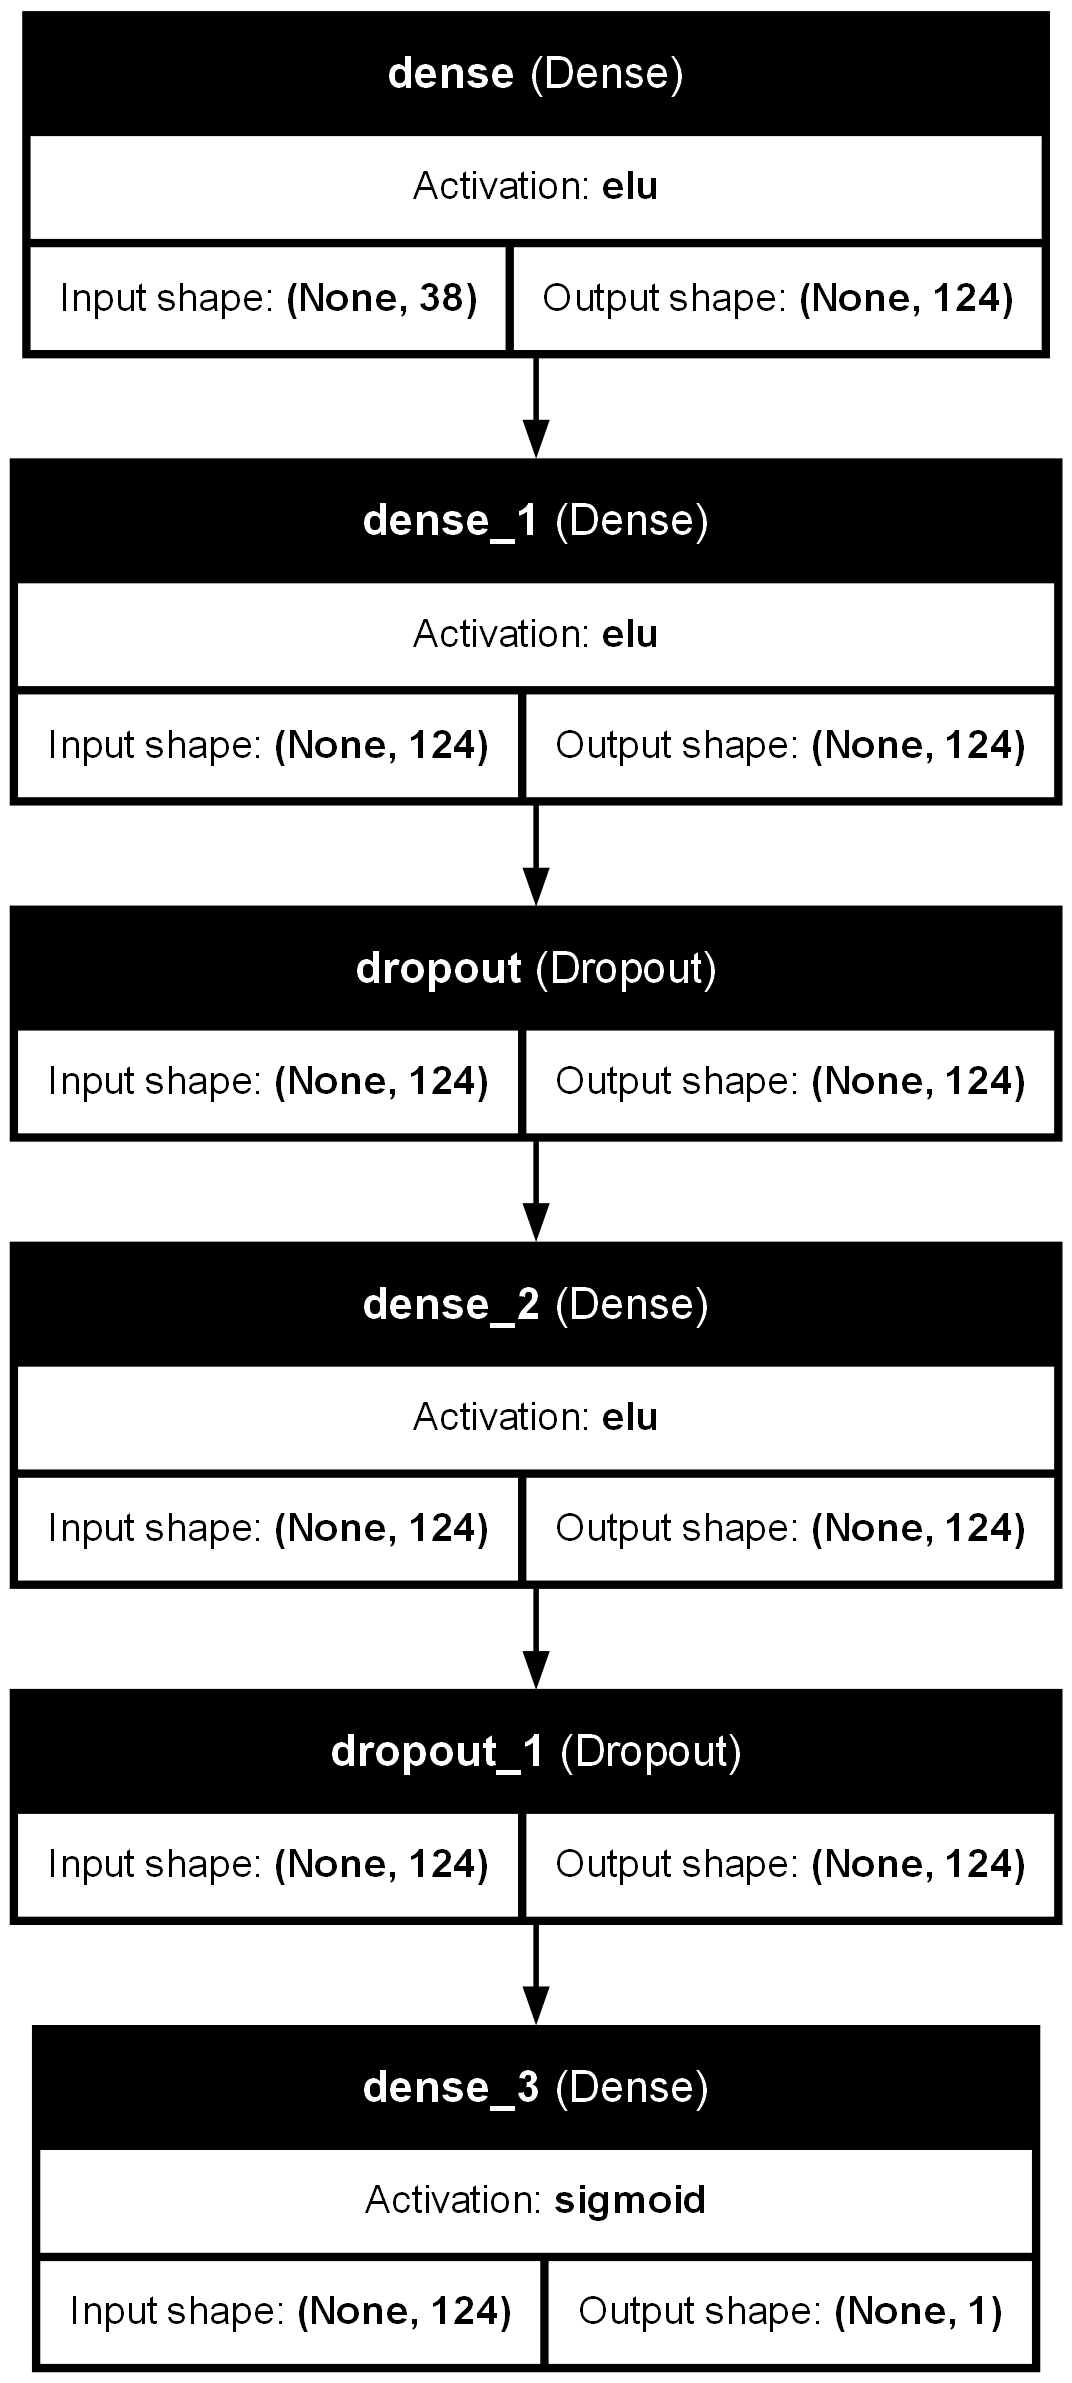

In [ ]:
# 21. Plot model diagram
plot_model(final_model, to_file='NN1.png', show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [5]:
# 22. Check inference speed on test set
%timeit -r 10 -n 100 y_test_pred_prob = final_model.predict(X_test_processed)

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step
77/77 ━━━━━━━━━━